# 목표:
- 캐글의 산탄데르 고객 만족 데이터 세트 : 고객 만족 여부를 활용한 예측
- 예측은 XGBoost와 LightGBM을 활용
- 성능평가는 ROC-AUC를 활용
- why ROC-AUC: 대부분이 만족이고 불만족데이터는 일부분으로 불균형
- https://www.kaggle.com/c/santander-customer-satisfaction/data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

In [32]:
custom_df = pd.read_csv('./datasets/train.csv', encoding='latin-1')
print('datasets shape is', custom_df.shape)
custom_df.head(3)

datasets shape is (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [33]:
# 정보 보기
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [34]:
# 레이블(target속성) 값의 분포 확인
print(custom_df['TARGET'].value_counts())
unsatisfied_cnt = custom_df[custom_df['TARGET'] == 1]['TARGET'].count()
total_cnt = custom_df['TARGET'].count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [35]:
custom_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [36]:
print(custom_df.var3.value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [37]:
custom_df['var3'].replace(-999999, 2, inplace=True)
custom_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
x_features = custom_df.iloc[:,:-1]
y_labels = custom_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(x_features.shape))

피처 데이터 shape:(76020, 369)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape:{0}, 테스트 세트 shape:{1}'.format(x_train.shape, x_test.shape))
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape:(60816, 369), 테스트 세트 shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


# 학습모델 생성 및 예측 (1)
- XGBoost학습, ROC AUC예측

In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 모델 생성 : n_estimators는 500 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

In [39]:
# 성능 평가 지표 : auc , 조기 중단 파라미터 : 100
xgb_clf.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='auc',
            eval_set=[(x_train, y_train), (x_test, y_test)])

# predict_proba로 예측하면 라벨이 2개일 때 각 라벨에 대한 확류을 표시해 준다.
# 즉, 라벨이 0, 1이라면 0.98, 0.02로 - 우리는 1열의 확률을 사용하겠다하여 하기와 같이.
pred_proba = xgb_clf.predict_proba(x_test)[:,1]
xgb_roc_score = roc_auc_score(y_test, pred_proba, average='macro')
print('ROC ACU: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

# 하이퍼파라미터 튜닝
- 많은 튜닝을 하면 시간이 소요되어 일부만

In [40]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도 향상을 위해 n_estimators : 100
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7],
         'min_child_weight':[1, 3],
         'colsample_bytree':[0.5, 0.75]}

# 하이퍼 파라미터 테스트 수행속도 향상을 위해 cv 지정 안함
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc',
          eval_set=[(x_train, y_train), (x_test, y_test)])
pred_proba = gridcv.predict_proba(x_test)[:,1]
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, pred_proba, average='macro')

[0]	validation_0-auc:0.716371	validation_1-auc:0.721224
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.808233	validation_1-auc:0.811497
[2]	validation_0-auc:0.804883	validation_1-auc:0.804536
[3]	validation_0-auc:0.815261	validation_1-auc:0.81637
[4]	validation_0-auc:0.825247	validation_1-auc:0.824507
[5]	validation_0-auc:0.819668	validation_1-auc:0.820074
[6]	validation_0-auc:0.818989	validation_1-auc:0.819519
[7]	validation_0-auc:0.824907	validation_1-auc:0.825344
[8]	validation_0-auc:0.828985	validation_1-auc:0.828536
[9]	validation_0-auc:0.827021	validation_1-auc:0.825688
[10]	validation_0-auc:0.83165	validation_1-auc:0.828585
[11]	validation_0-auc:0.834058	validation_1-auc:0.831318
[12]	validation_0-auc:0.836334	validation_1-auc:0.832347
[13]	validation_0-auc:0.835441	validation_1-auc:0.831432
[14]	validation_0-auc:0.834861	validation_1-auc:0.830882


[47]	validation_0-auc:0.862967	validation_1-auc:0.842593
[48]	validation_0-auc:0.863551	validation_1-auc:0.84261
[49]	validation_0-auc:0.864042	validation_1-auc:0.842599
[50]	validation_0-auc:0.864366	validation_1-auc:0.842434
[51]	validation_0-auc:0.865353	validation_1-auc:0.843195
[52]	validation_0-auc:0.866013	validation_1-auc:0.843838
[53]	validation_0-auc:0.866414	validation_1-auc:0.84388
[54]	validation_0-auc:0.86717	validation_1-auc:0.844016
[55]	validation_0-auc:0.867641	validation_1-auc:0.8437
[56]	validation_0-auc:0.868209	validation_1-auc:0.844056
[57]	validation_0-auc:0.868522	validation_1-auc:0.844175
[58]	validation_0-auc:0.868781	validation_1-auc:0.844342
[59]	validation_0-auc:0.869079	validation_1-auc:0.844691
[60]	validation_0-auc:0.869423	validation_1-auc:0.844647
[61]	validation_0-auc:0.869812	validation_1-auc:0.844665
[62]	validation_0-auc:0.870011	validation_1-auc:0.844629
[63]	validation_0-auc:0.870417	validation_1-auc:0.844743
[64]	validation_0-auc:0.870882	valid

[1]	validation_0-auc:0.809291	validation_1-auc:0.810292
[2]	validation_0-auc:0.801509	validation_1-auc:0.805559
[3]	validation_0-auc:0.811599	validation_1-auc:0.814615
[4]	validation_0-auc:0.823122	validation_1-auc:0.824642
[5]	validation_0-auc:0.820774	validation_1-auc:0.820123
[6]	validation_0-auc:0.819431	validation_1-auc:0.819198
[7]	validation_0-auc:0.82599	validation_1-auc:0.825043
[8]	validation_0-auc:0.830975	validation_1-auc:0.829029
[9]	validation_0-auc:0.829664	validation_1-auc:0.827526
[10]	validation_0-auc:0.831341	validation_1-auc:0.829234
[11]	validation_0-auc:0.833655	validation_1-auc:0.83098
[12]	validation_0-auc:0.836167	validation_1-auc:0.832389
[13]	validation_0-auc:0.835919	validation_1-auc:0.830942
[14]	validation_0-auc:0.835294	validation_1-auc:0.831207
[15]	validation_0-auc:0.838006	validation_1-auc:0.832957
[16]	validation_0-auc:0.840265	validation_1-auc:0.834066
[17]	validation_0-auc:0.843274	validation_1-auc:0.837085
[18]	validation_0-auc:0.844687	validation_

[49]	validation_0-auc:0.865152	validation_1-auc:0.840495
[50]	validation_0-auc:0.865554	validation_1-auc:0.840383
[51]	validation_0-auc:0.866651	validation_1-auc:0.841277
[52]	validation_0-auc:0.867289	validation_1-auc:0.841679
[53]	validation_0-auc:0.86781	validation_1-auc:0.842134
[54]	validation_0-auc:0.868175	validation_1-auc:0.842503
[55]	validation_0-auc:0.868746	validation_1-auc:0.842126
[56]	validation_0-auc:0.869264	validation_1-auc:0.842363
[57]	validation_0-auc:0.869795	validation_1-auc:0.842344
[58]	validation_0-auc:0.870406	validation_1-auc:0.842145
[59]	validation_0-auc:0.870529	validation_1-auc:0.842306
[60]	validation_0-auc:0.870793	validation_1-auc:0.842345
[61]	validation_0-auc:0.871081	validation_1-auc:0.842398
[62]	validation_0-auc:0.871391	validation_1-auc:0.84243
[63]	validation_0-auc:0.871823	validation_1-auc:0.842369
[64]	validation_0-auc:0.872147	validation_1-auc:0.842177
[65]	validation_0-auc:0.872387	validation_1-auc:0.842151
[66]	validation_0-auc:0.872716	va

[91]	validation_0-auc:0.873633	validation_1-auc:0.841873
[92]	validation_0-auc:0.873647	validation_1-auc:0.841868
Stopping. Best iteration:
[62]	validation_0-auc:0.867211	validation_1-auc:0.842672

[0]	validation_0-auc:0.720599	validation_1-auc:0.727176
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.813587	validation_1-auc:0.811508
[2]	validation_0-auc:0.809088	validation_1-auc:0.810017
[3]	validation_0-auc:0.816841	validation_1-auc:0.817096
[4]	validation_0-auc:0.825512	validation_1-auc:0.82418
[5]	validation_0-auc:0.819472	validation_1-auc:0.819553
[6]	validation_0-auc:0.818305	validation_1-auc:0.817745
[7]	validation_0-auc:0.824445	validation_1-auc:0.821165
[8]	validation_0-auc:0.829549	validation_1-auc:0.824451
[9]	validation_0-auc:0.827249	validation_1-auc:0.822791
[10]	validation_0-auc:0.831955	validation_1-auc:0.826125
[11]	validation_0-auc:0.83463

[44]	validation_0-auc:0.859675	validation_1-auc:0.843153
[45]	validation_0-auc:0.859877	validation_1-auc:0.842876
[46]	validation_0-auc:0.860834	validation_1-auc:0.843148
[47]	validation_0-auc:0.86139	validation_1-auc:0.84365
[48]	validation_0-auc:0.861896	validation_1-auc:0.843055
[49]	validation_0-auc:0.86227	validation_1-auc:0.843147
[50]	validation_0-auc:0.862465	validation_1-auc:0.843175
[51]	validation_0-auc:0.863455	validation_1-auc:0.843601
[52]	validation_0-auc:0.864045	validation_1-auc:0.844561
[53]	validation_0-auc:0.864373	validation_1-auc:0.844592
[54]	validation_0-auc:0.865132	validation_1-auc:0.844711
[55]	validation_0-auc:0.865639	validation_1-auc:0.844622
[56]	validation_0-auc:0.866214	validation_1-auc:0.844794
[57]	validation_0-auc:0.866654	validation_1-auc:0.845023
[58]	validation_0-auc:0.866913	validation_1-auc:0.844949
[59]	validation_0-auc:0.867022	validation_1-auc:0.845055
[60]	validation_0-auc:0.867324	validation_1-auc:0.845122
[61]	validation_0-auc:0.867565	val

[0]	validation_0-auc:0.735027	validation_1-auc:0.735335
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81492	validation_1-auc:0.813277
[2]	validation_0-auc:0.810019	validation_1-auc:0.807851
[3]	validation_0-auc:0.822639	validation_1-auc:0.822826
[4]	validation_0-auc:0.830942	validation_1-auc:0.828226
[5]	validation_0-auc:0.826201	validation_1-auc:0.824934
[6]	validation_0-auc:0.822353	validation_1-auc:0.822025
[7]	validation_0-auc:0.827969	validation_1-auc:0.826601
[8]	validation_0-auc:0.831812	validation_1-auc:0.829191
[9]	validation_0-auc:0.831194	validation_1-auc:0.830193
[10]	validation_0-auc:0.834307	validation_1-auc:0.830952
[11]	validation_0-auc:0.837904	validation_1-auc:0.833269
[12]	validation_0-auc:0.839525	validation_1-auc:0.833868
[13]	validation_0-auc:0.839272	validation_1-auc:0.833541
[14]	validation_0-auc:0.837883	validation_1-auc:0.832479

[44]	validation_0-auc:0.883866	validation_1-auc:0.838308
[45]	validation_0-auc:0.88396	validation_1-auc:0.837827
[46]	validation_0-auc:0.885263	validation_1-auc:0.838541
[47]	validation_0-auc:0.886254	validation_1-auc:0.839524
[48]	validation_0-auc:0.887196	validation_1-auc:0.839156
[49]	validation_0-auc:0.887871	validation_1-auc:0.839015
[50]	validation_0-auc:0.888027	validation_1-auc:0.838628
[51]	validation_0-auc:0.888877	validation_1-auc:0.838931
[52]	validation_0-auc:0.889471	validation_1-auc:0.839587
[53]	validation_0-auc:0.889866	validation_1-auc:0.839802
[54]	validation_0-auc:0.890597	validation_1-auc:0.839836
[55]	validation_0-auc:0.891061	validation_1-auc:0.83964
[56]	validation_0-auc:0.891719	validation_1-auc:0.840061
[57]	validation_0-auc:0.892214	validation_1-auc:0.840121
[58]	validation_0-auc:0.892491	validation_1-auc:0.839979
[59]	validation_0-auc:0.892534	validation_1-auc:0.839805
[60]	validation_0-auc:0.893058	validation_1-auc:0.840159
[61]	validation_0-auc:0.893279	va

[20]	validation_0-auc:0.861065	validation_1-auc:0.837455
[21]	validation_0-auc:0.861623	validation_1-auc:0.836928
[22]	validation_0-auc:0.860825	validation_1-auc:0.83631
[23]	validation_0-auc:0.862987	validation_1-auc:0.836815
[24]	validation_0-auc:0.863947	validation_1-auc:0.83794
[25]	validation_0-auc:0.863592	validation_1-auc:0.837839
[26]	validation_0-auc:0.864485	validation_1-auc:0.837299
[27]	validation_0-auc:0.866097	validation_1-auc:0.837962
[28]	validation_0-auc:0.868118	validation_1-auc:0.837987
[29]	validation_0-auc:0.868262	validation_1-auc:0.838402
[30]	validation_0-auc:0.869825	validation_1-auc:0.839272
[31]	validation_0-auc:0.871116	validation_1-auc:0.839298
[32]	validation_0-auc:0.871551	validation_1-auc:0.838975
[33]	validation_0-auc:0.872337	validation_1-auc:0.838641
[34]	validation_0-auc:0.873346	validation_1-auc:0.838029
[35]	validation_0-auc:0.876211	validation_1-auc:0.837885
[36]	validation_0-auc:0.878087	validation_1-auc:0.837843
[37]	validation_0-auc:0.87863	val

[74]	validation_0-auc:0.896502	validation_1-auc:0.843407
[75]	validation_0-auc:0.896762	validation_1-auc:0.843536
[76]	validation_0-auc:0.896822	validation_1-auc:0.843657
[77]	validation_0-auc:0.896957	validation_1-auc:0.843717
[78]	validation_0-auc:0.897215	validation_1-auc:0.843671
[79]	validation_0-auc:0.897411	validation_1-auc:0.84374
[80]	validation_0-auc:0.897455	validation_1-auc:0.84355
[81]	validation_0-auc:0.897449	validation_1-auc:0.843488
[82]	validation_0-auc:0.897494	validation_1-auc:0.843507
[83]	validation_0-auc:0.898414	validation_1-auc:0.844046
[84]	validation_0-auc:0.898664	validation_1-auc:0.843991
[85]	validation_0-auc:0.898771	validation_1-auc:0.844074
[86]	validation_0-auc:0.898867	validation_1-auc:0.844106
[87]	validation_0-auc:0.899498	validation_1-auc:0.844263
[88]	validation_0-auc:0.899696	validation_1-auc:0.844176
[89]	validation_0-auc:0.899781	validation_1-auc:0.844125
[90]	validation_0-auc:0.900419	validation_1-auc:0.844283
[91]	validation_0-auc:0.90043	val

[17]	validation_0-auc:0.85466	validation_1-auc:0.83771
[18]	validation_0-auc:0.855903	validation_1-auc:0.838248
[19]	validation_0-auc:0.855356	validation_1-auc:0.838063
[20]	validation_0-auc:0.857937	validation_1-auc:0.839188
[21]	validation_0-auc:0.858802	validation_1-auc:0.838105
[22]	validation_0-auc:0.858538	validation_1-auc:0.836951
[23]	validation_0-auc:0.860263	validation_1-auc:0.838669
[24]	validation_0-auc:0.86152	validation_1-auc:0.839808
[25]	validation_0-auc:0.861871	validation_1-auc:0.838553
[26]	validation_0-auc:0.862476	validation_1-auc:0.837949
[27]	validation_0-auc:0.864001	validation_1-auc:0.839431
[28]	validation_0-auc:0.865204	validation_1-auc:0.839756
[29]	validation_0-auc:0.865209	validation_1-auc:0.838697
[30]	validation_0-auc:0.86648	validation_1-auc:0.839908
[31]	validation_0-auc:0.867883	validation_1-auc:0.840735
[32]	validation_0-auc:0.868741	validation_1-auc:0.840484
[33]	validation_0-auc:0.869669	validation_1-auc:0.840787
[34]	validation_0-auc:0.869892	vali

[59]	validation_0-auc:0.885952	validation_1-auc:0.84472
[60]	validation_0-auc:0.886392	validation_1-auc:0.844757
[61]	validation_0-auc:0.886671	validation_1-auc:0.844602
[62]	validation_0-auc:0.886879	validation_1-auc:0.844753
[63]	validation_0-auc:0.887226	validation_1-auc:0.844586
[64]	validation_0-auc:0.887641	validation_1-auc:0.844526
[65]	validation_0-auc:0.887963	validation_1-auc:0.844478
[66]	validation_0-auc:0.888125	validation_1-auc:0.844307
[67]	validation_0-auc:0.88838	validation_1-auc:0.844354
[68]	validation_0-auc:0.888613	validation_1-auc:0.844493
[69]	validation_0-auc:0.888692	validation_1-auc:0.844463
[70]	validation_0-auc:0.888954	validation_1-auc:0.844633
[71]	validation_0-auc:0.889285	validation_1-auc:0.844523
[72]	validation_0-auc:0.889456	validation_1-auc:0.844447
[73]	validation_0-auc:0.889553	validation_1-auc:0.844276
[74]	validation_0-auc:0.889602	validation_1-auc:0.844382
[75]	validation_0-auc:0.889765	validation_1-auc:0.844364
[76]	validation_0-auc:0.889802	va

[17]	validation_0-auc:0.854478	validation_1-auc:0.836062
[18]	validation_0-auc:0.856799	validation_1-auc:0.838367
[19]	validation_0-auc:0.855686	validation_1-auc:0.837554
[20]	validation_0-auc:0.856948	validation_1-auc:0.837934
[21]	validation_0-auc:0.857847	validation_1-auc:0.837916
[22]	validation_0-auc:0.857669	validation_1-auc:0.837855
[23]	validation_0-auc:0.859283	validation_1-auc:0.838945
[24]	validation_0-auc:0.86041	validation_1-auc:0.839746
[25]	validation_0-auc:0.860838	validation_1-auc:0.839309
[26]	validation_0-auc:0.861041	validation_1-auc:0.838778
[27]	validation_0-auc:0.862158	validation_1-auc:0.839817
[28]	validation_0-auc:0.863805	validation_1-auc:0.840639
[29]	validation_0-auc:0.864097	validation_1-auc:0.840569
[30]	validation_0-auc:0.866199	validation_1-auc:0.841654
[31]	validation_0-auc:0.867624	validation_1-auc:0.842761
[32]	validation_0-auc:0.867772	validation_1-auc:0.841998
[33]	validation_0-auc:0.86771	validation_1-auc:0.842154
[34]	validation_0-auc:0.868043	va

[80]	validation_0-auc:0.893242	validation_1-auc:0.842128
[81]	validation_0-auc:0.893335	validation_1-auc:0.84216
[82]	validation_0-auc:0.893393	validation_1-auc:0.84219
[83]	validation_0-auc:0.893833	validation_1-auc:0.842336
[84]	validation_0-auc:0.894021	validation_1-auc:0.842299
[85]	validation_0-auc:0.89418	validation_1-auc:0.842333
[86]	validation_0-auc:0.894252	validation_1-auc:0.842303
[87]	validation_0-auc:0.894739	validation_1-auc:0.842302
[88]	validation_0-auc:0.894996	validation_1-auc:0.842276
[89]	validation_0-auc:0.895222	validation_1-auc:0.842239
[90]	validation_0-auc:0.895531	validation_1-auc:0.842325
[91]	validation_0-auc:0.896119	validation_1-auc:0.84252
[92]	validation_0-auc:0.896216	validation_1-auc:0.842463
[93]	validation_0-auc:0.896321	validation_1-auc:0.842536
[94]	validation_0-auc:0.896373	validation_1-auc:0.842526
[95]	validation_0-auc:0.896786	validation_1-auc:0.842292
[96]	validation_0-auc:0.897123	validation_1-auc:0.842485
[97]	validation_0-auc:0.89727	valid

[46]	validation_0-auc:0.8648	validation_1-auc:0.841669
[47]	validation_0-auc:0.865247	validation_1-auc:0.841793
[48]	validation_0-auc:0.865712	validation_1-auc:0.842127
[49]	validation_0-auc:0.86601	validation_1-auc:0.841942
[50]	validation_0-auc:0.866654	validation_1-auc:0.841979
[51]	validation_0-auc:0.867175	validation_1-auc:0.842368
[52]	validation_0-auc:0.867716	validation_1-auc:0.84232
[53]	validation_0-auc:0.86815	validation_1-auc:0.842158
[54]	validation_0-auc:0.868542	validation_1-auc:0.842209
[55]	validation_0-auc:0.868815	validation_1-auc:0.84224
[56]	validation_0-auc:0.869038	validation_1-auc:0.842059
[57]	validation_0-auc:0.869329	validation_1-auc:0.842016
[58]	validation_0-auc:0.869477	validation_1-auc:0.841913
[59]	validation_0-auc:0.869677	validation_1-auc:0.842133
[60]	validation_0-auc:0.869763	validation_1-auc:0.841683
[61]	validation_0-auc:0.870157	validation_1-auc:0.841694
[62]	validation_0-auc:0.87072	validation_1-auc:0.841797
[63]	validation_0-auc:0.871404	validat

[21]	validation_0-auc:0.848269	validation_1-auc:0.838609
[22]	validation_0-auc:0.84854	validation_1-auc:0.838861
[23]	validation_0-auc:0.849219	validation_1-auc:0.839214
[24]	validation_0-auc:0.849667	validation_1-auc:0.839421
[25]	validation_0-auc:0.851032	validation_1-auc:0.839631
[26]	validation_0-auc:0.851507	validation_1-auc:0.839443
[27]	validation_0-auc:0.85173	validation_1-auc:0.840068
[28]	validation_0-auc:0.852347	validation_1-auc:0.840321
[29]	validation_0-auc:0.852853	validation_1-auc:0.840549
[30]	validation_0-auc:0.853382	validation_1-auc:0.840983
[31]	validation_0-auc:0.85414	validation_1-auc:0.841168
[32]	validation_0-auc:0.854864	validation_1-auc:0.840985
[33]	validation_0-auc:0.856042	validation_1-auc:0.840964
[34]	validation_0-auc:0.856663	validation_1-auc:0.840887
[35]	validation_0-auc:0.857275	validation_1-auc:0.840755
[36]	validation_0-auc:0.857992	validation_1-auc:0.840891
[37]	validation_0-auc:0.858724	validation_1-auc:0.841442
[38]	validation_0-auc:0.859673	val

[67]	validation_0-auc:0.874094	validation_1-auc:0.841995
[68]	validation_0-auc:0.874293	validation_1-auc:0.842076
[69]	validation_0-auc:0.874574	validation_1-auc:0.842319
[70]	validation_0-auc:0.874776	validation_1-auc:0.842496
[71]	validation_0-auc:0.875001	validation_1-auc:0.842369
[72]	validation_0-auc:0.875482	validation_1-auc:0.842579
[73]	validation_0-auc:0.875802	validation_1-auc:0.842413
[74]	validation_0-auc:0.875986	validation_1-auc:0.842394
[75]	validation_0-auc:0.876425	validation_1-auc:0.842592
[76]	validation_0-auc:0.876479	validation_1-auc:0.842572
[77]	validation_0-auc:0.876697	validation_1-auc:0.842393
[78]	validation_0-auc:0.87704	validation_1-auc:0.842439
[79]	validation_0-auc:0.877125	validation_1-auc:0.842482
[80]	validation_0-auc:0.877379	validation_1-auc:0.842524
[81]	validation_0-auc:0.877719	validation_1-auc:0.842536
[82]	validation_0-auc:0.87812	validation_1-auc:0.842526
[83]	validation_0-auc:0.878209	validation_1-auc:0.842568
[84]	validation_0-auc:0.878395	va

[35]	validation_0-auc:0.85759	validation_1-auc:0.842726
[36]	validation_0-auc:0.858	validation_1-auc:0.842454
[37]	validation_0-auc:0.858333	validation_1-auc:0.841799
[38]	validation_0-auc:0.858777	validation_1-auc:0.841887
[39]	validation_0-auc:0.85928	validation_1-auc:0.84174
[40]	validation_0-auc:0.859781	validation_1-auc:0.841652
[41]	validation_0-auc:0.860396	validation_1-auc:0.842248
[42]	validation_0-auc:0.860868	validation_1-auc:0.842219
[43]	validation_0-auc:0.861316	validation_1-auc:0.842178
[44]	validation_0-auc:0.86181	validation_1-auc:0.842234
[45]	validation_0-auc:0.86229	validation_1-auc:0.842692
[46]	validation_0-auc:0.862674	validation_1-auc:0.84277
[47]	validation_0-auc:0.862953	validation_1-auc:0.842554
[48]	validation_0-auc:0.863416	validation_1-auc:0.842482
[49]	validation_0-auc:0.863877	validation_1-auc:0.842551
[50]	validation_0-auc:0.864252	validation_1-auc:0.842979
[51]	validation_0-auc:0.86471	validation_1-auc:0.842786
[52]	validation_0-auc:0.865109	validation

[9]	validation_0-auc:0.838139	validation_1-auc:0.830813
[10]	validation_0-auc:0.838411	validation_1-auc:0.830358
[11]	validation_0-auc:0.839455	validation_1-auc:0.831975
[12]	validation_0-auc:0.840107	validation_1-auc:0.832663
[13]	validation_0-auc:0.841676	validation_1-auc:0.833822
[14]	validation_0-auc:0.842589	validation_1-auc:0.834433
[15]	validation_0-auc:0.843414	validation_1-auc:0.834282
[16]	validation_0-auc:0.84456	validation_1-auc:0.834773
[17]	validation_0-auc:0.845351	validation_1-auc:0.834892
[18]	validation_0-auc:0.845892	validation_1-auc:0.835711
[19]	validation_0-auc:0.845996	validation_1-auc:0.837348
[20]	validation_0-auc:0.847836	validation_1-auc:0.837871
[21]	validation_0-auc:0.847642	validation_1-auc:0.838138
[22]	validation_0-auc:0.84825	validation_1-auc:0.838559
[23]	validation_0-auc:0.848683	validation_1-auc:0.838986
[24]	validation_0-auc:0.848893	validation_1-auc:0.838704
[25]	validation_0-auc:0.850001	validation_1-auc:0.839012
[26]	validation_0-auc:0.850519	val

[72]	validation_0-auc:0.872146	validation_1-auc:0.843327
[73]	validation_0-auc:0.87233	validation_1-auc:0.843429
[74]	validation_0-auc:0.872579	validation_1-auc:0.84338
[75]	validation_0-auc:0.872866	validation_1-auc:0.843064
[76]	validation_0-auc:0.872944	validation_1-auc:0.843145
[77]	validation_0-auc:0.873056	validation_1-auc:0.843229
[78]	validation_0-auc:0.87328	validation_1-auc:0.843186
[79]	validation_0-auc:0.873387	validation_1-auc:0.843194
[80]	validation_0-auc:0.87354	validation_1-auc:0.842953
[81]	validation_0-auc:0.873669	validation_1-auc:0.842926
[82]	validation_0-auc:0.873865	validation_1-auc:0.842949
[83]	validation_0-auc:0.873971	validation_1-auc:0.842868
[84]	validation_0-auc:0.874092	validation_1-auc:0.842976
[85]	validation_0-auc:0.874239	validation_1-auc:0.84318
[86]	validation_0-auc:0.874292	validation_1-auc:0.843079
[87]	validation_0-auc:0.874648	validation_1-auc:0.843095
[88]	validation_0-auc:0.874955	validation_1-auc:0.842935
[89]	validation_0-auc:0.875037	valid

[38]	validation_0-auc:0.881984	validation_1-auc:0.842147
[39]	validation_0-auc:0.882994	validation_1-auc:0.841905
[40]	validation_0-auc:0.88375	validation_1-auc:0.842009
[41]	validation_0-auc:0.884477	validation_1-auc:0.842543
[42]	validation_0-auc:0.885354	validation_1-auc:0.842277
[43]	validation_0-auc:0.886504	validation_1-auc:0.841963
[44]	validation_0-auc:0.887218	validation_1-auc:0.841897
[45]	validation_0-auc:0.888024	validation_1-auc:0.842132
[46]	validation_0-auc:0.88871	validation_1-auc:0.842191
[47]	validation_0-auc:0.889249	validation_1-auc:0.841935
[48]	validation_0-auc:0.889782	validation_1-auc:0.841548
[49]	validation_0-auc:0.890499	validation_1-auc:0.841694
[50]	validation_0-auc:0.891322	validation_1-auc:0.841738
[51]	validation_0-auc:0.891809	validation_1-auc:0.841493
[52]	validation_0-auc:0.89246	validation_1-auc:0.84135
[53]	validation_0-auc:0.892825	validation_1-auc:0.841669
[54]	validation_0-auc:0.89329	validation_1-auc:0.841769
[55]	validation_0-auc:0.893402	valid

[57]	validation_0-auc:0.893694	validation_1-auc:0.843455
[58]	validation_0-auc:0.894555	validation_1-auc:0.843582
[59]	validation_0-auc:0.894706	validation_1-auc:0.843591
[60]	validation_0-auc:0.894899	validation_1-auc:0.843354
[61]	validation_0-auc:0.895218	validation_1-auc:0.84345
Stopping. Best iteration:
[31]	validation_0-auc:0.875223	validation_1-auc:0.84504

[0]	validation_0-auc:0.824247	validation_1-auc:0.817042
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.828268	validation_1-auc:0.820775
[2]	validation_0-auc:0.83099	validation_1-auc:0.821871
[3]	validation_0-auc:0.835811	validation_1-auc:0.824768
[4]	validation_0-auc:0.836693	validation_1-auc:0.829421
[5]	validation_0-auc:0.843953	validation_1-auc:0.831358
[6]	validation_0-auc:0.844795	validation_1-auc:0.831664
[7]	validation_0-auc:0.846039	validation_1-auc:0.831437
[8]	validation_0-auc:0.84671	

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.822797	validation_1-auc:0.817858
[2]	validation_0-auc:0.830112	validation_1-auc:0.822657
[3]	validation_0-auc:0.836008	validation_1-auc:0.82756
[4]	validation_0-auc:0.837619	validation_1-auc:0.828466
[5]	validation_0-auc:0.839996	validation_1-auc:0.82965
[6]	validation_0-auc:0.842981	validation_1-auc:0.830086
[7]	validation_0-auc:0.84369	validation_1-auc:0.831006
[8]	validation_0-auc:0.845052	validation_1-auc:0.831272
[9]	validation_0-auc:0.847985	validation_1-auc:0.834577
[10]	validation_0-auc:0.849627	validation_1-auc:0.834416
[11]	validation_0-auc:0.849852	validation_1-auc:0.834503
[12]	validation_0-auc:0.850294	validation_1-auc:0.834119
[13]	validation_0-auc:0.852049	validation_1-auc:0.836065
[14]	validation_0-auc:0.853922	validation_1-auc:0.836222
[15]	validation_0-auc:0.855645	validation_1-auc:0.837817
[16]	validation_0-auc:0.857736	validation_1-auc:0.838048
[17]	validation_0-auc:0.859355	valid

[9]	validation_0-auc:0.846892	validation_1-auc:0.831069
[10]	validation_0-auc:0.848336	validation_1-auc:0.832402
[11]	validation_0-auc:0.85054	validation_1-auc:0.834388
[12]	validation_0-auc:0.851094	validation_1-auc:0.83519
[13]	validation_0-auc:0.853134	validation_1-auc:0.837028
[14]	validation_0-auc:0.854288	validation_1-auc:0.837004
[15]	validation_0-auc:0.855254	validation_1-auc:0.838322
[16]	validation_0-auc:0.856437	validation_1-auc:0.838067
[17]	validation_0-auc:0.857929	validation_1-auc:0.838312
[18]	validation_0-auc:0.859632	validation_1-auc:0.838508
[19]	validation_0-auc:0.860563	validation_1-auc:0.839477
[20]	validation_0-auc:0.862077	validation_1-auc:0.840735
[21]	validation_0-auc:0.862593	validation_1-auc:0.841008
[22]	validation_0-auc:0.86327	validation_1-auc:0.84181
[23]	validation_0-auc:0.864434	validation_1-auc:0.842597
[24]	validation_0-auc:0.865038	validation_1-auc:0.842642
[25]	validation_0-auc:0.86574	validation_1-auc:0.843322
[26]	validation_0-auc:0.86633	validat

[21]	validation_0-auc:0.865776	validation_1-auc:0.838794
[22]	validation_0-auc:0.86524	validation_1-auc:0.838435
[23]	validation_0-auc:0.867317	validation_1-auc:0.839363
[24]	validation_0-auc:0.868569	validation_1-auc:0.840288
[25]	validation_0-auc:0.869447	validation_1-auc:0.840665
[26]	validation_0-auc:0.86984	validation_1-auc:0.84061
[27]	validation_0-auc:0.872001	validation_1-auc:0.84066
[28]	validation_0-auc:0.873911	validation_1-auc:0.840676
[29]	validation_0-auc:0.874193	validation_1-auc:0.841444
[30]	validation_0-auc:0.875648	validation_1-auc:0.842116
[31]	validation_0-auc:0.87691	validation_1-auc:0.842438
[32]	validation_0-auc:0.877819	validation_1-auc:0.841824
[33]	validation_0-auc:0.878313	validation_1-auc:0.841681
[34]	validation_0-auc:0.878535	validation_1-auc:0.841624
[35]	validation_0-auc:0.881047	validation_1-auc:0.842103
[36]	validation_0-auc:0.883147	validation_1-auc:0.842436
[37]	validation_0-auc:0.883825	validation_1-auc:0.842027
[38]	validation_0-auc:0.884627	valid

ValueError: average has to be one of (None, 'micro', 'macro', 'weighted', 'samples')

- 최적의 파라미터는 'max_depth':[5], 'min_child_weight':[1], 'colsample_bytree':[0.75]

- 시간이 오래 걸려 하기 학습은 생략
```
xgb_clf = XGBClassifier(n_estimators=100, random_state=156, learning_rate=0.02,
                       max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)
xgb_clf.fit(x_train, y_train, early_stopping_rounds=200,
           eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])
pred_proba = xgb_clf.predict_proba(x_test)[:,1]
xgb_roc_score = roc_auc_socre(y_test, pred_proba, average='macro')
```

# 피처의 중요도 확인
- plot_importance()

XGBoostError: need to call fit or load_model beforehand

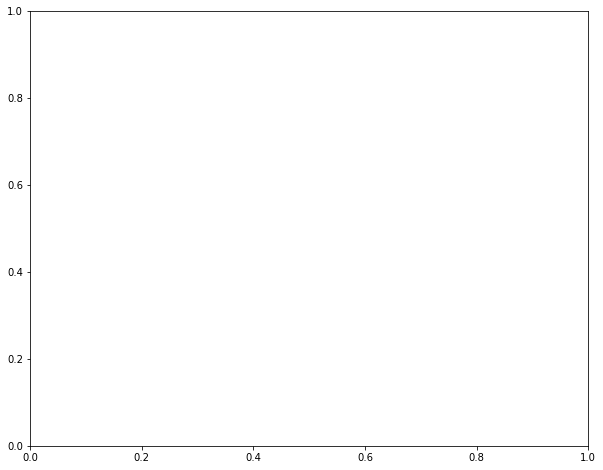

In [41]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

# 학습모델 생성 및 예측 (2)
- LightGBM학습, ROC AUC예측

In [43]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

lgbm_clf.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='auc',
            eval_set=[(x_test, y_test)], verbose=True)
pred_proba = lgbm_clf.predict_proba(x_test)[:,1]

lgbm_roc_score = roc_auc_score(y_test, pred_proba, average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.141

[129]	valid_0's auc: 0.836156	valid_0's binary_logloss: 0.140809
[130]	valid_0's auc: 0.83605	valid_0's binary_logloss: 0.140835
[131]	valid_0's auc: 0.836033	valid_0's binary_logloss: 0.140835
[132]	valid_0's auc: 0.836014	valid_0's binary_logloss: 0.140852
[133]	valid_0's auc: 0.835977	valid_0's binary_logloss: 0.1409
[134]	valid_0's auc: 0.835695	valid_0's binary_logloss: 0.140951
[135]	valid_0's auc: 0.835689	valid_0's binary_logloss: 0.140975
[136]	valid_0's auc: 0.83554	valid_0's binary_logloss: 0.141011
[137]	valid_0's auc: 0.835146	valid_0's binary_logloss: 0.141098
[138]	valid_0's auc: 0.83503	valid_0's binary_logloss: 0.141136
[139]	valid_0's auc: 0.834826	valid_0's binary_logloss: 0.141206
[140]	valid_0's auc: 0.834576	valid_0's binary_logloss: 0.141267
[141]	valid_0's auc: 0.834265	valid_0's binary_logloss: 0.141328
[142]	valid_0's auc: 0.8342	valid_0's binary_logloss: 0.141359
Early stopping, best iteration is:
[42]	valid_0's auc: 0.839599	valid_0's binary_logloss: 0.13940

# 하이퍼파라미터 튜닝
- 많은 튜닝을 하면 시간이 소요되어 일부만

In [45]:
from sklearn.model_selection import GridSearchCV

LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64],
          'max_depth':[128, 160],
          'min_child_weight':[60, 100],
          'colsample_bytree':[0.8, 1]}

In [47]:
# 하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv 지정 X
girdcv = GridSearchCV(lgbm_clf, param_grid=params)
girdcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc',
          eval_set=[(x_train, y_train), (x_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
pred_proba = girdcv.predict_proba(x_test)[:,1]

lgbm_roc_score = roc_auc_score(y_test, pred_proba, average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.735993	valid_0's binary_logloss: 0.162012	valid_1's auc: 0.746462	valid_1's binary_logloss: 0.170236
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.760901	valid_0's binary_logloss: 0.158877	valid_1's auc: 0.767871	valid_1's binary_logloss: 0.166778
[3]	valid_0's auc: 0.809893	valid_0's binary_logloss: 0.153956	valid_1's auc: 0.815523	valid_1's binary_logloss: 0.161579
[4]	valid_0's auc: 0.819481	valid_0's binary_logloss: 0.150621	valid_1's auc: 0.824918	valid_1's binary_logloss: 0.158049
[5]	valid_0's auc: 0.826985	valid_0's binary_logloss: 0.147544	valid_1's auc: 0.830312	valid_1's binary_logloss: 0.154913
[6]	valid_0's auc: 0.830741	valid_0's binary_logloss: 0.145176	valid_1's auc: 0.833332	valid_1's binary_logloss: 0.152402
[7]	valid_0's auc: 0.829905	valid_0's binary_logloss: 0.144114	valid_1's auc: 0.832575	valid_1's binary_logloss: 0.151231
[8]	valid_0's auc: 0.832288	valid_0's binary_logloss: 0.142435	valid_1's auc: 0.83466

[73]	valid_0's auc: 0.855444	valid_0's binary_logloss: 0.128881	valid_1's auc: 0.84271	valid_1's binary_logloss: 0.138767
[74]	valid_0's auc: 0.855616	valid_0's binary_logloss: 0.12883	valid_1's auc: 0.842634	valid_1's binary_logloss: 0.138804
[75]	valid_0's auc: 0.855761	valid_0's binary_logloss: 0.128782	valid_1's auc: 0.842708	valid_1's binary_logloss: 0.138761
[76]	valid_0's auc: 0.855925	valid_0's binary_logloss: 0.128726	valid_1's auc: 0.842742	valid_1's binary_logloss: 0.138753
[77]	valid_0's auc: 0.856102	valid_0's binary_logloss: 0.128676	valid_1's auc: 0.842899	valid_1's binary_logloss: 0.138707
[78]	valid_0's auc: 0.856227	valid_0's binary_logloss: 0.128637	valid_1's auc: 0.842809	valid_1's binary_logloss: 0.138717
[79]	valid_0's auc: 0.856393	valid_0's binary_logloss: 0.128586	valid_1's auc: 0.842769	valid_1's binary_logloss: 0.138729
[80]	valid_0's auc: 0.856537	valid_0's binary_logloss: 0.128551	valid_1's auc: 0.842738	valid_1's binary_logloss: 0.138757
[81]	valid_0's auc

[24]	valid_0's auc: 0.844408	valid_0's binary_logloss: 0.133065	valid_1's auc: 0.839331	valid_1's binary_logloss: 0.140688
[25]	valid_0's auc: 0.844816	valid_0's binary_logloss: 0.132927	valid_1's auc: 0.839773	valid_1's binary_logloss: 0.140552
[26]	valid_0's auc: 0.845276	valid_0's binary_logloss: 0.13269	valid_1's auc: 0.840058	valid_1's binary_logloss: 0.140372
[27]	valid_0's auc: 0.845589	valid_0's binary_logloss: 0.132495	valid_1's auc: 0.840072	valid_1's binary_logloss: 0.140242
[28]	valid_0's auc: 0.845777	valid_0's binary_logloss: 0.132317	valid_1's auc: 0.840244	valid_1's binary_logloss: 0.140073
[29]	valid_0's auc: 0.846023	valid_0's binary_logloss: 0.132161	valid_1's auc: 0.84043	valid_1's binary_logloss: 0.139953
[30]	valid_0's auc: 0.846382	valid_0's binary_logloss: 0.13202	valid_1's auc: 0.840389	valid_1's binary_logloss: 0.139891
[31]	valid_0's auc: 0.846507	valid_0's binary_logloss: 0.131918	valid_1's auc: 0.840074	valid_1's binary_logloss: 0.139867
[32]	valid_0's auc:

[90]	valid_0's auc: 0.858327	valid_0's binary_logloss: 0.128213	valid_1's auc: 0.841314	valid_1's binary_logloss: 0.138962
[91]	valid_0's auc: 0.858499	valid_0's binary_logloss: 0.128179	valid_1's auc: 0.841452	valid_1's binary_logloss: 0.138921
[92]	valid_0's auc: 0.858659	valid_0's binary_logloss: 0.128125	valid_1's auc: 0.841313	valid_1's binary_logloss: 0.138962
[93]	valid_0's auc: 0.858871	valid_0's binary_logloss: 0.128063	valid_1's auc: 0.841698	valid_1's binary_logloss: 0.138891
[94]	valid_0's auc: 0.858981	valid_0's binary_logloss: 0.128027	valid_1's auc: 0.841845	valid_1's binary_logloss: 0.13887
[95]	valid_0's auc: 0.8591	valid_0's binary_logloss: 0.127992	valid_1's auc: 0.84188	valid_1's binary_logloss: 0.13885
[96]	valid_0's auc: 0.859265	valid_0's binary_logloss: 0.127948	valid_1's auc: 0.84165	valid_1's binary_logloss: 0.138912
[97]	valid_0's auc: 0.859411	valid_0's binary_logloss: 0.127903	valid_1's auc: 0.841704	valid_1's binary_logloss: 0.138887
[98]	valid_0's auc: 0.

[19]	valid_0's auc: 0.84273	valid_0's binary_logloss: 0.134278	valid_1's auc: 0.838218	valid_1's binary_logloss: 0.141793
[20]	valid_0's auc: 0.843136	valid_0's binary_logloss: 0.133932	valid_1's auc: 0.838303	valid_1's binary_logloss: 0.14146
[21]	valid_0's auc: 0.843471	valid_0's binary_logloss: 0.133743	valid_1's auc: 0.838816	valid_1's binary_logloss: 0.141255
[22]	valid_0's auc: 0.843838	valid_0's binary_logloss: 0.133467	valid_1's auc: 0.838476	valid_1's binary_logloss: 0.141083
[23]	valid_0's auc: 0.844284	valid_0's binary_logloss: 0.133184	valid_1's auc: 0.838564	valid_1's binary_logloss: 0.140828
[24]	valid_0's auc: 0.844827	valid_0's binary_logloss: 0.132907	valid_1's auc: 0.838862	valid_1's binary_logloss: 0.140586
[25]	valid_0's auc: 0.845296	valid_0's binary_logloss: 0.132667	valid_1's auc: 0.838937	valid_1's binary_logloss: 0.140466
[26]	valid_0's auc: 0.845686	valid_0's binary_logloss: 0.132448	valid_1's auc: 0.839102	valid_1's binary_logloss: 0.140305
[27]	valid_0's auc

[87]	valid_0's auc: 0.85868	valid_0's binary_logloss: 0.128028	valid_1's auc: 0.842129	valid_1's binary_logloss: 0.138787
[88]	valid_0's auc: 0.85884	valid_0's binary_logloss: 0.127987	valid_1's auc: 0.842152	valid_1's binary_logloss: 0.138768
[89]	valid_0's auc: 0.859008	valid_0's binary_logloss: 0.127939	valid_1's auc: 0.842065	valid_1's binary_logloss: 0.13878
[90]	valid_0's auc: 0.859114	valid_0's binary_logloss: 0.1279	valid_1's auc: 0.842141	valid_1's binary_logloss: 0.138774
[91]	valid_0's auc: 0.859282	valid_0's binary_logloss: 0.127862	valid_1's auc: 0.842014	valid_1's binary_logloss: 0.138804
[92]	valid_0's auc: 0.859425	valid_0's binary_logloss: 0.127815	valid_1's auc: 0.841969	valid_1's binary_logloss: 0.138824
[93]	valid_0's auc: 0.859569	valid_0's binary_logloss: 0.12778	valid_1's auc: 0.841922	valid_1's binary_logloss: 0.138832
[94]	valid_0's auc: 0.859774	valid_0's binary_logloss: 0.127716	valid_1's auc: 0.841859	valid_1's binary_logloss: 0.138853
[95]	valid_0's auc: 0.

[34]	valid_0's auc: 0.846451	valid_0's binary_logloss: 0.131613	valid_1's auc: 0.841646	valid_1's binary_logloss: 0.139356
[35]	valid_0's auc: 0.846806	valid_0's binary_logloss: 0.131515	valid_1's auc: 0.841966	valid_1's binary_logloss: 0.13928
[36]	valid_0's auc: 0.847208	valid_0's binary_logloss: 0.131392	valid_1's auc: 0.841945	valid_1's binary_logloss: 0.139247
[37]	valid_0's auc: 0.847422	valid_0's binary_logloss: 0.131292	valid_1's auc: 0.841679	valid_1's binary_logloss: 0.13924
[38]	valid_0's auc: 0.847614	valid_0's binary_logloss: 0.131201	valid_1's auc: 0.841589	valid_1's binary_logloss: 0.139194
[39]	valid_0's auc: 0.847848	valid_0's binary_logloss: 0.131122	valid_1's auc: 0.841638	valid_1's binary_logloss: 0.139173
[40]	valid_0's auc: 0.848039	valid_0's binary_logloss: 0.131033	valid_1's auc: 0.841701	valid_1's binary_logloss: 0.139114
[41]	valid_0's auc: 0.848236	valid_0's binary_logloss: 0.130953	valid_1's auc: 0.841696	valid_1's binary_logloss: 0.139091
[42]	valid_0's auc

[1]	valid_0's auc: 0.740909	valid_0's binary_logloss: 0.162016	valid_1's auc: 0.744721	valid_1's binary_logloss: 0.170294
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.766285	valid_0's binary_logloss: 0.158994	valid_1's auc: 0.770011	valid_1's binary_logloss: 0.166962
[3]	valid_0's auc: 0.813944	valid_0's binary_logloss: 0.154169	valid_1's auc: 0.81381	valid_1's binary_logloss: 0.162
[4]	valid_0's auc: 0.82477	valid_0's binary_logloss: 0.150722	valid_1's auc: 0.824216	valid_1's binary_logloss: 0.1584
[5]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.14757	valid_1's auc: 0.829625	valid_1's binary_logloss: 0.155172
[6]	valid_0's auc: 0.835099	valid_0's binary_logloss: 0.14517	valid_1's auc: 0.831266	valid_1's binary_logloss: 0.152754
[7]	valid_0's auc: 0.834581	valid_0's binary_logloss: 0.144083	valid_1's auc: 0.831696	valid_1's binary_logloss: 0.151522
[8]	valid_0's auc: 0.836689	valid_0's binary_logloss: 0.142334	valid_1's auc: 0.833798	valid_1

[71]	valid_0's auc: 0.856888	valid_0's binary_logloss: 0.128572	valid_1's auc: 0.840949	valid_1's binary_logloss: 0.139124
[72]	valid_0's auc: 0.857033	valid_0's binary_logloss: 0.128522	valid_1's auc: 0.84099	valid_1's binary_logloss: 0.139091
[73]	valid_0's auc: 0.857217	valid_0's binary_logloss: 0.128477	valid_1's auc: 0.84086	valid_1's binary_logloss: 0.139117
[74]	valid_0's auc: 0.857393	valid_0's binary_logloss: 0.128422	valid_1's auc: 0.84095	valid_1's binary_logloss: 0.139081
[75]	valid_0's auc: 0.857506	valid_0's binary_logloss: 0.128379	valid_1's auc: 0.841067	valid_1's binary_logloss: 0.13905
[76]	valid_0's auc: 0.857769	valid_0's binary_logloss: 0.128329	valid_1's auc: 0.841131	valid_1's binary_logloss: 0.139029
[77]	valid_0's auc: 0.857923	valid_0's binary_logloss: 0.12828	valid_1's auc: 0.841129	valid_1's binary_logloss: 0.139038
[78]	valid_0's auc: 0.85807	valid_0's binary_logloss: 0.12824	valid_1's auc: 0.841105	valid_1's binary_logloss: 0.139038
[79]	valid_0's auc: 0.8

[15]	valid_0's auc: 0.837892	valid_0's binary_logloss: 0.136851	valid_1's auc: 0.838647	valid_1's binary_logloss: 0.143816
[16]	valid_0's auc: 0.838852	valid_0's binary_logloss: 0.136221	valid_1's auc: 0.839122	valid_1's binary_logloss: 0.143267
[17]	valid_0's auc: 0.839181	valid_0's binary_logloss: 0.135902	valid_1's auc: 0.838732	valid_1's binary_logloss: 0.143008
[18]	valid_0's auc: 0.840249	valid_0's binary_logloss: 0.135345	valid_1's auc: 0.839829	valid_1's binary_logloss: 0.142482
[19]	valid_0's auc: 0.841015	valid_0's binary_logloss: 0.134871	valid_1's auc: 0.840278	valid_1's binary_logloss: 0.142084
[20]	valid_0's auc: 0.841569	valid_0's binary_logloss: 0.134458	valid_1's auc: 0.840543	valid_1's binary_logloss: 0.141705
[21]	valid_0's auc: 0.842146	valid_0's binary_logloss: 0.134064	valid_1's auc: 0.840663	valid_1's binary_logloss: 0.141359
[22]	valid_0's auc: 0.842294	valid_0's binary_logloss: 0.133889	valid_1's auc: 0.84098	valid_1's binary_logloss: 0.141177
[23]	valid_0's au

[85]	valid_0's auc: 0.857272	valid_0's binary_logloss: 0.128338	valid_1's auc: 0.842924	valid_1's binary_logloss: 0.138679
[86]	valid_0's auc: 0.857394	valid_0's binary_logloss: 0.128303	valid_1's auc: 0.842696	valid_1's binary_logloss: 0.138747
[87]	valid_0's auc: 0.85757	valid_0's binary_logloss: 0.128258	valid_1's auc: 0.842764	valid_1's binary_logloss: 0.138725
[88]	valid_0's auc: 0.857725	valid_0's binary_logloss: 0.128217	valid_1's auc: 0.842983	valid_1's binary_logloss: 0.138689
[89]	valid_0's auc: 0.857827	valid_0's binary_logloss: 0.128182	valid_1's auc: 0.842945	valid_1's binary_logloss: 0.138672
[90]	valid_0's auc: 0.858087	valid_0's binary_logloss: 0.128107	valid_1's auc: 0.843188	valid_1's binary_logloss: 0.138602
[91]	valid_0's auc: 0.858286	valid_0's binary_logloss: 0.12805	valid_1's auc: 0.842952	valid_1's binary_logloss: 0.138659
[92]	valid_0's auc: 0.858408	valid_0's binary_logloss: 0.128011	valid_1's auc: 0.842762	valid_1's binary_logloss: 0.138692
[93]	valid_0's auc

[35]	valid_0's auc: 0.847769	valid_0's binary_logloss: 0.131437	valid_1's auc: 0.840327	valid_1's binary_logloss: 0.139569
[36]	valid_0's auc: 0.848094	valid_0's binary_logloss: 0.1313	valid_1's auc: 0.840594	valid_1's binary_logloss: 0.139486
[37]	valid_0's auc: 0.848241	valid_0's binary_logloss: 0.131225	valid_1's auc: 0.840596	valid_1's binary_logloss: 0.139458
[38]	valid_0's auc: 0.848405	valid_0's binary_logloss: 0.131142	valid_1's auc: 0.840609	valid_1's binary_logloss: 0.139403
[39]	valid_0's auc: 0.848616	valid_0's binary_logloss: 0.131054	valid_1's auc: 0.840519	valid_1's binary_logloss: 0.139416
[40]	valid_0's auc: 0.848715	valid_0's binary_logloss: 0.131	valid_1's auc: 0.840503	valid_1's binary_logloss: 0.139411
[41]	valid_0's auc: 0.848967	valid_0's binary_logloss: 0.130921	valid_1's auc: 0.840335	valid_1's binary_logloss: 0.139439
[42]	valid_0's auc: 0.84924	valid_0's binary_logloss: 0.13084	valid_1's auc: 0.840258	valid_1's binary_logloss: 0.139415
[43]	valid_0's auc: 0.8

[103]	valid_0's auc: 0.860033	valid_0's binary_logloss: 0.127727	valid_1's auc: 0.841641	valid_1's binary_logloss: 0.138936
[104]	valid_0's auc: 0.860203	valid_0's binary_logloss: 0.127683	valid_1's auc: 0.841487	valid_1's binary_logloss: 0.138958
[105]	valid_0's auc: 0.860279	valid_0's binary_logloss: 0.127651	valid_1's auc: 0.841676	valid_1's binary_logloss: 0.138913
[106]	valid_0's auc: 0.860416	valid_0's binary_logloss: 0.127611	valid_1's auc: 0.841655	valid_1's binary_logloss: 0.138925
[107]	valid_0's auc: 0.860528	valid_0's binary_logloss: 0.127575	valid_1's auc: 0.841681	valid_1's binary_logloss: 0.138911
[108]	valid_0's auc: 0.860682	valid_0's binary_logloss: 0.127527	valid_1's auc: 0.841695	valid_1's binary_logloss: 0.138906
[109]	valid_0's auc: 0.860814	valid_0's binary_logloss: 0.127491	valid_1's auc: 0.841759	valid_1's binary_logloss: 0.138884
[110]	valid_0's auc: 0.860866	valid_0's binary_logloss: 0.127474	valid_1's auc: 0.841721	valid_1's binary_logloss: 0.13888
[111]	val

[33]	valid_0's auc: 0.847845	valid_0's binary_logloss: 0.131408	valid_1's auc: 0.838759	valid_1's binary_logloss: 0.139773
[34]	valid_0's auc: 0.84815	valid_0's binary_logloss: 0.131314	valid_1's auc: 0.839178	valid_1's binary_logloss: 0.139695
[35]	valid_0's auc: 0.848438	valid_0's binary_logloss: 0.131195	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.139665
[36]	valid_0's auc: 0.848614	valid_0's binary_logloss: 0.131119	valid_1's auc: 0.838873	valid_1's binary_logloss: 0.139634
[37]	valid_0's auc: 0.848943	valid_0's binary_logloss: 0.131	valid_1's auc: 0.839072	valid_1's binary_logloss: 0.139571
[38]	valid_0's auc: 0.849114	valid_0's binary_logloss: 0.130917	valid_1's auc: 0.839056	valid_1's binary_logloss: 0.139531
[39]	valid_0's auc: 0.849268	valid_0's binary_logloss: 0.130853	valid_1's auc: 0.838835	valid_1's binary_logloss: 0.13954
[40]	valid_0's auc: 0.849531	valid_0's binary_logloss: 0.130757	valid_1's auc: 0.838864	valid_1's binary_logloss: 0.139488
[41]	valid_0's auc: 0

[105]	valid_0's auc: 0.861631	valid_0's binary_logloss: 0.127226	valid_1's auc: 0.841459	valid_1's binary_logloss: 0.138921
[106]	valid_0's auc: 0.861748	valid_0's binary_logloss: 0.127191	valid_1's auc: 0.841307	valid_1's binary_logloss: 0.138962
[107]	valid_0's auc: 0.861895	valid_0's binary_logloss: 0.127153	valid_1's auc: 0.841276	valid_1's binary_logloss: 0.138971
[108]	valid_0's auc: 0.862025	valid_0's binary_logloss: 0.12711	valid_1's auc: 0.841405	valid_1's binary_logloss: 0.138939
[109]	valid_0's auc: 0.862165	valid_0's binary_logloss: 0.12707	valid_1's auc: 0.841406	valid_1's binary_logloss: 0.138926
[110]	valid_0's auc: 0.862268	valid_0's binary_logloss: 0.127033	valid_1's auc: 0.841441	valid_1's binary_logloss: 0.138898
[111]	valid_0's auc: 0.862405	valid_0's binary_logloss: 0.12699	valid_1's auc: 0.84127	valid_1's binary_logloss: 0.138939
[112]	valid_0's auc: 0.862522	valid_0's binary_logloss: 0.126953	valid_1's auc: 0.841312	valid_1's binary_logloss: 0.138944
[113]	valid_

[54]	valid_0's auc: 0.851352	valid_0's binary_logloss: 0.130005	valid_1's auc: 0.84192	valid_1's binary_logloss: 0.138871
[55]	valid_0's auc: 0.851578	valid_0's binary_logloss: 0.129949	valid_1's auc: 0.841925	valid_1's binary_logloss: 0.138869
[56]	valid_0's auc: 0.85176	valid_0's binary_logloss: 0.129885	valid_1's auc: 0.842036	valid_1's binary_logloss: 0.138856
[57]	valid_0's auc: 0.851918	valid_0's binary_logloss: 0.129834	valid_1's auc: 0.842037	valid_1's binary_logloss: 0.138843
[58]	valid_0's auc: 0.852137	valid_0's binary_logloss: 0.129769	valid_1's auc: 0.841924	valid_1's binary_logloss: 0.138874
[59]	valid_0's auc: 0.852313	valid_0's binary_logloss: 0.129713	valid_1's auc: 0.841948	valid_1's binary_logloss: 0.138874
[60]	valid_0's auc: 0.852515	valid_0's binary_logloss: 0.129662	valid_1's auc: 0.841821	valid_1's binary_logloss: 0.138893
[61]	valid_0's auc: 0.852695	valid_0's binary_logloss: 0.129607	valid_1's auc: 0.841932	valid_1's binary_logloss: 0.138854
[62]	valid_0's auc

[24]	valid_0's auc: 0.845761	valid_0's binary_logloss: 0.132953	valid_1's auc: 0.840276	valid_1's binary_logloss: 0.140709
[25]	valid_0's auc: 0.846032	valid_0's binary_logloss: 0.132703	valid_1's auc: 0.8404	valid_1's binary_logloss: 0.140531
[26]	valid_0's auc: 0.846266	valid_0's binary_logloss: 0.132498	valid_1's auc: 0.840377	valid_1's binary_logloss: 0.1404
[27]	valid_0's auc: 0.846709	valid_0's binary_logloss: 0.13235	valid_1's auc: 0.840499	valid_1's binary_logloss: 0.140328
[28]	valid_0's auc: 0.846901	valid_0's binary_logloss: 0.132179	valid_1's auc: 0.840313	valid_1's binary_logloss: 0.140235
[29]	valid_0's auc: 0.847037	valid_0's binary_logloss: 0.132015	valid_1's auc: 0.840299	valid_1's binary_logloss: 0.140128
[30]	valid_0's auc: 0.847385	valid_0's binary_logloss: 0.131841	valid_1's auc: 0.84051	valid_1's binary_logloss: 0.139994
[31]	valid_0's auc: 0.84785	valid_0's binary_logloss: 0.131657	valid_1's auc: 0.840633	valid_1's binary_logloss: 0.139885
[32]	valid_0's auc: 0.8

[92]	valid_0's auc: 0.860334	valid_0's binary_logloss: 0.127583	valid_1's auc: 0.841584	valid_1's binary_logloss: 0.138948
[93]	valid_0's auc: 0.860443	valid_0's binary_logloss: 0.127543	valid_1's auc: 0.841575	valid_1's binary_logloss: 0.13895
[94]	valid_0's auc: 0.860587	valid_0's binary_logloss: 0.127497	valid_1's auc: 0.841659	valid_1's binary_logloss: 0.138944
[95]	valid_0's auc: 0.86077	valid_0's binary_logloss: 0.127456	valid_1's auc: 0.841729	valid_1's binary_logloss: 0.13893
[96]	valid_0's auc: 0.86084	valid_0's binary_logloss: 0.127429	valid_1's auc: 0.841763	valid_1's binary_logloss: 0.138938
[97]	valid_0's auc: 0.861038	valid_0's binary_logloss: 0.127381	valid_1's auc: 0.841544	valid_1's binary_logloss: 0.138978
[98]	valid_0's auc: 0.861129	valid_0's binary_logloss: 0.127342	valid_1's auc: 0.841559	valid_1's binary_logloss: 0.138975
[99]	valid_0's auc: 0.861249	valid_0's binary_logloss: 0.127309	valid_1's auc: 0.841621	valid_1's binary_logloss: 0.13894
[100]	valid_0's auc: 

[32]	valid_0's auc: 0.838981	valid_0's binary_logloss: 0.133612	valid_1's auc: 0.838179	valid_1's binary_logloss: 0.140689
[33]	valid_0's auc: 0.839312	valid_0's binary_logloss: 0.133475	valid_1's auc: 0.838187	valid_1's binary_logloss: 0.140594
[34]	valid_0's auc: 0.839691	valid_0's binary_logloss: 0.13336	valid_1's auc: 0.838273	valid_1's binary_logloss: 0.140533
[35]	valid_0's auc: 0.839888	valid_0's binary_logloss: 0.133258	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.140477
[36]	valid_0's auc: 0.840092	valid_0's binary_logloss: 0.13317	valid_1's auc: 0.838321	valid_1's binary_logloss: 0.1404
[37]	valid_0's auc: 0.840363	valid_0's binary_logloss: 0.133072	valid_1's auc: 0.838343	valid_1's binary_logloss: 0.140343
[38]	valid_0's auc: 0.84052	valid_0's binary_logloss: 0.132981	valid_1's auc: 0.838275	valid_1's binary_logloss: 0.140325
[39]	valid_0's auc: 0.840762	valid_0's binary_logloss: 0.132893	valid_1's auc: 0.838282	valid_1's binary_logloss: 0.140275
[40]	valid_0's auc: 0

[104]	valid_0's auc: 0.850031	valid_0's binary_logloss: 0.13026	valid_1's auc: 0.840257	valid_1's binary_logloss: 0.139552
[105]	valid_0's auc: 0.850118	valid_0's binary_logloss: 0.130227	valid_1's auc: 0.84022	valid_1's binary_logloss: 0.139554
[106]	valid_0's auc: 0.850228	valid_0's binary_logloss: 0.130201	valid_1's auc: 0.84006	valid_1's binary_logloss: 0.139581
[107]	valid_0's auc: 0.850405	valid_0's binary_logloss: 0.130161	valid_1's auc: 0.840081	valid_1's binary_logloss: 0.139564
[108]	valid_0's auc: 0.850473	valid_0's binary_logloss: 0.130137	valid_1's auc: 0.840095	valid_1's binary_logloss: 0.139557
[109]	valid_0's auc: 0.850544	valid_0's binary_logloss: 0.130113	valid_1's auc: 0.840044	valid_1's binary_logloss: 0.139552
[110]	valid_0's auc: 0.850574	valid_0's binary_logloss: 0.130096	valid_1's auc: 0.840085	valid_1's binary_logloss: 0.13955
[111]	valid_0's auc: 0.850665	valid_0's binary_logloss: 0.130072	valid_1's auc: 0.840161	valid_1's binary_logloss: 0.13953
[112]	valid_0

[30]	valid_0's auc: 0.839111	valid_0's binary_logloss: 0.133702	valid_1's auc: 0.836592	valid_1's binary_logloss: 0.140968
[31]	valid_0's auc: 0.839175	valid_0's binary_logloss: 0.133605	valid_1's auc: 0.83629	valid_1's binary_logloss: 0.140923
[32]	valid_0's auc: 0.839589	valid_0's binary_logloss: 0.133522	valid_1's auc: 0.836582	valid_1's binary_logloss: 0.140838
[33]	valid_0's auc: 0.839672	valid_0's binary_logloss: 0.13343	valid_1's auc: 0.836486	valid_1's binary_logloss: 0.140779
[34]	valid_0's auc: 0.839823	valid_0's binary_logloss: 0.133334	valid_1's auc: 0.836472	valid_1's binary_logloss: 0.140707
[35]	valid_0's auc: 0.839842	valid_0's binary_logloss: 0.133271	valid_1's auc: 0.836394	valid_1's binary_logloss: 0.140666
[36]	valid_0's auc: 0.840218	valid_0's binary_logloss: 0.133173	valid_1's auc: 0.836888	valid_1's binary_logloss: 0.140544
[37]	valid_0's auc: 0.840306	valid_0's binary_logloss: 0.133108	valid_1's auc: 0.836757	valid_1's binary_logloss: 0.14054
[38]	valid_0's auc:

[43]	valid_0's auc: 0.842224	valid_0's binary_logloss: 0.132503	valid_1's auc: 0.836776	valid_1's binary_logloss: 0.140177
[44]	valid_0's auc: 0.842502	valid_0's binary_logloss: 0.132426	valid_1's auc: 0.836797	valid_1's binary_logloss: 0.140161
[45]	valid_0's auc: 0.842694	valid_0's binary_logloss: 0.132346	valid_1's auc: 0.836842	valid_1's binary_logloss: 0.140146
[46]	valid_0's auc: 0.842995	valid_0's binary_logloss: 0.132264	valid_1's auc: 0.837052	valid_1's binary_logloss: 0.140105
[47]	valid_0's auc: 0.843191	valid_0's binary_logloss: 0.132197	valid_1's auc: 0.837105	valid_1's binary_logloss: 0.140095
[48]	valid_0's auc: 0.84339	valid_0's binary_logloss: 0.132139	valid_1's auc: 0.837297	valid_1's binary_logloss: 0.140052
[49]	valid_0's auc: 0.843706	valid_0's binary_logloss: 0.132062	valid_1's auc: 0.837563	valid_1's binary_logloss: 0.140018
[50]	valid_0's auc: 0.843839	valid_0's binary_logloss: 0.132014	valid_1's auc: 0.837657	valid_1's binary_logloss: 0.140013
[51]	valid_0's au

[114]	valid_0's auc: 0.85199	valid_0's binary_logloss: 0.129799	valid_1's auc: 0.840302	valid_1's binary_logloss: 0.139363
[115]	valid_0's auc: 0.852112	valid_0's binary_logloss: 0.129773	valid_1's auc: 0.84026	valid_1's binary_logloss: 0.139353
[116]	valid_0's auc: 0.852193	valid_0's binary_logloss: 0.129748	valid_1's auc: 0.840382	valid_1's binary_logloss: 0.139321
[117]	valid_0's auc: 0.852202	valid_0's binary_logloss: 0.129736	valid_1's auc: 0.840204	valid_1's binary_logloss: 0.139365
[118]	valid_0's auc: 0.852278	valid_0's binary_logloss: 0.129713	valid_1's auc: 0.840388	valid_1's binary_logloss: 0.139331
[119]	valid_0's auc: 0.852346	valid_0's binary_logloss: 0.129691	valid_1's auc: 0.840399	valid_1's binary_logloss: 0.139338
[120]	valid_0's auc: 0.852411	valid_0's binary_logloss: 0.129673	valid_1's auc: 0.840387	valid_1's binary_logloss: 0.139334
[121]	valid_0's auc: 0.852493	valid_0's binary_logloss: 0.129644	valid_1's auc: 0.840494	valid_1's binary_logloss: 0.139305
[122]	vali

[12]	valid_0's auc: 0.832902	valid_0's binary_logloss: 0.138775	valid_1's auc: 0.835198	valid_1's binary_logloss: 0.145497
[13]	valid_0's auc: 0.832946	valid_0's binary_logloss: 0.138134	valid_1's auc: 0.835547	valid_1's binary_logloss: 0.144831
[14]	valid_0's auc: 0.833114	valid_0's binary_logloss: 0.137593	valid_1's auc: 0.835671	valid_1's binary_logloss: 0.14423
[15]	valid_0's auc: 0.834162	valid_0's binary_logloss: 0.137274	valid_1's auc: 0.836391	valid_1's binary_logloss: 0.143892
[16]	valid_0's auc: 0.834589	valid_0's binary_logloss: 0.13679	valid_1's auc: 0.836343	valid_1's binary_logloss: 0.143471
[17]	valid_0's auc: 0.835475	valid_0's binary_logloss: 0.136475	valid_1's auc: 0.837111	valid_1's binary_logloss: 0.143154
[18]	valid_0's auc: 0.835625	valid_0's binary_logloss: 0.13613	valid_1's auc: 0.836841	valid_1's binary_logloss: 0.142875
[19]	valid_0's auc: 0.836037	valid_0's binary_logloss: 0.135774	valid_1's auc: 0.837033	valid_1's binary_logloss: 0.142532
[20]	valid_0's auc:

[79]	valid_0's auc: 0.847199	valid_0's binary_logloss: 0.131122	valid_1's auc: 0.840244	valid_1's binary_logloss: 0.139505
[80]	valid_0's auc: 0.847329	valid_0's binary_logloss: 0.131066	valid_1's auc: 0.840269	valid_1's binary_logloss: 0.139506
[81]	valid_0's auc: 0.847479	valid_0's binary_logloss: 0.13103	valid_1's auc: 0.840296	valid_1's binary_logloss: 0.139511
[82]	valid_0's auc: 0.84756	valid_0's binary_logloss: 0.13099	valid_1's auc: 0.840223	valid_1's binary_logloss: 0.139539
[83]	valid_0's auc: 0.84764	valid_0's binary_logloss: 0.130966	valid_1's auc: 0.840168	valid_1's binary_logloss: 0.139562
[84]	valid_0's auc: 0.847696	valid_0's binary_logloss: 0.130933	valid_1's auc: 0.840242	valid_1's binary_logloss: 0.139548
[85]	valid_0's auc: 0.847815	valid_0's binary_logloss: 0.130899	valid_1's auc: 0.840383	valid_1's binary_logloss: 0.139497
[86]	valid_0's auc: 0.847916	valid_0's binary_logloss: 0.130867	valid_1's auc: 0.84034	valid_1's binary_logloss: 0.139483
[87]	valid_0's auc: 0

[11]	valid_0's auc: 0.831985	valid_0's binary_logloss: 0.14054	valid_1's auc: 0.833243	valid_1's binary_logloss: 0.147516
[12]	valid_0's auc: 0.832564	valid_0's binary_logloss: 0.139594	valid_1's auc: 0.83351	valid_1's binary_logloss: 0.146567
[13]	valid_0's auc: 0.833118	valid_0's binary_logloss: 0.138842	valid_1's auc: 0.83385	valid_1's binary_logloss: 0.145747
[14]	valid_0's auc: 0.833366	valid_0's binary_logloss: 0.138545	valid_1's auc: 0.834521	valid_1's binary_logloss: 0.145415
[15]	valid_0's auc: 0.833937	valid_0's binary_logloss: 0.138161	valid_1's auc: 0.834594	valid_1's binary_logloss: 0.145049
[16]	valid_0's auc: 0.834474	valid_0's binary_logloss: 0.137594	valid_1's auc: 0.835147	valid_1's binary_logloss: 0.14446
[17]	valid_0's auc: 0.834595	valid_0's binary_logloss: 0.137331	valid_1's auc: 0.835586	valid_1's binary_logloss: 0.144135
[18]	valid_0's auc: 0.835355	valid_0's binary_logloss: 0.136778	valid_1's auc: 0.836288	valid_1's binary_logloss: 0.143584
[19]	valid_0's auc: 

[84]	valid_0's auc: 0.848348	valid_0's binary_logloss: 0.130719	valid_1's auc: 0.840206	valid_1's binary_logloss: 0.139556
[85]	valid_0's auc: 0.848532	valid_0's binary_logloss: 0.130678	valid_1's auc: 0.840162	valid_1's binary_logloss: 0.139579
[86]	valid_0's auc: 0.848656	valid_0's binary_logloss: 0.130646	valid_1's auc: 0.840153	valid_1's binary_logloss: 0.139579
[87]	valid_0's auc: 0.84875	valid_0's binary_logloss: 0.130624	valid_1's auc: 0.840147	valid_1's binary_logloss: 0.139579
[88]	valid_0's auc: 0.84888	valid_0's binary_logloss: 0.13059	valid_1's auc: 0.840292	valid_1's binary_logloss: 0.139545
[89]	valid_0's auc: 0.848903	valid_0's binary_logloss: 0.130569	valid_1's auc: 0.840333	valid_1's binary_logloss: 0.139534
[90]	valid_0's auc: 0.849028	valid_0's binary_logloss: 0.130529	valid_1's auc: 0.840435	valid_1's binary_logloss: 0.139507
[91]	valid_0's auc: 0.849142	valid_0's binary_logloss: 0.130506	valid_1's auc: 0.84055	valid_1's binary_logloss: 0.139479
[92]	valid_0's auc: 

[151]	valid_0's auc: 0.854346	valid_0's binary_logloss: 0.129104	valid_1's auc: 0.841651	valid_1's binary_logloss: 0.139246
[152]	valid_0's auc: 0.85444	valid_0's binary_logloss: 0.129077	valid_1's auc: 0.841583	valid_1's binary_logloss: 0.13926
[153]	valid_0's auc: 0.854497	valid_0's binary_logloss: 0.129056	valid_1's auc: 0.841654	valid_1's binary_logloss: 0.139238
[154]	valid_0's auc: 0.854535	valid_0's binary_logloss: 0.129041	valid_1's auc: 0.841754	valid_1's binary_logloss: 0.139212
[155]	valid_0's auc: 0.854571	valid_0's binary_logloss: 0.129022	valid_1's auc: 0.841717	valid_1's binary_logloss: 0.139207
[156]	valid_0's auc: 0.854657	valid_0's binary_logloss: 0.129006	valid_1's auc: 0.841604	valid_1's binary_logloss: 0.139226
[157]	valid_0's auc: 0.854716	valid_0's binary_logloss: 0.128988	valid_1's auc: 0.841669	valid_1's binary_logloss: 0.139219
[158]	valid_0's auc: 0.854805	valid_0's binary_logloss: 0.128964	valid_1's auc: 0.841673	valid_1's binary_logloss: 0.139224
[159]	vali

[55]	valid_0's auc: 0.843985	valid_0's binary_logloss: 0.131946	valid_1's auc: 0.839129	valid_1's binary_logloss: 0.139887
[56]	valid_0's auc: 0.844165	valid_0's binary_logloss: 0.131891	valid_1's auc: 0.839094	valid_1's binary_logloss: 0.13989
[57]	valid_0's auc: 0.844342	valid_0's binary_logloss: 0.131847	valid_1's auc: 0.839077	valid_1's binary_logloss: 0.139862
[58]	valid_0's auc: 0.844595	valid_0's binary_logloss: 0.13179	valid_1's auc: 0.839193	valid_1's binary_logloss: 0.139836
[59]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13175	valid_1's auc: 0.83909	valid_1's binary_logloss: 0.139834
[60]	valid_0's auc: 0.84489	valid_0's binary_logloss: 0.131714	valid_1's auc: 0.839119	valid_1's binary_logloss: 0.139824
[61]	valid_0's auc: 0.845079	valid_0's binary_logloss: 0.131668	valid_1's auc: 0.839216	valid_1's binary_logloss: 0.139826
[62]	valid_0's auc: 0.845165	valid_0's binary_logloss: 0.131636	valid_1's auc: 0.839152	valid_1's binary_logloss: 0.13984
[63]	valid_0's auc: 0.

[130]	valid_0's auc: 0.852182	valid_0's binary_logloss: 0.129643	valid_1's auc: 0.840011	valid_1's binary_logloss: 0.1395
[131]	valid_0's auc: 0.852271	valid_0's binary_logloss: 0.129626	valid_1's auc: 0.84012	valid_1's binary_logloss: 0.139479
[132]	valid_0's auc: 0.852388	valid_0's binary_logloss: 0.129604	valid_1's auc: 0.840092	valid_1's binary_logloss: 0.139495
[133]	valid_0's auc: 0.852428	valid_0's binary_logloss: 0.129588	valid_1's auc: 0.840243	valid_1's binary_logloss: 0.139433
[134]	valid_0's auc: 0.852482	valid_0's binary_logloss: 0.129566	valid_1's auc: 0.840271	valid_1's binary_logloss: 0.139423
[135]	valid_0's auc: 0.852559	valid_0's binary_logloss: 0.129548	valid_1's auc: 0.840141	valid_1's binary_logloss: 0.139452
[136]	valid_0's auc: 0.852653	valid_0's binary_logloss: 0.129528	valid_1's auc: 0.839993	valid_1's binary_logloss: 0.139474
[137]	valid_0's auc: 0.852749	valid_0's binary_logloss: 0.129501	valid_1's auc: 0.840088	valid_1's binary_logloss: 0.139435
[138]	valid

[52]	valid_0's auc: 0.842935	valid_0's binary_logloss: 0.132255	valid_1's auc: 0.836859	valid_1's binary_logloss: 0.14027
[53]	valid_0's auc: 0.843139	valid_0's binary_logloss: 0.132205	valid_1's auc: 0.836976	valid_1's binary_logloss: 0.140258
[54]	valid_0's auc: 0.84329	valid_0's binary_logloss: 0.132159	valid_1's auc: 0.837081	valid_1's binary_logloss: 0.140235
[55]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.132112	valid_1's auc: 0.836919	valid_1's binary_logloss: 0.140244
[56]	valid_0's auc: 0.843621	valid_0's binary_logloss: 0.13207	valid_1's auc: 0.836878	valid_1's binary_logloss: 0.14025
Early stopping, best iteration is:
[26]	valid_0's auc: 0.838165	valid_0's binary_logloss: 0.134304	valid_1's auc: 0.837403	valid_1's binary_logloss: 0.141304
[1]	valid_0's auc: 0.729933	valid_0's binary_logloss: 0.162236	valid_1's auc: 0.742249	valid_1's binary_logloss: 0.170427
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.804411	valid_0's binary_log

[63]	valid_0's auc: 0.845987	valid_0's binary_logloss: 0.131409	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.13983
[64]	valid_0's auc: 0.846112	valid_0's binary_logloss: 0.131354	valid_1's auc: 0.838294	valid_1's binary_logloss: 0.139787
[65]	valid_0's auc: 0.846277	valid_0's binary_logloss: 0.131314	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139801
[66]	valid_0's auc: 0.846407	valid_0's binary_logloss: 0.131277	valid_1's auc: 0.838267	valid_1's binary_logloss: 0.139776
[67]	valid_0's auc: 0.846546	valid_0's binary_logloss: 0.131241	valid_1's auc: 0.838379	valid_1's binary_logloss: 0.139764
[68]	valid_0's auc: 0.846682	valid_0's binary_logloss: 0.131206	valid_1's auc: 0.838434	valid_1's binary_logloss: 0.139741
[69]	valid_0's auc: 0.846899	valid_0's binary_logloss: 0.131161	valid_1's auc: 0.83866	valid_1's binary_logloss: 0.139701
[70]	valid_0's auc: 0.84699	valid_0's binary_logloss: 0.131127	valid_1's auc: 0.838737	valid_1's binary_logloss: 0.139678
[71]	valid_0's auc:

[135]	valid_0's auc: 0.853508	valid_0's binary_logloss: 0.129357	valid_1's auc: 0.840747	valid_1's binary_logloss: 0.139257
[136]	valid_0's auc: 0.853542	valid_0's binary_logloss: 0.129336	valid_1's auc: 0.840734	valid_1's binary_logloss: 0.139261
[137]	valid_0's auc: 0.853654	valid_0's binary_logloss: 0.129301	valid_1's auc: 0.840767	valid_1's binary_logloss: 0.139257
[138]	valid_0's auc: 0.853736	valid_0's binary_logloss: 0.129283	valid_1's auc: 0.840712	valid_1's binary_logloss: 0.139276
[139]	valid_0's auc: 0.853858	valid_0's binary_logloss: 0.129251	valid_1's auc: 0.840875	valid_1's binary_logloss: 0.139238
[140]	valid_0's auc: 0.853963	valid_0's binary_logloss: 0.129229	valid_1's auc: 0.840867	valid_1's binary_logloss: 0.139232
[141]	valid_0's auc: 0.854086	valid_0's binary_logloss: 0.129203	valid_1's auc: 0.840924	valid_1's binary_logloss: 0.139209
[142]	valid_0's auc: 0.854169	valid_0's binary_logloss: 0.129181	valid_1's auc: 0.840832	valid_1's binary_logloss: 0.139252
[143]	va

[32]	valid_0's auc: 0.839637	valid_0's binary_logloss: 0.133485	valid_1's auc: 0.838732	valid_1's binary_logloss: 0.140458
[33]	valid_0's auc: 0.83984	valid_0's binary_logloss: 0.133386	valid_1's auc: 0.838609	valid_1's binary_logloss: 0.140413
[34]	valid_0's auc: 0.83994	valid_0's binary_logloss: 0.133289	valid_1's auc: 0.838451	valid_1's binary_logloss: 0.140355
[35]	valid_0's auc: 0.840298	valid_0's binary_logloss: 0.133207	valid_1's auc: 0.838848	valid_1's binary_logloss: 0.140275
[36]	valid_0's auc: 0.840501	valid_0's binary_logloss: 0.13312	valid_1's auc: 0.838683	valid_1's binary_logloss: 0.140227
[37]	valid_0's auc: 0.84053	valid_0's binary_logloss: 0.133058	valid_1's auc: 0.838437	valid_1's binary_logloss: 0.140206
[38]	valid_0's auc: 0.840585	valid_0's binary_logloss: 0.133012	valid_1's auc: 0.838502	valid_1's binary_logloss: 0.140165
[39]	valid_0's auc: 0.84085	valid_0's binary_logloss: 0.132938	valid_1's auc: 0.838594	valid_1's binary_logloss: 0.140127
[40]	valid_0's auc: 0

[103]	valid_0's auc: 0.849838	valid_0's binary_logloss: 0.130323	valid_1's auc: 0.841668	valid_1's binary_logloss: 0.139217
[104]	valid_0's auc: 0.849988	valid_0's binary_logloss: 0.130287	valid_1's auc: 0.841715	valid_1's binary_logloss: 0.1392
[105]	valid_0's auc: 0.850071	valid_0's binary_logloss: 0.130263	valid_1's auc: 0.841726	valid_1's binary_logloss: 0.139197
[106]	valid_0's auc: 0.85015	valid_0's binary_logloss: 0.130232	valid_1's auc: 0.841868	valid_1's binary_logloss: 0.13917
[107]	valid_0's auc: 0.850313	valid_0's binary_logloss: 0.130192	valid_1's auc: 0.841733	valid_1's binary_logloss: 0.139185
[108]	valid_0's auc: 0.850412	valid_0's binary_logloss: 0.130156	valid_1's auc: 0.841701	valid_1's binary_logloss: 0.139188
[109]	valid_0's auc: 0.850513	valid_0's binary_logloss: 0.130129	valid_1's auc: 0.841682	valid_1's binary_logloss: 0.139192
[110]	valid_0's auc: 0.850607	valid_0's binary_logloss: 0.130106	valid_1's auc: 0.841778	valid_1's binary_logloss: 0.139177
[111]	valid_

[34]	valid_0's auc: 0.84077	valid_0's binary_logloss: 0.133159	valid_1's auc: 0.837456	valid_1's binary_logloss: 0.140569
[35]	valid_0's auc: 0.841091	valid_0's binary_logloss: 0.133048	valid_1's auc: 0.837443	valid_1's binary_logloss: 0.140541
[36]	valid_0's auc: 0.841206	valid_0's binary_logloss: 0.13297	valid_1's auc: 0.837428	valid_1's binary_logloss: 0.140516
[37]	valid_0's auc: 0.841435	valid_0's binary_logloss: 0.132874	valid_1's auc: 0.837437	valid_1's binary_logloss: 0.140491
[38]	valid_0's auc: 0.841498	valid_0's binary_logloss: 0.132804	valid_1's auc: 0.837466	valid_1's binary_logloss: 0.140451
[39]	valid_0's auc: 0.841758	valid_0's binary_logloss: 0.132723	valid_1's auc: 0.83752	valid_1's binary_logloss: 0.140405
[40]	valid_0's auc: 0.84193	valid_0's binary_logloss: 0.132657	valid_1's auc: 0.83741	valid_1's binary_logloss: 0.140405
[41]	valid_0's auc: 0.842154	valid_0's binary_logloss: 0.132581	valid_1's auc: 0.837485	valid_1's binary_logloss: 0.140358
[42]	valid_0's auc: 0

[107]	valid_0's auc: 0.850645	valid_0's binary_logloss: 0.130081	valid_1's auc: 0.841388	valid_1's binary_logloss: 0.139265
[108]	valid_0's auc: 0.850733	valid_0's binary_logloss: 0.130062	valid_1's auc: 0.841469	valid_1's binary_logloss: 0.139253
[109]	valid_0's auc: 0.850805	valid_0's binary_logloss: 0.13004	valid_1's auc: 0.841494	valid_1's binary_logloss: 0.139238
[110]	valid_0's auc: 0.850898	valid_0's binary_logloss: 0.130017	valid_1's auc: 0.841471	valid_1's binary_logloss: 0.139254
[111]	valid_0's auc: 0.851038	valid_0's binary_logloss: 0.129988	valid_1's auc: 0.84142	valid_1's binary_logloss: 0.13926
[112]	valid_0's auc: 0.851161	valid_0's binary_logloss: 0.129965	valid_1's auc: 0.841466	valid_1's binary_logloss: 0.139269
[113]	valid_0's auc: 0.851276	valid_0's binary_logloss: 0.129934	valid_1's auc: 0.841504	valid_1's binary_logloss: 0.139258
[114]	valid_0's auc: 0.851305	valid_0's binary_logloss: 0.129923	valid_1's auc: 0.841566	valid_1's binary_logloss: 0.139252
[115]	valid

[10]	valid_0's auc: 0.834963	valid_0's binary_logloss: 0.139901	valid_1's auc: 0.836458	valid_1's binary_logloss: 0.146826
[11]	valid_0's auc: 0.834752	valid_0's binary_logloss: 0.139377	valid_1's auc: 0.836197	valid_1's binary_logloss: 0.146231
[12]	valid_0's auc: 0.836343	valid_0's binary_logloss: 0.138368	valid_1's auc: 0.837398	valid_1's binary_logloss: 0.145252
[13]	valid_0's auc: 0.83759	valid_0's binary_logloss: 0.137549	valid_1's auc: 0.838515	valid_1's binary_logloss: 0.144473
[14]	valid_0's auc: 0.837647	valid_0's binary_logloss: 0.137221	valid_1's auc: 0.83845	valid_1's binary_logloss: 0.144165
[15]	valid_0's auc: 0.837892	valid_0's binary_logloss: 0.136851	valid_1's auc: 0.838647	valid_1's binary_logloss: 0.143816
[16]	valid_0's auc: 0.838852	valid_0's binary_logloss: 0.136221	valid_1's auc: 0.839122	valid_1's binary_logloss: 0.143267
[17]	valid_0's auc: 0.839181	valid_0's binary_logloss: 0.135902	valid_1's auc: 0.838732	valid_1's binary_logloss: 0.143008
[18]	valid_0's auc

[76]	valid_0's auc: 0.855925	valid_0's binary_logloss: 0.128726	valid_1's auc: 0.842742	valid_1's binary_logloss: 0.138753
[77]	valid_0's auc: 0.856102	valid_0's binary_logloss: 0.128676	valid_1's auc: 0.842899	valid_1's binary_logloss: 0.138707
[78]	valid_0's auc: 0.856227	valid_0's binary_logloss: 0.128637	valid_1's auc: 0.842809	valid_1's binary_logloss: 0.138717
[79]	valid_0's auc: 0.856393	valid_0's binary_logloss: 0.128586	valid_1's auc: 0.842769	valid_1's binary_logloss: 0.138729
[80]	valid_0's auc: 0.856537	valid_0's binary_logloss: 0.128551	valid_1's auc: 0.842738	valid_1's binary_logloss: 0.138757
[81]	valid_0's auc: 0.856713	valid_0's binary_logloss: 0.128501	valid_1's auc: 0.842973	valid_1's binary_logloss: 0.138707
[82]	valid_0's auc: 0.856847	valid_0's binary_logloss: 0.128459	valid_1's auc: 0.842899	valid_1's binary_logloss: 0.138723
[83]	valid_0's auc: 0.856961	valid_0's binary_logloss: 0.128429	valid_1's auc: 0.842903	valid_1's binary_logloss: 0.138719
[84]	valid_0's a

[24]	valid_0's auc: 0.844408	valid_0's binary_logloss: 0.133065	valid_1's auc: 0.839331	valid_1's binary_logloss: 0.140688
[25]	valid_0's auc: 0.844816	valid_0's binary_logloss: 0.132927	valid_1's auc: 0.839773	valid_1's binary_logloss: 0.140552
[26]	valid_0's auc: 0.845276	valid_0's binary_logloss: 0.13269	valid_1's auc: 0.840058	valid_1's binary_logloss: 0.140372
[27]	valid_0's auc: 0.845589	valid_0's binary_logloss: 0.132495	valid_1's auc: 0.840072	valid_1's binary_logloss: 0.140242
[28]	valid_0's auc: 0.845777	valid_0's binary_logloss: 0.132317	valid_1's auc: 0.840244	valid_1's binary_logloss: 0.140073
[29]	valid_0's auc: 0.846023	valid_0's binary_logloss: 0.132161	valid_1's auc: 0.84043	valid_1's binary_logloss: 0.139953
[30]	valid_0's auc: 0.846382	valid_0's binary_logloss: 0.13202	valid_1's auc: 0.840389	valid_1's binary_logloss: 0.139891
[31]	valid_0's auc: 0.846507	valid_0's binary_logloss: 0.131918	valid_1's auc: 0.840074	valid_1's binary_logloss: 0.139867
[32]	valid_0's auc:

[95]	valid_0's auc: 0.8591	valid_0's binary_logloss: 0.127992	valid_1's auc: 0.84188	valid_1's binary_logloss: 0.13885
[96]	valid_0's auc: 0.859265	valid_0's binary_logloss: 0.127948	valid_1's auc: 0.84165	valid_1's binary_logloss: 0.138912
[97]	valid_0's auc: 0.859411	valid_0's binary_logloss: 0.127903	valid_1's auc: 0.841704	valid_1's binary_logloss: 0.138887
[98]	valid_0's auc: 0.859521	valid_0's binary_logloss: 0.127873	valid_1's auc: 0.841715	valid_1's binary_logloss: 0.138908
[99]	valid_0's auc: 0.859603	valid_0's binary_logloss: 0.127848	valid_1's auc: 0.841765	valid_1's binary_logloss: 0.138896
[100]	valid_0's auc: 0.859718	valid_0's binary_logloss: 0.127815	valid_1's auc: 0.84177	valid_1's binary_logloss: 0.138905
[101]	valid_0's auc: 0.859844	valid_0's binary_logloss: 0.127786	valid_1's auc: 0.841739	valid_1's binary_logloss: 0.138918
[102]	valid_0's auc: 0.859996	valid_0's binary_logloss: 0.127742	valid_1's auc: 0.841834	valid_1's binary_logloss: 0.138898
[103]	valid_0's auc

[25]	valid_0's auc: 0.845296	valid_0's binary_logloss: 0.132667	valid_1's auc: 0.838937	valid_1's binary_logloss: 0.140466
[26]	valid_0's auc: 0.845686	valid_0's binary_logloss: 0.132448	valid_1's auc: 0.839102	valid_1's binary_logloss: 0.140305
[27]	valid_0's auc: 0.846187	valid_0's binary_logloss: 0.132303	valid_1's auc: 0.839275	valid_1's binary_logloss: 0.140195
[28]	valid_0's auc: 0.846445	valid_0's binary_logloss: 0.132116	valid_1's auc: 0.839426	valid_1's binary_logloss: 0.140049
[29]	valid_0's auc: 0.846797	valid_0's binary_logloss: 0.13194	valid_1's auc: 0.83928	valid_1's binary_logloss: 0.139987
[30]	valid_0's auc: 0.847092	valid_0's binary_logloss: 0.131794	valid_1's auc: 0.839064	valid_1's binary_logloss: 0.139948
[31]	valid_0's auc: 0.8473	valid_0's binary_logloss: 0.13166	valid_1's auc: 0.838856	valid_1's binary_logloss: 0.139909
[32]	valid_0's auc: 0.847544	valid_0's binary_logloss: 0.131535	valid_1's auc: 0.838835	valid_1's binary_logloss: 0.139851
[33]	valid_0's auc: 0

[94]	valid_0's auc: 0.859774	valid_0's binary_logloss: 0.127716	valid_1's auc: 0.841859	valid_1's binary_logloss: 0.138853
[95]	valid_0's auc: 0.859941	valid_0's binary_logloss: 0.127682	valid_1's auc: 0.841763	valid_1's binary_logloss: 0.138869
[96]	valid_0's auc: 0.860076	valid_0's binary_logloss: 0.12764	valid_1's auc: 0.841715	valid_1's binary_logloss: 0.138878
[97]	valid_0's auc: 0.860248	valid_0's binary_logloss: 0.127593	valid_1's auc: 0.841602	valid_1's binary_logloss: 0.138904
[98]	valid_0's auc: 0.860379	valid_0's binary_logloss: 0.127559	valid_1's auc: 0.841424	valid_1's binary_logloss: 0.138936
[99]	valid_0's auc: 0.860524	valid_0's binary_logloss: 0.127511	valid_1's auc: 0.841511	valid_1's binary_logloss: 0.138929
[100]	valid_0's auc: 0.860763	valid_0's binary_logloss: 0.12745	valid_1's auc: 0.841531	valid_1's binary_logloss: 0.138944
[101]	valid_0's auc: 0.860947	valid_0's binary_logloss: 0.127408	valid_1's auc: 0.841485	valid_1's binary_logloss: 0.138919
[102]	valid_0's 

[41]	valid_0's auc: 0.848236	valid_0's binary_logloss: 0.130953	valid_1's auc: 0.841696	valid_1's binary_logloss: 0.139091
[42]	valid_0's auc: 0.848512	valid_0's binary_logloss: 0.130867	valid_1's auc: 0.841828	valid_1's binary_logloss: 0.139039
[43]	valid_0's auc: 0.848738	valid_0's binary_logloss: 0.130791	valid_1's auc: 0.841958	valid_1's binary_logloss: 0.138993
[44]	valid_0's auc: 0.848884	valid_0's binary_logloss: 0.130727	valid_1's auc: 0.842237	valid_1's binary_logloss: 0.138912
[45]	valid_0's auc: 0.849113	valid_0's binary_logloss: 0.130659	valid_1's auc: 0.842087	valid_1's binary_logloss: 0.138916
[46]	valid_0's auc: 0.849343	valid_0's binary_logloss: 0.130599	valid_1's auc: 0.842049	valid_1's binary_logloss: 0.138917
[47]	valid_0's auc: 0.849582	valid_0's binary_logloss: 0.130524	valid_1's auc: 0.842202	valid_1's binary_logloss: 0.138863
[48]	valid_0's auc: 0.849925	valid_0's binary_logloss: 0.130445	valid_1's auc: 0.842246	valid_1's binary_logloss: 0.138852
[49]	valid_0's a

[10]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.13966	valid_1's auc: 0.835589	valid_1's binary_logloss: 0.147068
[11]	valid_0's auc: 0.839504	valid_0's binary_logloss: 0.139086	valid_1's auc: 0.836028	valid_1's binary_logloss: 0.146433
[12]	valid_0's auc: 0.841112	valid_0's binary_logloss: 0.138087	valid_1's auc: 0.837138	valid_1's binary_logloss: 0.145456
[13]	valid_0's auc: 0.841537	valid_0's binary_logloss: 0.137284	valid_1's auc: 0.837998	valid_1's binary_logloss: 0.144591
[14]	valid_0's auc: 0.841383	valid_0's binary_logloss: 0.13692	valid_1's auc: 0.837692	valid_1's binary_logloss: 0.144291
[15]	valid_0's auc: 0.841249	valid_0's binary_logloss: 0.136549	valid_1's auc: 0.83768	valid_1's binary_logloss: 0.1439
[16]	valid_0's auc: 0.842105	valid_0's binary_logloss: 0.135901	valid_1's auc: 0.838347	valid_1's binary_logloss: 0.143312
[17]	valid_0's auc: 0.842221	valid_0's binary_logloss: 0.13558	valid_1's auc: 0.838144	valid_1's binary_logloss: 0.143034
[18]	valid_0's auc: 0.

[79]	valid_0's auc: 0.858205	valid_0's binary_logloss: 0.128195	valid_1's auc: 0.841118	valid_1's binary_logloss: 0.139046
[80]	valid_0's auc: 0.858516	valid_0's binary_logloss: 0.128121	valid_1's auc: 0.841357	valid_1's binary_logloss: 0.138986
[81]	valid_0's auc: 0.858633	valid_0's binary_logloss: 0.128084	valid_1's auc: 0.841453	valid_1's binary_logloss: 0.138975
[82]	valid_0's auc: 0.858811	valid_0's binary_logloss: 0.128025	valid_1's auc: 0.841504	valid_1's binary_logloss: 0.13895
[83]	valid_0's auc: 0.858876	valid_0's binary_logloss: 0.127992	valid_1's auc: 0.841482	valid_1's binary_logloss: 0.138969
[84]	valid_0's auc: 0.859041	valid_0's binary_logloss: 0.127942	valid_1's auc: 0.841444	valid_1's binary_logloss: 0.138965
[85]	valid_0's auc: 0.859207	valid_0's binary_logloss: 0.127897	valid_1's auc: 0.84148	valid_1's binary_logloss: 0.13897
[86]	valid_0's auc: 0.85935	valid_0's binary_logloss: 0.127846	valid_1's auc: 0.841394	valid_1's binary_logloss: 0.139004
[87]	valid_0's auc: 

[20]	valid_0's auc: 0.841569	valid_0's binary_logloss: 0.134458	valid_1's auc: 0.840543	valid_1's binary_logloss: 0.141705
[21]	valid_0's auc: 0.842146	valid_0's binary_logloss: 0.134064	valid_1's auc: 0.840663	valid_1's binary_logloss: 0.141359
[22]	valid_0's auc: 0.842294	valid_0's binary_logloss: 0.133889	valid_1's auc: 0.84098	valid_1's binary_logloss: 0.141177
[23]	valid_0's auc: 0.842915	valid_0's binary_logloss: 0.133568	valid_1's auc: 0.841428	valid_1's binary_logloss: 0.140872
[24]	valid_0's auc: 0.843314	valid_0's binary_logloss: 0.133315	valid_1's auc: 0.841156	valid_1's binary_logloss: 0.14073
[25]	valid_0's auc: 0.843676	valid_0's binary_logloss: 0.133038	valid_1's auc: 0.841066	valid_1's binary_logloss: 0.140516
[26]	valid_0's auc: 0.844327	valid_0's binary_logloss: 0.132791	valid_1's auc: 0.841387	valid_1's binary_logloss: 0.140319
[27]	valid_0's auc: 0.844814	valid_0's binary_logloss: 0.132655	valid_1's auc: 0.841492	valid_1's binary_logloss: 0.140202
[28]	valid_0's auc

[87]	valid_0's auc: 0.85757	valid_0's binary_logloss: 0.128258	valid_1's auc: 0.842764	valid_1's binary_logloss: 0.138725
[88]	valid_0's auc: 0.857725	valid_0's binary_logloss: 0.128217	valid_1's auc: 0.842983	valid_1's binary_logloss: 0.138689
[89]	valid_0's auc: 0.857827	valid_0's binary_logloss: 0.128182	valid_1's auc: 0.842945	valid_1's binary_logloss: 0.138672
[90]	valid_0's auc: 0.858087	valid_0's binary_logloss: 0.128107	valid_1's auc: 0.843188	valid_1's binary_logloss: 0.138602
[91]	valid_0's auc: 0.858286	valid_0's binary_logloss: 0.12805	valid_1's auc: 0.842952	valid_1's binary_logloss: 0.138659
[92]	valid_0's auc: 0.858408	valid_0's binary_logloss: 0.128011	valid_1's auc: 0.842762	valid_1's binary_logloss: 0.138692
[93]	valid_0's auc: 0.858574	valid_0's binary_logloss: 0.127955	valid_1's auc: 0.842786	valid_1's binary_logloss: 0.138728
[94]	valid_0's auc: 0.858741	valid_0's binary_logloss: 0.127906	valid_1's auc: 0.842833	valid_1's binary_logloss: 0.138717
[95]	valid_0's auc

[32]	valid_0's auc: 0.84703	valid_0's binary_logloss: 0.131776	valid_1's auc: 0.840369	valid_1's binary_logloss: 0.139756
[33]	valid_0's auc: 0.847386	valid_0's binary_logloss: 0.131641	valid_1's auc: 0.840595	valid_1's binary_logloss: 0.139636
[34]	valid_0's auc: 0.847541	valid_0's binary_logloss: 0.131541	valid_1's auc: 0.84064	valid_1's binary_logloss: 0.139564
[35]	valid_0's auc: 0.847769	valid_0's binary_logloss: 0.131437	valid_1's auc: 0.840327	valid_1's binary_logloss: 0.139569
[36]	valid_0's auc: 0.848094	valid_0's binary_logloss: 0.1313	valid_1's auc: 0.840594	valid_1's binary_logloss: 0.139486
[37]	valid_0's auc: 0.848241	valid_0's binary_logloss: 0.131225	valid_1's auc: 0.840596	valid_1's binary_logloss: 0.139458
[38]	valid_0's auc: 0.848405	valid_0's binary_logloss: 0.131142	valid_1's auc: 0.840609	valid_1's binary_logloss: 0.139403
[39]	valid_0's auc: 0.848616	valid_0's binary_logloss: 0.131054	valid_1's auc: 0.840519	valid_1's binary_logloss: 0.139416
[40]	valid_0's auc: 

[104]	valid_0's auc: 0.860203	valid_0's binary_logloss: 0.127683	valid_1's auc: 0.841487	valid_1's binary_logloss: 0.138958
[105]	valid_0's auc: 0.860279	valid_0's binary_logloss: 0.127651	valid_1's auc: 0.841676	valid_1's binary_logloss: 0.138913
[106]	valid_0's auc: 0.860416	valid_0's binary_logloss: 0.127611	valid_1's auc: 0.841655	valid_1's binary_logloss: 0.138925
[107]	valid_0's auc: 0.860528	valid_0's binary_logloss: 0.127575	valid_1's auc: 0.841681	valid_1's binary_logloss: 0.138911
[108]	valid_0's auc: 0.860682	valid_0's binary_logloss: 0.127527	valid_1's auc: 0.841695	valid_1's binary_logloss: 0.138906
[109]	valid_0's auc: 0.860814	valid_0's binary_logloss: 0.127491	valid_1's auc: 0.841759	valid_1's binary_logloss: 0.138884
[110]	valid_0's auc: 0.860866	valid_0's binary_logloss: 0.127474	valid_1's auc: 0.841721	valid_1's binary_logloss: 0.13888
[111]	valid_0's auc: 0.861083	valid_0's binary_logloss: 0.127427	valid_1's auc: 0.841904	valid_1's binary_logloss: 0.138841
[112]	val

[35]	valid_0's auc: 0.848438	valid_0's binary_logloss: 0.131195	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.139665
[36]	valid_0's auc: 0.848614	valid_0's binary_logloss: 0.131119	valid_1's auc: 0.838873	valid_1's binary_logloss: 0.139634
[37]	valid_0's auc: 0.848943	valid_0's binary_logloss: 0.131	valid_1's auc: 0.839072	valid_1's binary_logloss: 0.139571
[38]	valid_0's auc: 0.849114	valid_0's binary_logloss: 0.130917	valid_1's auc: 0.839056	valid_1's binary_logloss: 0.139531
[39]	valid_0's auc: 0.849268	valid_0's binary_logloss: 0.130853	valid_1's auc: 0.838835	valid_1's binary_logloss: 0.13954
[40]	valid_0's auc: 0.849531	valid_0's binary_logloss: 0.130757	valid_1's auc: 0.838864	valid_1's binary_logloss: 0.139488
[41]	valid_0's auc: 0.849721	valid_0's binary_logloss: 0.130686	valid_1's auc: 0.838878	valid_1's binary_logloss: 0.139455
[42]	valid_0's auc: 0.850107	valid_0's binary_logloss: 0.130603	valid_1's auc: 0.839147	valid_1's binary_logloss: 0.139398
[43]	valid_0's auc: 

[107]	valid_0's auc: 0.861895	valid_0's binary_logloss: 0.127153	valid_1's auc: 0.841276	valid_1's binary_logloss: 0.138971
[108]	valid_0's auc: 0.862025	valid_0's binary_logloss: 0.12711	valid_1's auc: 0.841405	valid_1's binary_logloss: 0.138939
[109]	valid_0's auc: 0.862165	valid_0's binary_logloss: 0.12707	valid_1's auc: 0.841406	valid_1's binary_logloss: 0.138926
[110]	valid_0's auc: 0.862268	valid_0's binary_logloss: 0.127033	valid_1's auc: 0.841441	valid_1's binary_logloss: 0.138898
[111]	valid_0's auc: 0.862405	valid_0's binary_logloss: 0.12699	valid_1's auc: 0.84127	valid_1's binary_logloss: 0.138939
[112]	valid_0's auc: 0.862522	valid_0's binary_logloss: 0.126953	valid_1's auc: 0.841312	valid_1's binary_logloss: 0.138944
[113]	valid_0's auc: 0.86267	valid_0's binary_logloss: 0.126914	valid_1's auc: 0.841372	valid_1's binary_logloss: 0.138901
[114]	valid_0's auc: 0.862781	valid_0's binary_logloss: 0.126873	valid_1's auc: 0.841386	valid_1's binary_logloss: 0.138904
[115]	valid_0

[59]	valid_0's auc: 0.852313	valid_0's binary_logloss: 0.129713	valid_1's auc: 0.841948	valid_1's binary_logloss: 0.138874
[60]	valid_0's auc: 0.852515	valid_0's binary_logloss: 0.129662	valid_1's auc: 0.841821	valid_1's binary_logloss: 0.138893
[61]	valid_0's auc: 0.852695	valid_0's binary_logloss: 0.129607	valid_1's auc: 0.841932	valid_1's binary_logloss: 0.138854
[62]	valid_0's auc: 0.852941	valid_0's binary_logloss: 0.129545	valid_1's auc: 0.842101	valid_1's binary_logloss: 0.138837
[63]	valid_0's auc: 0.853215	valid_0's binary_logloss: 0.129475	valid_1's auc: 0.842295	valid_1's binary_logloss: 0.138765
[64]	valid_0's auc: 0.853383	valid_0's binary_logloss: 0.129432	valid_1's auc: 0.842032	valid_1's binary_logloss: 0.138804
[65]	valid_0's auc: 0.853714	valid_0's binary_logloss: 0.129346	valid_1's auc: 0.842395	valid_1's binary_logloss: 0.138741
[66]	valid_0's auc: 0.85392	valid_0's binary_logloss: 0.129285	valid_1's auc: 0.842538	valid_1's binary_logloss: 0.138728
[67]	valid_0's au

[24]	valid_0's auc: 0.845761	valid_0's binary_logloss: 0.132953	valid_1's auc: 0.840276	valid_1's binary_logloss: 0.140709
[25]	valid_0's auc: 0.846032	valid_0's binary_logloss: 0.132703	valid_1's auc: 0.8404	valid_1's binary_logloss: 0.140531
[26]	valid_0's auc: 0.846266	valid_0's binary_logloss: 0.132498	valid_1's auc: 0.840377	valid_1's binary_logloss: 0.1404
[27]	valid_0's auc: 0.846709	valid_0's binary_logloss: 0.13235	valid_1's auc: 0.840499	valid_1's binary_logloss: 0.140328
[28]	valid_0's auc: 0.846901	valid_0's binary_logloss: 0.132179	valid_1's auc: 0.840313	valid_1's binary_logloss: 0.140235
[29]	valid_0's auc: 0.847037	valid_0's binary_logloss: 0.132015	valid_1's auc: 0.840299	valid_1's binary_logloss: 0.140128
[30]	valid_0's auc: 0.847385	valid_0's binary_logloss: 0.131841	valid_1's auc: 0.84051	valid_1's binary_logloss: 0.139994
[31]	valid_0's auc: 0.84785	valid_0's binary_logloss: 0.131657	valid_1's auc: 0.840633	valid_1's binary_logloss: 0.139885
[32]	valid_0's auc: 0.8

[91]	valid_0's auc: 0.860186	valid_0's binary_logloss: 0.127624	valid_1's auc: 0.841487	valid_1's binary_logloss: 0.138963
[92]	valid_0's auc: 0.860334	valid_0's binary_logloss: 0.127583	valid_1's auc: 0.841584	valid_1's binary_logloss: 0.138948
[93]	valid_0's auc: 0.860443	valid_0's binary_logloss: 0.127543	valid_1's auc: 0.841575	valid_1's binary_logloss: 0.13895
[94]	valid_0's auc: 0.860587	valid_0's binary_logloss: 0.127497	valid_1's auc: 0.841659	valid_1's binary_logloss: 0.138944
[95]	valid_0's auc: 0.86077	valid_0's binary_logloss: 0.127456	valid_1's auc: 0.841729	valid_1's binary_logloss: 0.13893
[96]	valid_0's auc: 0.86084	valid_0's binary_logloss: 0.127429	valid_1's auc: 0.841763	valid_1's binary_logloss: 0.138938
[97]	valid_0's auc: 0.861038	valid_0's binary_logloss: 0.127381	valid_1's auc: 0.841544	valid_1's binary_logloss: 0.138978
[98]	valid_0's auc: 0.861129	valid_0's binary_logloss: 0.127342	valid_1's auc: 0.841559	valid_1's binary_logloss: 0.138975
[99]	valid_0's auc: 

[29]	valid_0's auc: 0.838108	valid_0's binary_logloss: 0.134059	valid_1's auc: 0.838329	valid_1's binary_logloss: 0.141004
[30]	valid_0's auc: 0.838287	valid_0's binary_logloss: 0.133925	valid_1's auc: 0.838142	valid_1's binary_logloss: 0.140904
[31]	valid_0's auc: 0.838635	valid_0's binary_logloss: 0.133771	valid_1's auc: 0.838429	valid_1's binary_logloss: 0.140757
[32]	valid_0's auc: 0.838981	valid_0's binary_logloss: 0.133612	valid_1's auc: 0.838179	valid_1's binary_logloss: 0.140689
[33]	valid_0's auc: 0.839312	valid_0's binary_logloss: 0.133475	valid_1's auc: 0.838187	valid_1's binary_logloss: 0.140594
[34]	valid_0's auc: 0.839691	valid_0's binary_logloss: 0.13336	valid_1's auc: 0.838273	valid_1's binary_logloss: 0.140533
[35]	valid_0's auc: 0.839888	valid_0's binary_logloss: 0.133258	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.140477
[36]	valid_0's auc: 0.840092	valid_0's binary_logloss: 0.13317	valid_1's auc: 0.838321	valid_1's binary_logloss: 0.1404
[37]	valid_0's auc: 

[104]	valid_0's auc: 0.850031	valid_0's binary_logloss: 0.13026	valid_1's auc: 0.840257	valid_1's binary_logloss: 0.139552
[105]	valid_0's auc: 0.850118	valid_0's binary_logloss: 0.130227	valid_1's auc: 0.84022	valid_1's binary_logloss: 0.139554
[106]	valid_0's auc: 0.850228	valid_0's binary_logloss: 0.130201	valid_1's auc: 0.84006	valid_1's binary_logloss: 0.139581
[107]	valid_0's auc: 0.850405	valid_0's binary_logloss: 0.130161	valid_1's auc: 0.840081	valid_1's binary_logloss: 0.139564
[108]	valid_0's auc: 0.850473	valid_0's binary_logloss: 0.130137	valid_1's auc: 0.840095	valid_1's binary_logloss: 0.139557
[109]	valid_0's auc: 0.850544	valid_0's binary_logloss: 0.130113	valid_1's auc: 0.840044	valid_1's binary_logloss: 0.139552
[110]	valid_0's auc: 0.850574	valid_0's binary_logloss: 0.130096	valid_1's auc: 0.840085	valid_1's binary_logloss: 0.13955
[111]	valid_0's auc: 0.850665	valid_0's binary_logloss: 0.130072	valid_1's auc: 0.840161	valid_1's binary_logloss: 0.13953
[112]	valid_0

[27]	valid_0's auc: 0.838409	valid_0's binary_logloss: 0.134124	valid_1's auc: 0.837069	valid_1's binary_logloss: 0.141192
[28]	valid_0's auc: 0.838613	valid_0's binary_logloss: 0.133971	valid_1's auc: 0.836917	valid_1's binary_logloss: 0.141062
[29]	valid_0's auc: 0.83874	valid_0's binary_logloss: 0.133845	valid_1's auc: 0.836692	valid_1's binary_logloss: 0.141027
[30]	valid_0's auc: 0.839111	valid_0's binary_logloss: 0.133702	valid_1's auc: 0.836592	valid_1's binary_logloss: 0.140968
[31]	valid_0's auc: 0.839175	valid_0's binary_logloss: 0.133605	valid_1's auc: 0.83629	valid_1's binary_logloss: 0.140923
[32]	valid_0's auc: 0.839589	valid_0's binary_logloss: 0.133522	valid_1's auc: 0.836582	valid_1's binary_logloss: 0.140838
[33]	valid_0's auc: 0.839672	valid_0's binary_logloss: 0.13343	valid_1's auc: 0.836486	valid_1's binary_logloss: 0.140779
[34]	valid_0's auc: 0.839823	valid_0's binary_logloss: 0.133334	valid_1's auc: 0.836472	valid_1's binary_logloss: 0.140707
[35]	valid_0's auc:

[46]	valid_0's auc: 0.842995	valid_0's binary_logloss: 0.132264	valid_1's auc: 0.837052	valid_1's binary_logloss: 0.140105
[47]	valid_0's auc: 0.843191	valid_0's binary_logloss: 0.132197	valid_1's auc: 0.837105	valid_1's binary_logloss: 0.140095
[48]	valid_0's auc: 0.84339	valid_0's binary_logloss: 0.132139	valid_1's auc: 0.837297	valid_1's binary_logloss: 0.140052
[49]	valid_0's auc: 0.843706	valid_0's binary_logloss: 0.132062	valid_1's auc: 0.837563	valid_1's binary_logloss: 0.140018
[50]	valid_0's auc: 0.843839	valid_0's binary_logloss: 0.132014	valid_1's auc: 0.837657	valid_1's binary_logloss: 0.140013
[51]	valid_0's auc: 0.844019	valid_0's binary_logloss: 0.131971	valid_1's auc: 0.837678	valid_1's binary_logloss: 0.139999
[52]	valid_0's auc: 0.844144	valid_0's binary_logloss: 0.13192	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139992
[53]	valid_0's auc: 0.844285	valid_0's binary_logloss: 0.131877	valid_1's auc: 0.8375	valid_1's binary_logloss: 0.139983
[54]	valid_0's auc: 

[119]	valid_0's auc: 0.852346	valid_0's binary_logloss: 0.129691	valid_1's auc: 0.840399	valid_1's binary_logloss: 0.139338
[120]	valid_0's auc: 0.852411	valid_0's binary_logloss: 0.129673	valid_1's auc: 0.840387	valid_1's binary_logloss: 0.139334
[121]	valid_0's auc: 0.852493	valid_0's binary_logloss: 0.129644	valid_1's auc: 0.840494	valid_1's binary_logloss: 0.139305
[122]	valid_0's auc: 0.852611	valid_0's binary_logloss: 0.129615	valid_1's auc: 0.840573	valid_1's binary_logloss: 0.139285
[123]	valid_0's auc: 0.852668	valid_0's binary_logloss: 0.1296	valid_1's auc: 0.840734	valid_1's binary_logloss: 0.139248
[124]	valid_0's auc: 0.852762	valid_0's binary_logloss: 0.129575	valid_1's auc: 0.840703	valid_1's binary_logloss: 0.139273
[125]	valid_0's auc: 0.852826	valid_0's binary_logloss: 0.129556	valid_1's auc: 0.840617	valid_1's binary_logloss: 0.139278
[126]	valid_0's auc: 0.8529	valid_0's binary_logloss: 0.129533	valid_1's auc: 0.840757	valid_1's binary_logloss: 0.139248
[127]	valid_

[15]	valid_0's auc: 0.834162	valid_0's binary_logloss: 0.137274	valid_1's auc: 0.836391	valid_1's binary_logloss: 0.143892
[16]	valid_0's auc: 0.834589	valid_0's binary_logloss: 0.13679	valid_1's auc: 0.836343	valid_1's binary_logloss: 0.143471
[17]	valid_0's auc: 0.835475	valid_0's binary_logloss: 0.136475	valid_1's auc: 0.837111	valid_1's binary_logloss: 0.143154
[18]	valid_0's auc: 0.835625	valid_0's binary_logloss: 0.13613	valid_1's auc: 0.836841	valid_1's binary_logloss: 0.142875
[19]	valid_0's auc: 0.836037	valid_0's binary_logloss: 0.135774	valid_1's auc: 0.837033	valid_1's binary_logloss: 0.142532
[20]	valid_0's auc: 0.836318	valid_0's binary_logloss: 0.135503	valid_1's auc: 0.837341	valid_1's binary_logloss: 0.142294
[21]	valid_0's auc: 0.836517	valid_0's binary_logloss: 0.13521	valid_1's auc: 0.837343	valid_1's binary_logloss: 0.141998
[22]	valid_0's auc: 0.836693	valid_0's binary_logloss: 0.134966	valid_1's auc: 0.837334	valid_1's binary_logloss: 0.141738
[23]	valid_0's auc:

[84]	valid_0's auc: 0.847696	valid_0's binary_logloss: 0.130933	valid_1's auc: 0.840242	valid_1's binary_logloss: 0.139548
[85]	valid_0's auc: 0.847815	valid_0's binary_logloss: 0.130899	valid_1's auc: 0.840383	valid_1's binary_logloss: 0.139497
[86]	valid_0's auc: 0.847916	valid_0's binary_logloss: 0.130867	valid_1's auc: 0.84034	valid_1's binary_logloss: 0.139483
[87]	valid_0's auc: 0.848064	valid_0's binary_logloss: 0.130828	valid_1's auc: 0.840381	valid_1's binary_logloss: 0.139478
[88]	valid_0's auc: 0.848108	valid_0's binary_logloss: 0.130809	valid_1's auc: 0.840406	valid_1's binary_logloss: 0.139464
[89]	valid_0's auc: 0.848219	valid_0's binary_logloss: 0.130773	valid_1's auc: 0.840483	valid_1's binary_logloss: 0.139443
[90]	valid_0's auc: 0.84835	valid_0's binary_logloss: 0.130733	valid_1's auc: 0.840553	valid_1's binary_logloss: 0.139436
[91]	valid_0's auc: 0.848476	valid_0's binary_logloss: 0.130701	valid_1's auc: 0.840609	valid_1's binary_logloss: 0.139424
[92]	valid_0's auc

[12]	valid_0's auc: 0.832564	valid_0's binary_logloss: 0.139594	valid_1's auc: 0.83351	valid_1's binary_logloss: 0.146567
[13]	valid_0's auc: 0.833118	valid_0's binary_logloss: 0.138842	valid_1's auc: 0.83385	valid_1's binary_logloss: 0.145747
[14]	valid_0's auc: 0.833366	valid_0's binary_logloss: 0.138545	valid_1's auc: 0.834521	valid_1's binary_logloss: 0.145415
[15]	valid_0's auc: 0.833937	valid_0's binary_logloss: 0.138161	valid_1's auc: 0.834594	valid_1's binary_logloss: 0.145049
[16]	valid_0's auc: 0.834474	valid_0's binary_logloss: 0.137594	valid_1's auc: 0.835147	valid_1's binary_logloss: 0.14446
[17]	valid_0's auc: 0.834595	valid_0's binary_logloss: 0.137331	valid_1's auc: 0.835586	valid_1's binary_logloss: 0.144135
[18]	valid_0's auc: 0.835355	valid_0's binary_logloss: 0.136778	valid_1's auc: 0.836288	valid_1's binary_logloss: 0.143584
[19]	valid_0's auc: 0.835785	valid_0's binary_logloss: 0.136322	valid_1's auc: 0.836801	valid_1's binary_logloss: 0.143111
[20]	valid_0's auc:

[85]	valid_0's auc: 0.848532	valid_0's binary_logloss: 0.130678	valid_1's auc: 0.840162	valid_1's binary_logloss: 0.139579
[86]	valid_0's auc: 0.848656	valid_0's binary_logloss: 0.130646	valid_1's auc: 0.840153	valid_1's binary_logloss: 0.139579
[87]	valid_0's auc: 0.84875	valid_0's binary_logloss: 0.130624	valid_1's auc: 0.840147	valid_1's binary_logloss: 0.139579
[88]	valid_0's auc: 0.84888	valid_0's binary_logloss: 0.13059	valid_1's auc: 0.840292	valid_1's binary_logloss: 0.139545
[89]	valid_0's auc: 0.848903	valid_0's binary_logloss: 0.130569	valid_1's auc: 0.840333	valid_1's binary_logloss: 0.139534
[90]	valid_0's auc: 0.849028	valid_0's binary_logloss: 0.130529	valid_1's auc: 0.840435	valid_1's binary_logloss: 0.139507
[91]	valid_0's auc: 0.849142	valid_0's binary_logloss: 0.130506	valid_1's auc: 0.84055	valid_1's binary_logloss: 0.139479
[92]	valid_0's auc: 0.849243	valid_0's binary_logloss: 0.130475	valid_1's auc: 0.840556	valid_1's binary_logloss: 0.139475
[93]	valid_0's auc: 

[152]	valid_0's auc: 0.85444	valid_0's binary_logloss: 0.129077	valid_1's auc: 0.841583	valid_1's binary_logloss: 0.13926
[153]	valid_0's auc: 0.854497	valid_0's binary_logloss: 0.129056	valid_1's auc: 0.841654	valid_1's binary_logloss: 0.139238
[154]	valid_0's auc: 0.854535	valid_0's binary_logloss: 0.129041	valid_1's auc: 0.841754	valid_1's binary_logloss: 0.139212
[155]	valid_0's auc: 0.854571	valid_0's binary_logloss: 0.129022	valid_1's auc: 0.841717	valid_1's binary_logloss: 0.139207
[156]	valid_0's auc: 0.854657	valid_0's binary_logloss: 0.129006	valid_1's auc: 0.841604	valid_1's binary_logloss: 0.139226
[157]	valid_0's auc: 0.854716	valid_0's binary_logloss: 0.128988	valid_1's auc: 0.841669	valid_1's binary_logloss: 0.139219
[158]	valid_0's auc: 0.854805	valid_0's binary_logloss: 0.128964	valid_1's auc: 0.841673	valid_1's binary_logloss: 0.139224
[159]	valid_0's auc: 0.85487	valid_0's binary_logloss: 0.128939	valid_1's auc: 0.84171	valid_1's binary_logloss: 0.139209
[160]	valid_

[55]	valid_0's auc: 0.843985	valid_0's binary_logloss: 0.131946	valid_1's auc: 0.839129	valid_1's binary_logloss: 0.139887
[56]	valid_0's auc: 0.844165	valid_0's binary_logloss: 0.131891	valid_1's auc: 0.839094	valid_1's binary_logloss: 0.13989
[57]	valid_0's auc: 0.844342	valid_0's binary_logloss: 0.131847	valid_1's auc: 0.839077	valid_1's binary_logloss: 0.139862
[58]	valid_0's auc: 0.844595	valid_0's binary_logloss: 0.13179	valid_1's auc: 0.839193	valid_1's binary_logloss: 0.139836
[59]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.13175	valid_1's auc: 0.83909	valid_1's binary_logloss: 0.139834
[60]	valid_0's auc: 0.84489	valid_0's binary_logloss: 0.131714	valid_1's auc: 0.839119	valid_1's binary_logloss: 0.139824
[61]	valid_0's auc: 0.845079	valid_0's binary_logloss: 0.131668	valid_1's auc: 0.839216	valid_1's binary_logloss: 0.139826
[62]	valid_0's auc: 0.845165	valid_0's binary_logloss: 0.131636	valid_1's auc: 0.839152	valid_1's binary_logloss: 0.13984
[63]	valid_0's auc: 0.

[122]	valid_0's auc: 0.851525	valid_0's binary_logloss: 0.129813	valid_1's auc: 0.840184	valid_1's binary_logloss: 0.139472
[123]	valid_0's auc: 0.851579	valid_0's binary_logloss: 0.129793	valid_1's auc: 0.840262	valid_1's binary_logloss: 0.139448
[124]	valid_0's auc: 0.851701	valid_0's binary_logloss: 0.129767	valid_1's auc: 0.840236	valid_1's binary_logloss: 0.139456
[125]	valid_0's auc: 0.85179	valid_0's binary_logloss: 0.129746	valid_1's auc: 0.840098	valid_1's binary_logloss: 0.139477
[126]	valid_0's auc: 0.851894	valid_0's binary_logloss: 0.129723	valid_1's auc: 0.84009	valid_1's binary_logloss: 0.139494
[127]	valid_0's auc: 0.852027	valid_0's binary_logloss: 0.129696	valid_1's auc: 0.840034	valid_1's binary_logloss: 0.139469
[128]	valid_0's auc: 0.852093	valid_0's binary_logloss: 0.129679	valid_1's auc: 0.840013	valid_1's binary_logloss: 0.139493
[129]	valid_0's auc: 0.852105	valid_0's binary_logloss: 0.129659	valid_1's auc: 0.840098	valid_1's binary_logloss: 0.139481
[130]	vali

[44]	valid_0's auc: 0.841498	valid_0's binary_logloss: 0.13266	valid_1's auc: 0.836804	valid_1's binary_logloss: 0.140401
[45]	valid_0's auc: 0.841619	valid_0's binary_logloss: 0.132625	valid_1's auc: 0.836905	valid_1's binary_logloss: 0.140368
[46]	valid_0's auc: 0.841793	valid_0's binary_logloss: 0.132564	valid_1's auc: 0.836804	valid_1's binary_logloss: 0.140371
[47]	valid_0's auc: 0.842053	valid_0's binary_logloss: 0.132514	valid_1's auc: 0.836906	valid_1's binary_logloss: 0.140339
[48]	valid_0's auc: 0.842239	valid_0's binary_logloss: 0.13246	valid_1's auc: 0.836903	valid_1's binary_logloss: 0.140324
[49]	valid_0's auc: 0.842431	valid_0's binary_logloss: 0.132402	valid_1's auc: 0.836955	valid_1's binary_logloss: 0.140305
[50]	valid_0's auc: 0.842545	valid_0's binary_logloss: 0.132362	valid_1's auc: 0.836844	valid_1's binary_logloss: 0.140316
[51]	valid_0's auc: 0.842818	valid_0's binary_logloss: 0.132285	valid_1's auc: 0.836936	valid_1's binary_logloss: 0.140272
[52]	valid_0's auc

[60]	valid_0's auc: 0.845647	valid_0's binary_logloss: 0.131535	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.139848
[61]	valid_0's auc: 0.845786	valid_0's binary_logloss: 0.131488	valid_1's auc: 0.837786	valid_1's binary_logloss: 0.139882
[62]	valid_0's auc: 0.845893	valid_0's binary_logloss: 0.13145	valid_1's auc: 0.838074	valid_1's binary_logloss: 0.139817
[63]	valid_0's auc: 0.845987	valid_0's binary_logloss: 0.131409	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.13983
[64]	valid_0's auc: 0.846112	valid_0's binary_logloss: 0.131354	valid_1's auc: 0.838294	valid_1's binary_logloss: 0.139787
[65]	valid_0's auc: 0.846277	valid_0's binary_logloss: 0.131314	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139801
[66]	valid_0's auc: 0.846407	valid_0's binary_logloss: 0.131277	valid_1's auc: 0.838267	valid_1's binary_logloss: 0.139776
[67]	valid_0's auc: 0.846546	valid_0's binary_logloss: 0.131241	valid_1's auc: 0.838379	valid_1's binary_logloss: 0.139764
[68]	valid_0's auc:

[128]	valid_0's auc: 0.853032	valid_0's binary_logloss: 0.129491	valid_1's auc: 0.840676	valid_1's binary_logloss: 0.139274
[129]	valid_0's auc: 0.853108	valid_0's binary_logloss: 0.129476	valid_1's auc: 0.840747	valid_1's binary_logloss: 0.139251
[130]	valid_0's auc: 0.853162	valid_0's binary_logloss: 0.129457	valid_1's auc: 0.840679	valid_1's binary_logloss: 0.139271
[131]	valid_0's auc: 0.853198	valid_0's binary_logloss: 0.129446	valid_1's auc: 0.840679	valid_1's binary_logloss: 0.139275
[132]	valid_0's auc: 0.853242	valid_0's binary_logloss: 0.129422	valid_1's auc: 0.84063	valid_1's binary_logloss: 0.139273
[133]	valid_0's auc: 0.853334	valid_0's binary_logloss: 0.129399	valid_1's auc: 0.84067	valid_1's binary_logloss: 0.139271
[134]	valid_0's auc: 0.853394	valid_0's binary_logloss: 0.129382	valid_1's auc: 0.840622	valid_1's binary_logloss: 0.139271
[135]	valid_0's auc: 0.853508	valid_0's binary_logloss: 0.129357	valid_1's auc: 0.840747	valid_1's binary_logloss: 0.139257
[136]	vali

[23]	valid_0's auc: 0.837087	valid_0's binary_logloss: 0.134744	valid_1's auc: 0.837181	valid_1's binary_logloss: 0.141557
[24]	valid_0's auc: 0.837544	valid_0's binary_logloss: 0.134574	valid_1's auc: 0.837516	valid_1's binary_logloss: 0.141389
[25]	valid_0's auc: 0.837884	valid_0's binary_logloss: 0.134408	valid_1's auc: 0.838128	valid_1's binary_logloss: 0.1412
[26]	valid_0's auc: 0.837945	valid_0's binary_logloss: 0.134262	valid_1's auc: 0.837945	valid_1's binary_logloss: 0.141098
[27]	valid_0's auc: 0.838109	valid_0's binary_logloss: 0.134098	valid_1's auc: 0.837963	valid_1's binary_logloss: 0.140962
[28]	valid_0's auc: 0.83855	valid_0's binary_logloss: 0.133943	valid_1's auc: 0.837992	valid_1's binary_logloss: 0.140847
[29]	valid_0's auc: 0.838719	valid_0's binary_logloss: 0.133813	valid_1's auc: 0.837769	valid_1's binary_logloss: 0.140773
[30]	valid_0's auc: 0.83911	valid_0's binary_logloss: 0.133693	valid_1's auc: 0.838347	valid_1's binary_logloss: 0.140632
[31]	valid_0's auc: 

[90]	valid_0's auc: 0.84835	valid_0's binary_logloss: 0.130733	valid_1's auc: 0.840553	valid_1's binary_logloss: 0.139436
[91]	valid_0's auc: 0.848476	valid_0's binary_logloss: 0.130701	valid_1's auc: 0.840609	valid_1's binary_logloss: 0.139424
[92]	valid_0's auc: 0.848572	valid_0's binary_logloss: 0.130675	valid_1's auc: 0.84068	valid_1's binary_logloss: 0.139412
[93]	valid_0's auc: 0.848618	valid_0's binary_logloss: 0.130656	valid_1's auc: 0.840703	valid_1's binary_logloss: 0.139404
[94]	valid_0's auc: 0.848724	valid_0's binary_logloss: 0.130616	valid_1's auc: 0.840929	valid_1's binary_logloss: 0.139364
[95]	valid_0's auc: 0.848864	valid_0's binary_logloss: 0.130583	valid_1's auc: 0.840895	valid_1's binary_logloss: 0.139369
[96]	valid_0's auc: 0.848985	valid_0's binary_logloss: 0.130549	valid_1's auc: 0.841107	valid_1's binary_logloss: 0.139314
[97]	valid_0's auc: 0.849103	valid_0's binary_logloss: 0.13051	valid_1's auc: 0.841245	valid_1's binary_logloss: 0.139287
[98]	valid_0's auc:

[20]	valid_0's auc: 0.83641	valid_0's binary_logloss: 0.13589	valid_1's auc: 0.83715	valid_1's binary_logloss: 0.14273
[21]	valid_0's auc: 0.836788	valid_0's binary_logloss: 0.135519	valid_1's auc: 0.837375	valid_1's binary_logloss: 0.142377
[22]	valid_0's auc: 0.837135	valid_0's binary_logloss: 0.135301	valid_1's auc: 0.837647	valid_1's binary_logloss: 0.142165
[23]	valid_0's auc: 0.837263	valid_0's binary_logloss: 0.135016	valid_1's auc: 0.837819	valid_1's binary_logloss: 0.141867
[24]	valid_0's auc: 0.837995	valid_0's binary_logloss: 0.134703	valid_1's auc: 0.837885	valid_1's binary_logloss: 0.141643
[25]	valid_0's auc: 0.838279	valid_0's binary_logloss: 0.134468	valid_1's auc: 0.837938	valid_1's binary_logloss: 0.141452
[26]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.13427	valid_1's auc: 0.837844	valid_1's binary_logloss: 0.141314
[27]	valid_0's auc: 0.838894	valid_0's binary_logloss: 0.134136	valid_1's auc: 0.837823	valid_1's binary_logloss: 0.141246
[28]	valid_0's auc: 0

[91]	valid_0's auc: 0.849142	valid_0's binary_logloss: 0.130506	valid_1's auc: 0.84055	valid_1's binary_logloss: 0.139479
[92]	valid_0's auc: 0.849243	valid_0's binary_logloss: 0.130475	valid_1's auc: 0.840556	valid_1's binary_logloss: 0.139475
[93]	valid_0's auc: 0.849341	valid_0's binary_logloss: 0.130454	valid_1's auc: 0.840696	valid_1's binary_logloss: 0.139446
[94]	valid_0's auc: 0.849524	valid_0's binary_logloss: 0.130416	valid_1's auc: 0.840865	valid_1's binary_logloss: 0.13941
[95]	valid_0's auc: 0.849571	valid_0's binary_logloss: 0.13039	valid_1's auc: 0.840957	valid_1's binary_logloss: 0.139384
[96]	valid_0's auc: 0.849729	valid_0's binary_logloss: 0.130358	valid_1's auc: 0.841034	valid_1's binary_logloss: 0.139377
[97]	valid_0's auc: 0.84982	valid_0's binary_logloss: 0.13033	valid_1's auc: 0.840941	valid_1's binary_logloss: 0.139382
[98]	valid_0's auc: 0.849883	valid_0's binary_logloss: 0.130306	valid_1's auc: 0.841113	valid_1's binary_logloss: 0.139356
[99]	valid_0's auc: 0

[158]	valid_0's auc: 0.854805	valid_0's binary_logloss: 0.128964	valid_1's auc: 0.841673	valid_1's binary_logloss: 0.139224
[159]	valid_0's auc: 0.85487	valid_0's binary_logloss: 0.128939	valid_1's auc: 0.84171	valid_1's binary_logloss: 0.139209
[160]	valid_0's auc: 0.85496	valid_0's binary_logloss: 0.128917	valid_1's auc: 0.84181	valid_1's binary_logloss: 0.139176
[161]	valid_0's auc: 0.855002	valid_0's binary_logloss: 0.128906	valid_1's auc: 0.841816	valid_1's binary_logloss: 0.139178
[162]	valid_0's auc: 0.855069	valid_0's binary_logloss: 0.128884	valid_1's auc: 0.841864	valid_1's binary_logloss: 0.13916
[163]	valid_0's auc: 0.855153	valid_0's binary_logloss: 0.12886	valid_1's auc: 0.84183	valid_1's binary_logloss: 0.139167
Early stopping, best iteration is:
[133]	valid_0's auc: 0.85289	valid_0's binary_logloss: 0.129476	valid_1's auc: 0.841965	valid_1's binary_logloss: 0.13917
[1]	valid_0's auc: 0.824039	valid_0's binary_logloss: 0.157596	valid_1's auc: 0.818725	valid_1's binary_lo

[64]	valid_0's auc: 0.854203	valid_0's binary_logloss: 0.129217	valid_1's auc: 0.841003	valid_1's binary_logloss: 0.139309
[65]	valid_0's auc: 0.854397	valid_0's binary_logloss: 0.129165	valid_1's auc: 0.840941	valid_1's binary_logloss: 0.139292
[66]	valid_0's auc: 0.854529	valid_0's binary_logloss: 0.129127	valid_1's auc: 0.84097	valid_1's binary_logloss: 0.139302
[67]	valid_0's auc: 0.854759	valid_0's binary_logloss: 0.129065	valid_1's auc: 0.840994	valid_1's binary_logloss: 0.139296
[68]	valid_0's auc: 0.854951	valid_0's binary_logloss: 0.129018	valid_1's auc: 0.841009	valid_1's binary_logloss: 0.139291
[69]	valid_0's auc: 0.855189	valid_0's binary_logloss: 0.128966	valid_1's auc: 0.840865	valid_1's binary_logloss: 0.139332
[70]	valid_0's auc: 0.855378	valid_0's binary_logloss: 0.128909	valid_1's auc: 0.841016	valid_1's binary_logloss: 0.13928
[71]	valid_0's auc: 0.855487	valid_0's binary_logloss: 0.128876	valid_1's auc: 0.841008	valid_1's binary_logloss: 0.139289
[72]	valid_0's auc

[1]	valid_0's auc: 0.824724	valid_0's binary_logloss: 0.157813	valid_1's auc: 0.813965	valid_1's binary_logloss: 0.165934
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828513	valid_0's binary_logloss: 0.153112	valid_1's auc: 0.819179	valid_1's binary_logloss: 0.161124
[3]	valid_0's auc: 0.829645	valid_0's binary_logloss: 0.149767	valid_1's auc: 0.820441	valid_1's binary_logloss: 0.157681
[4]	valid_0's auc: 0.831337	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.822813	valid_1's binary_logloss: 0.155001
[5]	valid_0's auc: 0.833875	valid_0's binary_logloss: 0.145059	valid_1's auc: 0.826492	valid_1's binary_logloss: 0.152766
[6]	valid_0's auc: 0.834743	valid_0's binary_logloss: 0.143344	valid_1's auc: 0.827337	valid_1's binary_logloss: 0.150981
[7]	valid_0's auc: 0.835464	valid_0's binary_logloss: 0.14187	valid_1's auc: 0.828045	valid_1's binary_logloss: 0.149444
[8]	valid_0's auc: 0.836261	valid_0's binary_logloss: 0.140622	valid_1's auc: 0.829453

[73]	valid_0's auc: 0.855612	valid_0's binary_logloss: 0.128895	valid_1's auc: 0.839417	valid_1's binary_logloss: 0.139579
[74]	valid_0's auc: 0.855779	valid_0's binary_logloss: 0.12885	valid_1's auc: 0.839427	valid_1's binary_logloss: 0.139579
[75]	valid_0's auc: 0.85599	valid_0's binary_logloss: 0.128795	valid_1's auc: 0.839388	valid_1's binary_logloss: 0.139572
[76]	valid_0's auc: 0.856187	valid_0's binary_logloss: 0.128738	valid_1's auc: 0.839352	valid_1's binary_logloss: 0.139581
[77]	valid_0's auc: 0.856346	valid_0's binary_logloss: 0.128697	valid_1's auc: 0.839579	valid_1's binary_logloss: 0.139539
[78]	valid_0's auc: 0.856499	valid_0's binary_logloss: 0.128656	valid_1's auc: 0.8394	valid_1's binary_logloss: 0.139587
[79]	valid_0's auc: 0.856652	valid_0's binary_logloss: 0.128609	valid_1's auc: 0.839573	valid_1's binary_logloss: 0.139553
[80]	valid_0's auc: 0.856876	valid_0's binary_logloss: 0.128561	valid_1's auc: 0.839658	valid_1's binary_logloss: 0.139548
[81]	valid_0's auc: 

[11]	valid_0's auc: 0.838157	valid_0's binary_logloss: 0.137809	valid_1's auc: 0.834869	valid_1's binary_logloss: 0.145053
[12]	valid_0's auc: 0.838497	valid_0's binary_logloss: 0.137147	valid_1's auc: 0.834763	valid_1's binary_logloss: 0.144364
[13]	valid_0's auc: 0.839099	valid_0's binary_logloss: 0.136533	valid_1's auc: 0.835343	valid_1's binary_logloss: 0.143756
[14]	valid_0's auc: 0.839657	valid_0's binary_logloss: 0.136014	valid_1's auc: 0.835138	valid_1's binary_logloss: 0.14329
[15]	valid_0's auc: 0.840135	valid_0's binary_logloss: 0.135482	valid_1's auc: 0.835624	valid_1's binary_logloss: 0.142796
[16]	valid_0's auc: 0.840552	valid_0's binary_logloss: 0.135004	valid_1's auc: 0.836119	valid_1's binary_logloss: 0.142401
[17]	valid_0's auc: 0.84097	valid_0's binary_logloss: 0.134597	valid_1's auc: 0.836461	valid_1's binary_logloss: 0.142011
[18]	valid_0's auc: 0.841312	valid_0's binary_logloss: 0.134238	valid_1's auc: 0.836785	valid_1's binary_logloss: 0.141706
[19]	valid_0's auc

[81]	valid_0's auc: 0.858663	valid_0's binary_logloss: 0.128067	valid_1's auc: 0.841862	valid_1's binary_logloss: 0.138861
[82]	valid_0's auc: 0.858844	valid_0's binary_logloss: 0.128015	valid_1's auc: 0.841871	valid_1's binary_logloss: 0.138868
[83]	valid_0's auc: 0.859021	valid_0's binary_logloss: 0.127966	valid_1's auc: 0.841934	valid_1's binary_logloss: 0.138839
[84]	valid_0's auc: 0.859212	valid_0's binary_logloss: 0.127921	valid_1's auc: 0.841969	valid_1's binary_logloss: 0.138861
[85]	valid_0's auc: 0.859393	valid_0's binary_logloss: 0.127879	valid_1's auc: 0.841777	valid_1's binary_logloss: 0.138911
[86]	valid_0's auc: 0.859554	valid_0's binary_logloss: 0.127841	valid_1's auc: 0.841723	valid_1's binary_logloss: 0.138921
[87]	valid_0's auc: 0.85971	valid_0's binary_logloss: 0.127796	valid_1's auc: 0.841713	valid_1's binary_logloss: 0.138944
[88]	valid_0's auc: 0.859835	valid_0's binary_logloss: 0.127754	valid_1's auc: 0.841469	valid_1's binary_logloss: 0.138989
[89]	valid_0's au

[38]	valid_0's auc: 0.847856	valid_0's binary_logloss: 0.131045	valid_1's auc: 0.840543	valid_1's binary_logloss: 0.139309
[39]	valid_0's auc: 0.848338	valid_0's binary_logloss: 0.130927	valid_1's auc: 0.840663	valid_1's binary_logloss: 0.139282
[40]	valid_0's auc: 0.848653	valid_0's binary_logloss: 0.130831	valid_1's auc: 0.840873	valid_1's binary_logloss: 0.139222
[41]	valid_0's auc: 0.848917	valid_0's binary_logloss: 0.130752	valid_1's auc: 0.84127	valid_1's binary_logloss: 0.139133
[42]	valid_0's auc: 0.849123	valid_0's binary_logloss: 0.130686	valid_1's auc: 0.841395	valid_1's binary_logloss: 0.139127
[43]	valid_0's auc: 0.849415	valid_0's binary_logloss: 0.130589	valid_1's auc: 0.841522	valid_1's binary_logloss: 0.13904
[44]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.130512	valid_1's auc: 0.84163	valid_1's binary_logloss: 0.138985
[45]	valid_0's auc: 0.849885	valid_0's binary_logloss: 0.130436	valid_1's auc: 0.841865	valid_1's binary_logloss: 0.138941
[46]	valid_0's auc:

[7]	valid_0's auc: 0.83491	valid_0's binary_logloss: 0.141862	valid_1's auc: 0.827895	valid_1's binary_logloss: 0.149562
[8]	valid_0's auc: 0.835729	valid_0's binary_logloss: 0.14063	valid_1's auc: 0.829611	valid_1's binary_logloss: 0.148242
[9]	valid_0's auc: 0.836286	valid_0's binary_logloss: 0.139552	valid_1's auc: 0.830674	valid_1's binary_logloss: 0.147128
[10]	valid_0's auc: 0.837013	valid_0's binary_logloss: 0.138643	valid_1's auc: 0.831286	valid_1's binary_logloss: 0.146239
[11]	valid_0's auc: 0.837528	valid_0's binary_logloss: 0.137843	valid_1's auc: 0.832302	valid_1's binary_logloss: 0.145403
[12]	valid_0's auc: 0.837879	valid_0's binary_logloss: 0.137133	valid_1's auc: 0.832489	valid_1's binary_logloss: 0.144694
[13]	valid_0's auc: 0.838403	valid_0's binary_logloss: 0.136511	valid_1's auc: 0.833162	valid_1's binary_logloss: 0.144049
[14]	valid_0's auc: 0.839201	valid_0's binary_logloss: 0.135919	valid_1's auc: 0.834153	valid_1's binary_logloss: 0.143518
[15]	valid_0's auc: 0

[77]	valid_0's auc: 0.858143	valid_0's binary_logloss: 0.128226	valid_1's auc: 0.839652	valid_1's binary_logloss: 0.139529
[78]	valid_0's auc: 0.858254	valid_0's binary_logloss: 0.128186	valid_1's auc: 0.839609	valid_1's binary_logloss: 0.139534
[79]	valid_0's auc: 0.858412	valid_0's binary_logloss: 0.128138	valid_1's auc: 0.839669	valid_1's binary_logloss: 0.139534
[80]	valid_0's auc: 0.858556	valid_0's binary_logloss: 0.128093	valid_1's auc: 0.839703	valid_1's binary_logloss: 0.139542
[81]	valid_0's auc: 0.858769	valid_0's binary_logloss: 0.128034	valid_1's auc: 0.839649	valid_1's binary_logloss: 0.139537
[82]	valid_0's auc: 0.85895	valid_0's binary_logloss: 0.127988	valid_1's auc: 0.839531	valid_1's binary_logloss: 0.139567
[83]	valid_0's auc: 0.859112	valid_0's binary_logloss: 0.127943	valid_1's auc: 0.839581	valid_1's binary_logloss: 0.139559
[84]	valid_0's auc: 0.85923	valid_0's binary_logloss: 0.12791	valid_1's auc: 0.839442	valid_1's binary_logloss: 0.139581
[85]	valid_0's auc:

[29]	valid_0's auc: 0.845362	valid_0's binary_logloss: 0.132004	valid_1's auc: 0.83865	valid_1's binary_logloss: 0.14009
[30]	valid_0's auc: 0.84571	valid_0's binary_logloss: 0.131867	valid_1's auc: 0.838364	valid_1's binary_logloss: 0.140105
[31]	valid_0's auc: 0.846139	valid_0's binary_logloss: 0.131733	valid_1's auc: 0.838653	valid_1's binary_logloss: 0.139994
[32]	valid_0's auc: 0.846396	valid_0's binary_logloss: 0.131632	valid_1's auc: 0.838677	valid_1's binary_logloss: 0.139968
[33]	valid_0's auc: 0.846739	valid_0's binary_logloss: 0.131534	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.139918
[34]	valid_0's auc: 0.847014	valid_0's binary_logloss: 0.131433	valid_1's auc: 0.838953	valid_1's binary_logloss: 0.139858
[35]	valid_0's auc: 0.84744	valid_0's binary_logloss: 0.131298	valid_1's auc: 0.839421	valid_1's binary_logloss: 0.139744
[36]	valid_0's auc: 0.847601	valid_0's binary_logloss: 0.131221	valid_1's auc: 0.83933	valid_1's binary_logloss: 0.139764
[37]	valid_0's auc: 0

[102]	valid_0's auc: 0.86072	valid_0's binary_logloss: 0.127398	valid_1's auc: 0.841902	valid_1's binary_logloss: 0.139054
[103]	valid_0's auc: 0.860819	valid_0's binary_logloss: 0.127356	valid_1's auc: 0.841934	valid_1's binary_logloss: 0.139032
[104]	valid_0's auc: 0.860991	valid_0's binary_logloss: 0.12732	valid_1's auc: 0.841811	valid_1's binary_logloss: 0.13906
[105]	valid_0's auc: 0.86109	valid_0's binary_logloss: 0.12728	valid_1's auc: 0.841821	valid_1's binary_logloss: 0.139056
[106]	valid_0's auc: 0.861197	valid_0's binary_logloss: 0.127248	valid_1's auc: 0.841808	valid_1's binary_logloss: 0.139058
[107]	valid_0's auc: 0.861301	valid_0's binary_logloss: 0.127216	valid_1's auc: 0.841672	valid_1's binary_logloss: 0.139083
[108]	valid_0's auc: 0.861466	valid_0's binary_logloss: 0.127176	valid_1's auc: 0.841633	valid_1's binary_logloss: 0.139088
[109]	valid_0's auc: 0.861594	valid_0's binary_logloss: 0.127144	valid_1's auc: 0.841684	valid_1's binary_logloss: 0.139077
[110]	valid_0

[33]	valid_0's auc: 0.845824	valid_0's binary_logloss: 0.13166	valid_1's auc: 0.837294	valid_1's binary_logloss: 0.140205
[34]	valid_0's auc: 0.846181	valid_0's binary_logloss: 0.131549	valid_1's auc: 0.837483	valid_1's binary_logloss: 0.140105
[35]	valid_0's auc: 0.846375	valid_0's binary_logloss: 0.131464	valid_1's auc: 0.837562	valid_1's binary_logloss: 0.140062
[36]	valid_0's auc: 0.846681	valid_0's binary_logloss: 0.131356	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.140032
[37]	valid_0's auc: 0.846947	valid_0's binary_logloss: 0.131277	valid_1's auc: 0.837588	valid_1's binary_logloss: 0.140051
[38]	valid_0's auc: 0.847489	valid_0's binary_logloss: 0.131158	valid_1's auc: 0.837834	valid_1's binary_logloss: 0.140007
[39]	valid_0's auc: 0.847888	valid_0's binary_logloss: 0.131052	valid_1's auc: 0.83789	valid_1's binary_logloss: 0.139962
[40]	valid_0's auc: 0.848279	valid_0's binary_logloss: 0.13095	valid_1's auc: 0.838205	valid_1's binary_logloss: 0.139908
[41]	valid_0's auc:

[100]	valid_0's auc: 0.860094	valid_0's binary_logloss: 0.127614	valid_1's auc: 0.840132	valid_1's binary_logloss: 0.139446
[101]	valid_0's auc: 0.86016	valid_0's binary_logloss: 0.12759	valid_1's auc: 0.840077	valid_1's binary_logloss: 0.139452
[102]	valid_0's auc: 0.86027	valid_0's binary_logloss: 0.127559	valid_1's auc: 0.839807	valid_1's binary_logloss: 0.13949
[103]	valid_0's auc: 0.860392	valid_0's binary_logloss: 0.127523	valid_1's auc: 0.839724	valid_1's binary_logloss: 0.139509
[104]	valid_0's auc: 0.860539	valid_0's binary_logloss: 0.12748	valid_1's auc: 0.839867	valid_1's binary_logloss: 0.139511
[105]	valid_0's auc: 0.860704	valid_0's binary_logloss: 0.127441	valid_1's auc: 0.839862	valid_1's binary_logloss: 0.13953
[106]	valid_0's auc: 0.860815	valid_0's binary_logloss: 0.127404	valid_1's auc: 0.839879	valid_1's binary_logloss: 0.139521
[107]	valid_0's auc: 0.861016	valid_0's binary_logloss: 0.127363	valid_1's auc: 0.83982	valid_1's binary_logloss: 0.139535
[108]	valid_0's

[38]	valid_0's auc: 0.848914	valid_0's binary_logloss: 0.130843	valid_1's auc: 0.838348	valid_1's binary_logloss: 0.139665
[39]	valid_0's auc: 0.849157	valid_0's binary_logloss: 0.130757	valid_1's auc: 0.838495	valid_1's binary_logloss: 0.13962
[40]	valid_0's auc: 0.849399	valid_0's binary_logloss: 0.130673	valid_1's auc: 0.838655	valid_1's binary_logloss: 0.139553
[41]	valid_0's auc: 0.849649	valid_0's binary_logloss: 0.130574	valid_1's auc: 0.839019	valid_1's binary_logloss: 0.139454
[42]	valid_0's auc: 0.849972	valid_0's binary_logloss: 0.13048	valid_1's auc: 0.838953	valid_1's binary_logloss: 0.139439
[43]	valid_0's auc: 0.850173	valid_0's binary_logloss: 0.130401	valid_1's auc: 0.839107	valid_1's binary_logloss: 0.139409
[44]	valid_0's auc: 0.850482	valid_0's binary_logloss: 0.130325	valid_1's auc: 0.83946	valid_1's binary_logloss: 0.139338
[45]	valid_0's auc: 0.850662	valid_0's binary_logloss: 0.13026	valid_1's auc: 0.83943	valid_1's binary_logloss: 0.139326
[46]	valid_0's auc: 0

[107]	valid_0's auc: 0.862629	valid_0's binary_logloss: 0.126953	valid_1's auc: 0.840557	valid_1's binary_logloss: 0.139167
[108]	valid_0's auc: 0.862806	valid_0's binary_logloss: 0.126907	valid_1's auc: 0.84046	valid_1's binary_logloss: 0.139158
Early stopping, best iteration is:
[78]	valid_0's auc: 0.858164	valid_0's binary_logloss: 0.128199	valid_1's auc: 0.842002	valid_1's binary_logloss: 0.138819
[1]	valid_0's auc: 0.825064	valid_0's binary_logloss: 0.157791	valid_1's auc: 0.81614	valid_1's binary_logloss: 0.16588
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828462	valid_0's binary_logloss: 0.153069	valid_1's auc: 0.821236	valid_1's binary_logloss: 0.160926
[3]	valid_0's auc: 0.830566	valid_0's binary_logloss: 0.149699	valid_1's auc: 0.824254	valid_1's binary_logloss: 0.157304
[4]	valid_0's auc: 0.833019	valid_0's binary_logloss: 0.146965	valid_1's auc: 0.826865	valid_1's binary_logloss: 0.154478
[5]	valid_0's auc: 0.833212	valid_0's binary_log

[65]	valid_0's auc: 0.854475	valid_0's binary_logloss: 0.129158	valid_1's auc: 0.842776	valid_1's binary_logloss: 0.138591
[66]	valid_0's auc: 0.854681	valid_0's binary_logloss: 0.129102	valid_1's auc: 0.842771	valid_1's binary_logloss: 0.138612
[67]	valid_0's auc: 0.854944	valid_0's binary_logloss: 0.12903	valid_1's auc: 0.842918	valid_1's binary_logloss: 0.138575
[68]	valid_0's auc: 0.855139	valid_0's binary_logloss: 0.128975	valid_1's auc: 0.842924	valid_1's binary_logloss: 0.13858
[69]	valid_0's auc: 0.855343	valid_0's binary_logloss: 0.128921	valid_1's auc: 0.842854	valid_1's binary_logloss: 0.138585
[70]	valid_0's auc: 0.855544	valid_0's binary_logloss: 0.128861	valid_1's auc: 0.842932	valid_1's binary_logloss: 0.138603
[71]	valid_0's auc: 0.855734	valid_0's binary_logloss: 0.128805	valid_1's auc: 0.843052	valid_1's binary_logloss: 0.138579
[72]	valid_0's auc: 0.855891	valid_0's binary_logloss: 0.128758	valid_1's auc: 0.843011	valid_1's binary_logloss: 0.138621
[73]	valid_0's auc

[37]	valid_0's auc: 0.848268	valid_0's binary_logloss: 0.130997	valid_1's auc: 0.837392	valid_1's binary_logloss: 0.1401
[38]	valid_0's auc: 0.848523	valid_0's binary_logloss: 0.130916	valid_1's auc: 0.837296	valid_1's binary_logloss: 0.140104
[39]	valid_0's auc: 0.848878	valid_0's binary_logloss: 0.130807	valid_1's auc: 0.837418	valid_1's binary_logloss: 0.14006
[40]	valid_0's auc: 0.849201	valid_0's binary_logloss: 0.130709	valid_1's auc: 0.837357	valid_1's binary_logloss: 0.140037
[41]	valid_0's auc: 0.849626	valid_0's binary_logloss: 0.130605	valid_1's auc: 0.837515	valid_1's binary_logloss: 0.140022
[42]	valid_0's auc: 0.849891	valid_0's binary_logloss: 0.130513	valid_1's auc: 0.837693	valid_1's binary_logloss: 0.139997
[43]	valid_0's auc: 0.850343	valid_0's binary_logloss: 0.130397	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.139922
[44]	valid_0's auc: 0.850678	valid_0's binary_logloss: 0.130302	valid_1's auc: 0.838278	valid_1's binary_logloss: 0.139868
[45]	valid_0's auc:

[105]	valid_0's auc: 0.86261	valid_0's binary_logloss: 0.126961	valid_1's auc: 0.839636	valid_1's binary_logloss: 0.139448
[106]	valid_0's auc: 0.862773	valid_0's binary_logloss: 0.126912	valid_1's auc: 0.839502	valid_1's binary_logloss: 0.13949
[107]	valid_0's auc: 0.862897	valid_0's binary_logloss: 0.126874	valid_1's auc: 0.839562	valid_1's binary_logloss: 0.139473
[108]	valid_0's auc: 0.863025	valid_0's binary_logloss: 0.126835	valid_1's auc: 0.839609	valid_1's binary_logloss: 0.139462
[109]	valid_0's auc: 0.863169	valid_0's binary_logloss: 0.126799	valid_1's auc: 0.839672	valid_1's binary_logloss: 0.139426
[110]	valid_0's auc: 0.863259	valid_0's binary_logloss: 0.126743	valid_1's auc: 0.839706	valid_1's binary_logloss: 0.139432
[111]	valid_0's auc: 0.863357	valid_0's binary_logloss: 0.126704	valid_1's auc: 0.839563	valid_1's binary_logloss: 0.139454
[112]	valid_0's auc: 0.863482	valid_0's binary_logloss: 0.126666	valid_1's auc: 0.839667	valid_1's binary_logloss: 0.139442
[113]	vali

[56]	valid_0's auc: 0.843569	valid_0's binary_logloss: 0.132017	valid_1's auc: 0.837117	valid_1's binary_logloss: 0.140375
[57]	valid_0's auc: 0.843702	valid_0's binary_logloss: 0.131971	valid_1's auc: 0.836988	valid_1's binary_logloss: 0.14037
[58]	valid_0's auc: 0.843873	valid_0's binary_logloss: 0.13192	valid_1's auc: 0.836834	valid_1's binary_logloss: 0.140391
[59]	valid_0's auc: 0.844006	valid_0's binary_logloss: 0.131884	valid_1's auc: 0.836946	valid_1's binary_logloss: 0.140365
[60]	valid_0's auc: 0.844183	valid_0's binary_logloss: 0.131842	valid_1's auc: 0.836994	valid_1's binary_logloss: 0.140337
[61]	valid_0's auc: 0.84436	valid_0's binary_logloss: 0.1318	valid_1's auc: 0.837142	valid_1's binary_logloss: 0.140331
[62]	valid_0's auc: 0.844528	valid_0's binary_logloss: 0.131764	valid_1's auc: 0.837382	valid_1's binary_logloss: 0.140292
[63]	valid_0's auc: 0.844636	valid_0's binary_logloss: 0.131725	valid_1's auc: 0.837567	valid_1's binary_logloss: 0.140264
[64]	valid_0's auc: 0

[128]	valid_0's auc: 0.851994	valid_0's binary_logloss: 0.129682	valid_1's auc: 0.839835	valid_1's binary_logloss: 0.139666
[129]	valid_0's auc: 0.852101	valid_0's binary_logloss: 0.129661	valid_1's auc: 0.839805	valid_1's binary_logloss: 0.139682
[130]	valid_0's auc: 0.852255	valid_0's binary_logloss: 0.12963	valid_1's auc: 0.839815	valid_1's binary_logloss: 0.139655
[131]	valid_0's auc: 0.852284	valid_0's binary_logloss: 0.129613	valid_1's auc: 0.83972	valid_1's binary_logloss: 0.139674
[132]	valid_0's auc: 0.852358	valid_0's binary_logloss: 0.129588	valid_1's auc: 0.839907	valid_1's binary_logloss: 0.139633
[133]	valid_0's auc: 0.852426	valid_0's binary_logloss: 0.12957	valid_1's auc: 0.839905	valid_1's binary_logloss: 0.139633
[134]	valid_0's auc: 0.852508	valid_0's binary_logloss: 0.129545	valid_1's auc: 0.839794	valid_1's binary_logloss: 0.139665
[135]	valid_0's auc: 0.852634	valid_0's binary_logloss: 0.129514	valid_1's auc: 0.839812	valid_1's binary_logloss: 0.139676
[136]	valid

[200]	valid_0's auc: 0.857004	valid_0's binary_logloss: 0.12824	valid_1's auc: 0.839861	valid_1's binary_logloss: 0.139535
[201]	valid_0's auc: 0.857091	valid_0's binary_logloss: 0.12822	valid_1's auc: 0.839788	valid_1's binary_logloss: 0.139553
[202]	valid_0's auc: 0.857139	valid_0's binary_logloss: 0.128203	valid_1's auc: 0.839762	valid_1's binary_logloss: 0.139557
[203]	valid_0's auc: 0.85717	valid_0's binary_logloss: 0.128188	valid_1's auc: 0.839735	valid_1's binary_logloss: 0.139555
[204]	valid_0's auc: 0.857225	valid_0's binary_logloss: 0.128181	valid_1's auc: 0.839656	valid_1's binary_logloss: 0.139572
[205]	valid_0's auc: 0.857262	valid_0's binary_logloss: 0.128162	valid_1's auc: 0.839724	valid_1's binary_logloss: 0.139553
Early stopping, best iteration is:
[175]	valid_0's auc: 0.85548	valid_0's binary_logloss: 0.128694	valid_1's auc: 0.840124	valid_1's binary_logloss: 0.139549
[1]	valid_0's auc: 0.816152	valid_0's binary_logloss: 0.158062	valid_1's auc: 0.812029	valid_1's bina

[62]	valid_0's auc: 0.844956	valid_0's binary_logloss: 0.131802	valid_1's auc: 0.837535	valid_1's binary_logloss: 0.140396
[63]	valid_0's auc: 0.845142	valid_0's binary_logloss: 0.131769	valid_1's auc: 0.837531	valid_1's binary_logloss: 0.140392
[64]	valid_0's auc: 0.845366	valid_0's binary_logloss: 0.131702	valid_1's auc: 0.837516	valid_1's binary_logloss: 0.140391
[65]	valid_0's auc: 0.84557	valid_0's binary_logloss: 0.13166	valid_1's auc: 0.837804	valid_1's binary_logloss: 0.140343
[66]	valid_0's auc: 0.845737	valid_0's binary_logloss: 0.131617	valid_1's auc: 0.837968	valid_1's binary_logloss: 0.140279
[67]	valid_0's auc: 0.845886	valid_0's binary_logloss: 0.131577	valid_1's auc: 0.837982	valid_1's binary_logloss: 0.140278
[68]	valid_0's auc: 0.845983	valid_0's binary_logloss: 0.131547	valid_1's auc: 0.837995	valid_1's binary_logloss: 0.14028
[69]	valid_0's auc: 0.846178	valid_0's binary_logloss: 0.131497	valid_1's auc: 0.838054	valid_1's binary_logloss: 0.140259
[70]	valid_0's auc:

[16]	valid_0's auc: 0.832759	valid_0's binary_logloss: 0.136449	valid_1's auc: 0.83107	valid_1's binary_logloss: 0.143318
[17]	valid_0's auc: 0.833349	valid_0's binary_logloss: 0.136061	valid_1's auc: 0.831191	valid_1's binary_logloss: 0.142978
[18]	valid_0's auc: 0.83371	valid_0's binary_logloss: 0.135739	valid_1's auc: 0.831408	valid_1's binary_logloss: 0.142685
[19]	valid_0's auc: 0.834031	valid_0's binary_logloss: 0.135475	valid_1's auc: 0.831472	valid_1's binary_logloss: 0.142445
[20]	valid_0's auc: 0.834468	valid_0's binary_logloss: 0.135207	valid_1's auc: 0.831287	valid_1's binary_logloss: 0.14226
[21]	valid_0's auc: 0.834688	valid_0's binary_logloss: 0.134975	valid_1's auc: 0.831363	valid_1's binary_logloss: 0.1421
[22]	valid_0's auc: 0.835017	valid_0's binary_logloss: 0.134769	valid_1's auc: 0.831266	valid_1's binary_logloss: 0.141946
[23]	valid_0's auc: 0.835544	valid_0's binary_logloss: 0.134549	valid_1's auc: 0.832089	valid_1's binary_logloss: 0.141755
[24]	valid_0's auc: 0

[82]	valid_0's auc: 0.848593	valid_0's binary_logloss: 0.130693	valid_1's auc: 0.839179	valid_1's binary_logloss: 0.139609
[83]	valid_0's auc: 0.848703	valid_0's binary_logloss: 0.130664	valid_1's auc: 0.839228	valid_1's binary_logloss: 0.139605
[84]	valid_0's auc: 0.848801	valid_0's binary_logloss: 0.130636	valid_1's auc: 0.83916	valid_1's binary_logloss: 0.139627
[85]	valid_0's auc: 0.84894	valid_0's binary_logloss: 0.130605	valid_1's auc: 0.839362	valid_1's binary_logloss: 0.139597
[86]	valid_0's auc: 0.849067	valid_0's binary_logloss: 0.130578	valid_1's auc: 0.839538	valid_1's binary_logloss: 0.139558
[87]	valid_0's auc: 0.849153	valid_0's binary_logloss: 0.130544	valid_1's auc: 0.839695	valid_1's binary_logloss: 0.139528
[88]	valid_0's auc: 0.849241	valid_0's binary_logloss: 0.130515	valid_1's auc: 0.839627	valid_1's binary_logloss: 0.139533
[89]	valid_0's auc: 0.849427	valid_0's binary_logloss: 0.130478	valid_1's auc: 0.839719	valid_1's binary_logloss: 0.1395
[90]	valid_0's auc: 

[1]	valid_0's auc: 0.817215	valid_0's binary_logloss: 0.158058	valid_1's auc: 0.818082	valid_1's binary_logloss: 0.166091
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.818068	valid_0's binary_logloss: 0.153738	valid_1's auc: 0.81963	valid_1's binary_logloss: 0.161496
[3]	valid_0's auc: 0.820177	valid_0's binary_logloss: 0.150568	valid_1's auc: 0.823736	valid_1's binary_logloss: 0.158072
[4]	valid_0's auc: 0.8242	valid_0's binary_logloss: 0.147951	valid_1's auc: 0.825741	valid_1's binary_logloss: 0.155338
[5]	valid_0's auc: 0.826141	valid_0's binary_logloss: 0.145718	valid_1's auc: 0.827326	valid_1's binary_logloss: 0.152955
[6]	valid_0's auc: 0.826891	valid_0's binary_logloss: 0.143997	valid_1's auc: 0.82758	valid_1's binary_logloss: 0.151165
[7]	valid_0's auc: 0.828791	valid_0's binary_logloss: 0.14253	valid_1's auc: 0.829798	valid_1's binary_logloss: 0.149594
[8]	valid_0's auc: 0.829137	valid_0's binary_logloss: 0.14134	valid_1's auc: 0.830272	vali

[72]	valid_0's auc: 0.84673	valid_0's binary_logloss: 0.131205	valid_1's auc: 0.841191	valid_1's binary_logloss: 0.139344
[73]	valid_0's auc: 0.847004	valid_0's binary_logloss: 0.131143	valid_1's auc: 0.841324	valid_1's binary_logloss: 0.139319
[74]	valid_0's auc: 0.847124	valid_0's binary_logloss: 0.131093	valid_1's auc: 0.841253	valid_1's binary_logloss: 0.13934
[75]	valid_0's auc: 0.84723	valid_0's binary_logloss: 0.131049	valid_1's auc: 0.84131	valid_1's binary_logloss: 0.139363
[76]	valid_0's auc: 0.847337	valid_0's binary_logloss: 0.131011	valid_1's auc: 0.841288	valid_1's binary_logloss: 0.139387
[77]	valid_0's auc: 0.84751	valid_0's binary_logloss: 0.130974	valid_1's auc: 0.841235	valid_1's binary_logloss: 0.139391
[78]	valid_0's auc: 0.847584	valid_0's binary_logloss: 0.130942	valid_1's auc: 0.841203	valid_1's binary_logloss: 0.139423
[79]	valid_0's auc: 0.847731	valid_0's binary_logloss: 0.130906	valid_1's auc: 0.841433	valid_1's binary_logloss: 0.139368
[80]	valid_0's auc: 0

[143]	valid_0's auc: 0.853369	valid_0's binary_logloss: 0.129236	valid_1's auc: 0.842436	valid_1's binary_logloss: 0.13896
[144]	valid_0's auc: 0.853392	valid_0's binary_logloss: 0.129223	valid_1's auc: 0.842358	valid_1's binary_logloss: 0.138986
[145]	valid_0's auc: 0.853495	valid_0's binary_logloss: 0.129198	valid_1's auc: 0.842529	valid_1's binary_logloss: 0.138943
Early stopping, best iteration is:
[115]	valid_0's auc: 0.851384	valid_0's binary_logloss: 0.129842	valid_1's auc: 0.84284	valid_1's binary_logloss: 0.13895
[1]	valid_0's auc: 0.81601	valid_0's binary_logloss: 0.158196	valid_1's auc: 0.813951	valid_1's binary_logloss: 0.166239
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.819261	valid_0's binary_logloss: 0.153913	valid_1's auc: 0.817326	valid_1's binary_logloss: 0.161725
[3]	valid_0's auc: 0.820998	valid_0's binary_logloss: 0.150734	valid_1's auc: 0.817771	valid_1's binary_logloss: 0.158398
[4]	valid_0's auc: 0.822463	valid_0's binary_l

[63]	valid_0's auc: 0.844551	valid_0's binary_logloss: 0.131673	valid_1's auc: 0.837383	valid_1's binary_logloss: 0.140343
[64]	valid_0's auc: 0.844687	valid_0's binary_logloss: 0.131631	valid_1's auc: 0.83732	valid_1's binary_logloss: 0.140349
[65]	valid_0's auc: 0.844921	valid_0's binary_logloss: 0.131579	valid_1's auc: 0.837362	valid_1's binary_logloss: 0.140326
[66]	valid_0's auc: 0.845166	valid_0's binary_logloss: 0.131526	valid_1's auc: 0.83742	valid_1's binary_logloss: 0.140289
[67]	valid_0's auc: 0.845234	valid_0's binary_logloss: 0.131497	valid_1's auc: 0.837337	valid_1's binary_logloss: 0.140308
[68]	valid_0's auc: 0.845384	valid_0's binary_logloss: 0.131458	valid_1's auc: 0.837442	valid_1's binary_logloss: 0.140266
[69]	valid_0's auc: 0.845546	valid_0's binary_logloss: 0.131405	valid_1's auc: 0.837613	valid_1's binary_logloss: 0.140259
[70]	valid_0's auc: 0.845655	valid_0's binary_logloss: 0.131367	valid_1's auc: 0.837727	valid_1's binary_logloss: 0.140215
[71]	valid_0's auc

[129]	valid_0's auc: 0.852115	valid_0's binary_logloss: 0.129636	valid_1's auc: 0.839093	valid_1's binary_logloss: 0.139758
[130]	valid_0's auc: 0.852216	valid_0's binary_logloss: 0.129611	valid_1's auc: 0.838999	valid_1's binary_logloss: 0.139786
[131]	valid_0's auc: 0.852268	valid_0's binary_logloss: 0.129597	valid_1's auc: 0.838945	valid_1's binary_logloss: 0.139795
[132]	valid_0's auc: 0.852359	valid_0's binary_logloss: 0.12958	valid_1's auc: 0.838984	valid_1's binary_logloss: 0.139789
[133]	valid_0's auc: 0.852405	valid_0's binary_logloss: 0.129564	valid_1's auc: 0.838992	valid_1's binary_logloss: 0.139794
[134]	valid_0's auc: 0.852537	valid_0's binary_logloss: 0.129538	valid_1's auc: 0.839051	valid_1's binary_logloss: 0.13979
[135]	valid_0's auc: 0.852614	valid_0's binary_logloss: 0.12951	valid_1's auc: 0.83913	valid_1's binary_logloss: 0.139765
Early stopping, best iteration is:
[105]	valid_0's auc: 0.849811	valid_0's binary_logloss: 0.13028	valid_1's auc: 0.839207	valid_1's bin

[65]	valid_0's auc: 0.844863	valid_0's binary_logloss: 0.131661	valid_1's auc: 0.837618	valid_1's binary_logloss: 0.140222
[66]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.131618	valid_1's auc: 0.83774	valid_1's binary_logloss: 0.14019
[67]	valid_0's auc: 0.845202	valid_0's binary_logloss: 0.13158	valid_1's auc: 0.837885	valid_1's binary_logloss: 0.140169
[68]	valid_0's auc: 0.845381	valid_0's binary_logloss: 0.13154	valid_1's auc: 0.837926	valid_1's binary_logloss: 0.140159
[69]	valid_0's auc: 0.845531	valid_0's binary_logloss: 0.131503	valid_1's auc: 0.838233	valid_1's binary_logloss: 0.140102
[70]	valid_0's auc: 0.845637	valid_0's binary_logloss: 0.131473	valid_1's auc: 0.838295	valid_1's binary_logloss: 0.140092
[71]	valid_0's auc: 0.845788	valid_0's binary_logloss: 0.131433	valid_1's auc: 0.838333	valid_1's binary_logloss: 0.140096
[72]	valid_0's auc: 0.846025	valid_0's binary_logloss: 0.131376	valid_1's auc: 0.838307	valid_1's binary_logloss: 0.14011
[73]	valid_0's auc: 0

[138]	valid_0's auc: 0.852797	valid_0's binary_logloss: 0.129457	valid_1's auc: 0.839736	valid_1's binary_logloss: 0.139675
[139]	valid_0's auc: 0.852887	valid_0's binary_logloss: 0.129434	valid_1's auc: 0.839619	valid_1's binary_logloss: 0.13969
[140]	valid_0's auc: 0.853001	valid_0's binary_logloss: 0.129406	valid_1's auc: 0.839817	valid_1's binary_logloss: 0.139645
[141]	valid_0's auc: 0.853088	valid_0's binary_logloss: 0.129382	valid_1's auc: 0.839827	valid_1's binary_logloss: 0.139643
[142]	valid_0's auc: 0.853134	valid_0's binary_logloss: 0.129362	valid_1's auc: 0.839834	valid_1's binary_logloss: 0.139644
[143]	valid_0's auc: 0.853248	valid_0's binary_logloss: 0.129332	valid_1's auc: 0.839788	valid_1's binary_logloss: 0.139658
[144]	valid_0's auc: 0.853334	valid_0's binary_logloss: 0.129303	valid_1's auc: 0.839717	valid_1's binary_logloss: 0.139668
[145]	valid_0's auc: 0.853426	valid_0's binary_logloss: 0.129277	valid_1's auc: 0.839727	valid_1's binary_logloss: 0.139661
[146]	val

[1]	valid_0's auc: 0.816152	valid_0's binary_logloss: 0.158062	valid_1's auc: 0.812029	valid_1's binary_logloss: 0.16612
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.817079	valid_0's binary_logloss: 0.15377	valid_1's auc: 0.813431	valid_1's binary_logloss: 0.161636
[3]	valid_0's auc: 0.81985	valid_0's binary_logloss: 0.150648	valid_1's auc: 0.817859	valid_1's binary_logloss: 0.158387
[4]	valid_0's auc: 0.824882	valid_0's binary_logloss: 0.148044	valid_1's auc: 0.824861	valid_1's binary_logloss: 0.155605
[5]	valid_0's auc: 0.826404	valid_0's binary_logloss: 0.145927	valid_1's auc: 0.827248	valid_1's binary_logloss: 0.153339
[6]	valid_0's auc: 0.827941	valid_0's binary_logloss: 0.144191	valid_1's auc: 0.828617	valid_1's binary_logloss: 0.151499
[7]	valid_0's auc: 0.828784	valid_0's binary_logloss: 0.142811	valid_1's auc: 0.828924	valid_1's binary_logloss: 0.150012
[8]	valid_0's auc: 0.828703	valid_0's binary_logloss: 0.141664	valid_1's auc: 0.828597	v

[71]	valid_0's auc: 0.846516	valid_0's binary_logloss: 0.131417	valid_1's auc: 0.838491	valid_1's binary_logloss: 0.140174
[72]	valid_0's auc: 0.846635	valid_0's binary_logloss: 0.131373	valid_1's auc: 0.838596	valid_1's binary_logloss: 0.140129
[73]	valid_0's auc: 0.846745	valid_0's binary_logloss: 0.131349	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.140112
[74]	valid_0's auc: 0.846896	valid_0's binary_logloss: 0.131306	valid_1's auc: 0.838626	valid_1's binary_logloss: 0.140119
[75]	valid_0's auc: 0.846947	valid_0's binary_logloss: 0.131267	valid_1's auc: 0.838749	valid_1's binary_logloss: 0.140077
[76]	valid_0's auc: 0.847035	valid_0's binary_logloss: 0.131247	valid_1's auc: 0.838721	valid_1's binary_logloss: 0.140088
[77]	valid_0's auc: 0.847204	valid_0's binary_logloss: 0.131204	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.140093
[78]	valid_0's auc: 0.847284	valid_0's binary_logloss: 0.131184	valid_1's auc: 0.838662	valid_1's binary_logloss: 0.140079
[79]	valid_0's auc

[28]	valid_0's auc: 0.838152	valid_0's binary_logloss: 0.133748	valid_1's auc: 0.833773	valid_1's binary_logloss: 0.141134
[29]	valid_0's auc: 0.838596	valid_0's binary_logloss: 0.133621	valid_1's auc: 0.834388	valid_1's binary_logloss: 0.141004
[30]	valid_0's auc: 0.838828	valid_0's binary_logloss: 0.133507	valid_1's auc: 0.834216	valid_1's binary_logloss: 0.140932
[31]	valid_0's auc: 0.839111	valid_0's binary_logloss: 0.133385	valid_1's auc: 0.834315	valid_1's binary_logloss: 0.140849
[32]	valid_0's auc: 0.839259	valid_0's binary_logloss: 0.133294	valid_1's auc: 0.83429	valid_1's binary_logloss: 0.14082
[33]	valid_0's auc: 0.839716	valid_0's binary_logloss: 0.133184	valid_1's auc: 0.834577	valid_1's binary_logloss: 0.140758
[34]	valid_0's auc: 0.840118	valid_0's binary_logloss: 0.133096	valid_1's auc: 0.834755	valid_1's binary_logloss: 0.140685
[35]	valid_0's auc: 0.840568	valid_0's binary_logloss: 0.133001	valid_1's auc: 0.835049	valid_1's binary_logloss: 0.140634
[36]	valid_0's auc

[96]	valid_0's auc: 0.850183	valid_0's binary_logloss: 0.130275	valid_1's auc: 0.839873	valid_1's binary_logloss: 0.139481
[97]	valid_0's auc: 0.85027	valid_0's binary_logloss: 0.130245	valid_1's auc: 0.839918	valid_1's binary_logloss: 0.139464
[98]	valid_0's auc: 0.850372	valid_0's binary_logloss: 0.130222	valid_1's auc: 0.839857	valid_1's binary_logloss: 0.139486
[99]	valid_0's auc: 0.850451	valid_0's binary_logloss: 0.130184	valid_1's auc: 0.84004	valid_1's binary_logloss: 0.139451
[100]	valid_0's auc: 0.850589	valid_0's binary_logloss: 0.130151	valid_1's auc: 0.840059	valid_1's binary_logloss: 0.13944
[101]	valid_0's auc: 0.850712	valid_0's binary_logloss: 0.130125	valid_1's auc: 0.840188	valid_1's binary_logloss: 0.139409
[102]	valid_0's auc: 0.850799	valid_0's binary_logloss: 0.130099	valid_1's auc: 0.840177	valid_1's binary_logloss: 0.139398
[103]	valid_0's auc: 0.850814	valid_0's binary_logloss: 0.130082	valid_1's auc: 0.840257	valid_1's binary_logloss: 0.139389
[104]	valid_0's

[18]	valid_0's auc: 0.833331	valid_0's binary_logloss: 0.135745	valid_1's auc: 0.834014	valid_1's binary_logloss: 0.142552
[19]	valid_0's auc: 0.833827	valid_0's binary_logloss: 0.135457	valid_1's auc: 0.834072	valid_1's binary_logloss: 0.142302
[20]	valid_0's auc: 0.834337	valid_0's binary_logloss: 0.135197	valid_1's auc: 0.834414	valid_1's binary_logloss: 0.14206
[21]	valid_0's auc: 0.834824	valid_0's binary_logloss: 0.134945	valid_1's auc: 0.834736	valid_1's binary_logloss: 0.141864
[22]	valid_0's auc: 0.835508	valid_0's binary_logloss: 0.134725	valid_1's auc: 0.834824	valid_1's binary_logloss: 0.141673
[23]	valid_0's auc: 0.835758	valid_0's binary_logloss: 0.134536	valid_1's auc: 0.834721	valid_1's binary_logloss: 0.141536
[24]	valid_0's auc: 0.836031	valid_0's binary_logloss: 0.134356	valid_1's auc: 0.8347	valid_1's binary_logloss: 0.1414
[25]	valid_0's auc: 0.836423	valid_0's binary_logloss: 0.13421	valid_1's auc: 0.834926	valid_1's binary_logloss: 0.141269
[26]	valid_0's auc: 0.

[89]	valid_0's auc: 0.848786	valid_0's binary_logloss: 0.130577	valid_1's auc: 0.8417	valid_1's binary_logloss: 0.139266
[90]	valid_0's auc: 0.848831	valid_0's binary_logloss: 0.130548	valid_1's auc: 0.841789	valid_1's binary_logloss: 0.139232
[91]	valid_0's auc: 0.848878	valid_0's binary_logloss: 0.130535	valid_1's auc: 0.841884	valid_1's binary_logloss: 0.139214
[92]	valid_0's auc: 0.848975	valid_0's binary_logloss: 0.130501	valid_1's auc: 0.841867	valid_1's binary_logloss: 0.139197
[93]	valid_0's auc: 0.849022	valid_0's binary_logloss: 0.130482	valid_1's auc: 0.841908	valid_1's binary_logloss: 0.139185
[94]	valid_0's auc: 0.849088	valid_0's binary_logloss: 0.130458	valid_1's auc: 0.841895	valid_1's binary_logloss: 0.139179
[95]	valid_0's auc: 0.849289	valid_0's binary_logloss: 0.13042	valid_1's auc: 0.841989	valid_1's binary_logloss: 0.139164
[96]	valid_0's auc: 0.849391	valid_0's binary_logloss: 0.130396	valid_1's auc: 0.842094	valid_1's binary_logloss: 0.139141
[97]	valid_0's auc:

[11]	valid_0's auc: 0.829678	valid_0's binary_logloss: 0.139165	valid_1's auc: 0.827131	valid_1's binary_logloss: 0.146318
[12]	valid_0's auc: 0.829566	valid_0's binary_logloss: 0.138546	valid_1's auc: 0.827063	valid_1's binary_logloss: 0.145674
[13]	valid_0's auc: 0.830354	valid_0's binary_logloss: 0.137979	valid_1's auc: 0.827898	valid_1's binary_logloss: 0.145119
[14]	valid_0's auc: 0.830268	valid_0's binary_logloss: 0.137503	valid_1's auc: 0.828135	valid_1's binary_logloss: 0.144639
[15]	valid_0's auc: 0.830781	valid_0's binary_logloss: 0.137042	valid_1's auc: 0.828163	valid_1's binary_logloss: 0.144225
[16]	valid_0's auc: 0.831182	valid_0's binary_logloss: 0.136665	valid_1's auc: 0.828561	valid_1's binary_logloss: 0.14387
[17]	valid_0's auc: 0.831794	valid_0's binary_logloss: 0.136272	valid_1's auc: 0.829313	valid_1's binary_logloss: 0.14347
[18]	valid_0's auc: 0.832087	valid_0's binary_logloss: 0.135972	valid_1's auc: 0.829587	valid_1's binary_logloss: 0.143177
[19]	valid_0's auc

[80]	valid_0's auc: 0.847117	valid_0's binary_logloss: 0.13099	valid_1's auc: 0.838528	valid_1's binary_logloss: 0.140034
[81]	valid_0's auc: 0.847276	valid_0's binary_logloss: 0.13095	valid_1's auc: 0.83848	valid_1's binary_logloss: 0.140029
[82]	valid_0's auc: 0.84737	valid_0's binary_logloss: 0.130925	valid_1's auc: 0.838478	valid_1's binary_logloss: 0.140025
[83]	valid_0's auc: 0.847514	valid_0's binary_logloss: 0.130883	valid_1's auc: 0.838611	valid_1's binary_logloss: 0.139986
[84]	valid_0's auc: 0.847644	valid_0's binary_logloss: 0.130845	valid_1's auc: 0.838802	valid_1's binary_logloss: 0.139949
[85]	valid_0's auc: 0.847704	valid_0's binary_logloss: 0.130822	valid_1's auc: 0.838769	valid_1's binary_logloss: 0.13994
[86]	valid_0's auc: 0.847756	valid_0's binary_logloss: 0.130803	valid_1's auc: 0.838643	valid_1's binary_logloss: 0.139955
[87]	valid_0's auc: 0.847888	valid_0's binary_logloss: 0.130776	valid_1's auc: 0.838627	valid_1's binary_logloss: 0.139962
[88]	valid_0's auc: 0

[13]	valid_0's auc: 0.83843	valid_0's binary_logloss: 0.136593	valid_1's auc: 0.835215	valid_1's binary_logloss: 0.14377
[14]	valid_0's auc: 0.839138	valid_0's binary_logloss: 0.136052	valid_1's auc: 0.835582	valid_1's binary_logloss: 0.143278
[15]	valid_0's auc: 0.839515	valid_0's binary_logloss: 0.135597	valid_1's auc: 0.835118	valid_1's binary_logloss: 0.142899
[16]	valid_0's auc: 0.839891	valid_0's binary_logloss: 0.13511	valid_1's auc: 0.835162	valid_1's binary_logloss: 0.142524
[17]	valid_0's auc: 0.840366	valid_0's binary_logloss: 0.134728	valid_1's auc: 0.836041	valid_1's binary_logloss: 0.142123
[18]	valid_0's auc: 0.84052	valid_0's binary_logloss: 0.134389	valid_1's auc: 0.835979	valid_1's binary_logloss: 0.141891
[19]	valid_0's auc: 0.841094	valid_0's binary_logloss: 0.134062	valid_1's auc: 0.836369	valid_1's binary_logloss: 0.141613
[20]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.133759	valid_1's auc: 0.836707	valid_1's binary_logloss: 0.141338
[21]	valid_0's auc: 

[86]	valid_0's auc: 0.858038	valid_0's binary_logloss: 0.12814	valid_1's auc: 0.841636	valid_1's binary_logloss: 0.13911
[87]	valid_0's auc: 0.858179	valid_0's binary_logloss: 0.128107	valid_1's auc: 0.841639	valid_1's binary_logloss: 0.139128
[88]	valid_0's auc: 0.858316	valid_0's binary_logloss: 0.128071	valid_1's auc: 0.841751	valid_1's binary_logloss: 0.139087
[89]	valid_0's auc: 0.858522	valid_0's binary_logloss: 0.128015	valid_1's auc: 0.841706	valid_1's binary_logloss: 0.139077
[90]	valid_0's auc: 0.858686	valid_0's binary_logloss: 0.127967	valid_1's auc: 0.841849	valid_1's binary_logloss: 0.139058
[91]	valid_0's auc: 0.858885	valid_0's binary_logloss: 0.127918	valid_1's auc: 0.841778	valid_1's binary_logloss: 0.139079
[92]	valid_0's auc: 0.859048	valid_0's binary_logloss: 0.127878	valid_1's auc: 0.84181	valid_1's binary_logloss: 0.139083
[93]	valid_0's auc: 0.859286	valid_0's binary_logloss: 0.127819	valid_1's auc: 0.841732	valid_1's binary_logloss: 0.139112
[94]	valid_0's auc:

[22]	valid_0's auc: 0.841592	valid_0's binary_logloss: 0.133383	valid_1's auc: 0.835717	valid_1's binary_logloss: 0.141195
[23]	valid_0's auc: 0.842134	valid_0's binary_logloss: 0.133152	valid_1's auc: 0.8362	valid_1's binary_logloss: 0.141
[24]	valid_0's auc: 0.8425	valid_0's binary_logloss: 0.132967	valid_1's auc: 0.836482	valid_1's binary_logloss: 0.140846
[25]	valid_0's auc: 0.842839	valid_0's binary_logloss: 0.132787	valid_1's auc: 0.836636	valid_1's binary_logloss: 0.140759
[26]	valid_0's auc: 0.843304	valid_0's binary_logloss: 0.132609	valid_1's auc: 0.836692	valid_1's binary_logloss: 0.140632
[27]	valid_0's auc: 0.843584	valid_0's binary_logloss: 0.132469	valid_1's auc: 0.836578	valid_1's binary_logloss: 0.140594
[28]	valid_0's auc: 0.843853	valid_0's binary_logloss: 0.132341	valid_1's auc: 0.836505	valid_1's binary_logloss: 0.140585
[29]	valid_0's auc: 0.844358	valid_0's binary_logloss: 0.132174	valid_1's auc: 0.836917	valid_1's binary_logloss: 0.140427
[30]	valid_0's auc: 0.8

[92]	valid_0's auc: 0.858789	valid_0's binary_logloss: 0.127995	valid_1's auc: 0.839663	valid_1's binary_logloss: 0.139562
[93]	valid_0's auc: 0.858912	valid_0's binary_logloss: 0.12795	valid_1's auc: 0.839662	valid_1's binary_logloss: 0.13956
[94]	valid_0's auc: 0.859073	valid_0's binary_logloss: 0.127911	valid_1's auc: 0.839771	valid_1's binary_logloss: 0.139517
[95]	valid_0's auc: 0.859241	valid_0's binary_logloss: 0.127855	valid_1's auc: 0.839978	valid_1's binary_logloss: 0.139483
[96]	valid_0's auc: 0.859435	valid_0's binary_logloss: 0.127806	valid_1's auc: 0.84011	valid_1's binary_logloss: 0.139435
[97]	valid_0's auc: 0.859628	valid_0's binary_logloss: 0.127748	valid_1's auc: 0.840027	valid_1's binary_logloss: 0.139459
[98]	valid_0's auc: 0.859792	valid_0's binary_logloss: 0.127697	valid_1's auc: 0.840103	valid_1's binary_logloss: 0.139436
[99]	valid_0's auc: 0.859989	valid_0's binary_logloss: 0.12765	valid_1's auc: 0.840241	valid_1's binary_logloss: 0.13942
[100]	valid_0's auc: 

[32]	valid_0's auc: 0.847013	valid_0's binary_logloss: 0.131427	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139841
[33]	valid_0's auc: 0.847169	valid_0's binary_logloss: 0.131358	valid_1's auc: 0.837758	valid_1's binary_logloss: 0.139866
[34]	valid_0's auc: 0.84752	valid_0's binary_logloss: 0.131238	valid_1's auc: 0.838063	valid_1's binary_logloss: 0.139797
[35]	valid_0's auc: 0.847787	valid_0's binary_logloss: 0.131154	valid_1's auc: 0.838002	valid_1's binary_logloss: 0.139751
[36]	valid_0's auc: 0.848115	valid_0's binary_logloss: 0.131054	valid_1's auc: 0.837764	valid_1's binary_logloss: 0.139781
[37]	valid_0's auc: 0.848485	valid_0's binary_logloss: 0.130956	valid_1's auc: 0.83784	valid_1's binary_logloss: 0.139745
[38]	valid_0's auc: 0.848914	valid_0's binary_logloss: 0.130843	valid_1's auc: 0.838348	valid_1's binary_logloss: 0.139665
[39]	valid_0's auc: 0.849157	valid_0's binary_logloss: 0.130757	valid_1's auc: 0.838495	valid_1's binary_logloss: 0.13962
[40]	valid_0's auc:

[102]	valid_0's auc: 0.861994	valid_0's binary_logloss: 0.127138	valid_1's auc: 0.841024	valid_1's binary_logloss: 0.139074
[103]	valid_0's auc: 0.862099	valid_0's binary_logloss: 0.127093	valid_1's auc: 0.840927	valid_1's binary_logloss: 0.139104
[104]	valid_0's auc: 0.862205	valid_0's binary_logloss: 0.127068	valid_1's auc: 0.840767	valid_1's binary_logloss: 0.13914
[105]	valid_0's auc: 0.862333	valid_0's binary_logloss: 0.127029	valid_1's auc: 0.840799	valid_1's binary_logloss: 0.139135
[106]	valid_0's auc: 0.862526	valid_0's binary_logloss: 0.126985	valid_1's auc: 0.840701	valid_1's binary_logloss: 0.139146
[107]	valid_0's auc: 0.862629	valid_0's binary_logloss: 0.126953	valid_1's auc: 0.840557	valid_1's binary_logloss: 0.139167
[108]	valid_0's auc: 0.862806	valid_0's binary_logloss: 0.126907	valid_1's auc: 0.84046	valid_1's binary_logloss: 0.139158
Early stopping, best iteration is:
[78]	valid_0's auc: 0.858164	valid_0's binary_logloss: 0.128199	valid_1's auc: 0.842002	valid_1's b

[62]	valid_0's auc: 0.853954	valid_0's binary_logloss: 0.129322	valid_1's auc: 0.842933	valid_1's binary_logloss: 0.138592
[63]	valid_0's auc: 0.854131	valid_0's binary_logloss: 0.12926	valid_1's auc: 0.842663	valid_1's binary_logloss: 0.138632
[64]	valid_0's auc: 0.854273	valid_0's binary_logloss: 0.129209	valid_1's auc: 0.84276	valid_1's binary_logloss: 0.138604
[65]	valid_0's auc: 0.854475	valid_0's binary_logloss: 0.129158	valid_1's auc: 0.842776	valid_1's binary_logloss: 0.138591
[66]	valid_0's auc: 0.854681	valid_0's binary_logloss: 0.129102	valid_1's auc: 0.842771	valid_1's binary_logloss: 0.138612
[67]	valid_0's auc: 0.854944	valid_0's binary_logloss: 0.12903	valid_1's auc: 0.842918	valid_1's binary_logloss: 0.138575
[68]	valid_0's auc: 0.855139	valid_0's binary_logloss: 0.128975	valid_1's auc: 0.842924	valid_1's binary_logloss: 0.13858
[69]	valid_0's auc: 0.855343	valid_0's binary_logloss: 0.128921	valid_1's auc: 0.842854	valid_1's binary_logloss: 0.138585
[70]	valid_0's auc: 

[34]	valid_0's auc: 0.84715	valid_0's binary_logloss: 0.131311	valid_1's auc: 0.837255	valid_1's binary_logloss: 0.140142
[35]	valid_0's auc: 0.84757	valid_0's binary_logloss: 0.131214	valid_1's auc: 0.837411	valid_1's binary_logloss: 0.14011
[36]	valid_0's auc: 0.847982	valid_0's binary_logloss: 0.131099	valid_1's auc: 0.837542	valid_1's binary_logloss: 0.140085
[37]	valid_0's auc: 0.848268	valid_0's binary_logloss: 0.130997	valid_1's auc: 0.837392	valid_1's binary_logloss: 0.1401
[38]	valid_0's auc: 0.848523	valid_0's binary_logloss: 0.130916	valid_1's auc: 0.837296	valid_1's binary_logloss: 0.140104
[39]	valid_0's auc: 0.848878	valid_0's binary_logloss: 0.130807	valid_1's auc: 0.837418	valid_1's binary_logloss: 0.14006
[40]	valid_0's auc: 0.849201	valid_0's binary_logloss: 0.130709	valid_1's auc: 0.837357	valid_1's binary_logloss: 0.140037
[41]	valid_0's auc: 0.849626	valid_0's binary_logloss: 0.130605	valid_1's auc: 0.837515	valid_1's binary_logloss: 0.140022
[42]	valid_0's auc: 0.

[102]	valid_0's auc: 0.86226	valid_0's binary_logloss: 0.127069	valid_1's auc: 0.839742	valid_1's binary_logloss: 0.139428
[103]	valid_0's auc: 0.862428	valid_0's binary_logloss: 0.127028	valid_1's auc: 0.839734	valid_1's binary_logloss: 0.13943
[104]	valid_0's auc: 0.862517	valid_0's binary_logloss: 0.126992	valid_1's auc: 0.839596	valid_1's binary_logloss: 0.139459
[105]	valid_0's auc: 0.86261	valid_0's binary_logloss: 0.126961	valid_1's auc: 0.839636	valid_1's binary_logloss: 0.139448
[106]	valid_0's auc: 0.862773	valid_0's binary_logloss: 0.126912	valid_1's auc: 0.839502	valid_1's binary_logloss: 0.13949
[107]	valid_0's auc: 0.862897	valid_0's binary_logloss: 0.126874	valid_1's auc: 0.839562	valid_1's binary_logloss: 0.139473
[108]	valid_0's auc: 0.863025	valid_0's binary_logloss: 0.126835	valid_1's auc: 0.839609	valid_1's binary_logloss: 0.139462
[109]	valid_0's auc: 0.863169	valid_0's binary_logloss: 0.126799	valid_1's auc: 0.839672	valid_1's binary_logloss: 0.139426
[110]	valid_

[53]	valid_0's auc: 0.851937	valid_0's binary_logloss: 0.129869	valid_1's auc: 0.840493	valid_1's binary_logloss: 0.139381
[54]	valid_0's auc: 0.852154	valid_0's binary_logloss: 0.129803	valid_1's auc: 0.840403	valid_1's binary_logloss: 0.139405
[55]	valid_0's auc: 0.852406	valid_0's binary_logloss: 0.129737	valid_1's auc: 0.840685	valid_1's binary_logloss: 0.139342
[56]	valid_0's auc: 0.852649	valid_0's binary_logloss: 0.129672	valid_1's auc: 0.840722	valid_1's binary_logloss: 0.139331
[57]	valid_0's auc: 0.852805	valid_0's binary_logloss: 0.129617	valid_1's auc: 0.840759	valid_1's binary_logloss: 0.139323
[58]	valid_0's auc: 0.852999	valid_0's binary_logloss: 0.129574	valid_1's auc: 0.840688	valid_1's binary_logloss: 0.139324
[59]	valid_0's auc: 0.853189	valid_0's binary_logloss: 0.129519	valid_1's auc: 0.840783	valid_1's binary_logloss: 0.139309
[60]	valid_0's auc: 0.853454	valid_0's binary_logloss: 0.129457	valid_1's auc: 0.840916	valid_1's binary_logloss: 0.139281
[61]	valid_0's a

[124]	valid_0's auc: 0.863486	valid_0's binary_logloss: 0.126583	valid_1's auc: 0.841391	valid_1's binary_logloss: 0.139147
[125]	valid_0's auc: 0.863561	valid_0's binary_logloss: 0.126556	valid_1's auc: 0.841219	valid_1's binary_logloss: 0.139191
[126]	valid_0's auc: 0.863697	valid_0's binary_logloss: 0.126522	valid_1's auc: 0.841181	valid_1's binary_logloss: 0.139215
[127]	valid_0's auc: 0.86385	valid_0's binary_logloss: 0.126481	valid_1's auc: 0.841285	valid_1's binary_logloss: 0.139185
[128]	valid_0's auc: 0.863953	valid_0's binary_logloss: 0.126446	valid_1's auc: 0.841247	valid_1's binary_logloss: 0.13918
[129]	valid_0's auc: 0.864072	valid_0's binary_logloss: 0.126409	valid_1's auc: 0.841398	valid_1's binary_logloss: 0.139145
[130]	valid_0's auc: 0.864177	valid_0's binary_logloss: 0.126379	valid_1's auc: 0.841394	valid_1's binary_logloss: 0.139139
[131]	valid_0's auc: 0.864281	valid_0's binary_logloss: 0.126347	valid_1's auc: 0.841394	valid_1's binary_logloss: 0.139132
[132]	vali

[59]	valid_0's auc: 0.852839	valid_0's binary_logloss: 0.129659	valid_1's auc: 0.838966	valid_1's binary_logloss: 0.13967
[60]	valid_0's auc: 0.853083	valid_0's binary_logloss: 0.129588	valid_1's auc: 0.839246	valid_1's binary_logloss: 0.139595
[61]	valid_0's auc: 0.853306	valid_0's binary_logloss: 0.129521	valid_1's auc: 0.839376	valid_1's binary_logloss: 0.139579
[62]	valid_0's auc: 0.853478	valid_0's binary_logloss: 0.129465	valid_1's auc: 0.83941	valid_1's binary_logloss: 0.139575
[63]	valid_0's auc: 0.853688	valid_0's binary_logloss: 0.129415	valid_1's auc: 0.839284	valid_1's binary_logloss: 0.139598
[64]	valid_0's auc: 0.853853	valid_0's binary_logloss: 0.129371	valid_1's auc: 0.839096	valid_1's binary_logloss: 0.139634
[65]	valid_0's auc: 0.854051	valid_0's binary_logloss: 0.129323	valid_1's auc: 0.83912	valid_1's binary_logloss: 0.139608
[66]	valid_0's auc: 0.854214	valid_0's binary_logloss: 0.129271	valid_1's auc: 0.839133	valid_1's binary_logloss: 0.13964
[67]	valid_0's auc: 

[126]	valid_0's auc: 0.863458	valid_0's binary_logloss: 0.126686	valid_1's auc: 0.839197	valid_1's binary_logloss: 0.139707
[127]	valid_0's auc: 0.863549	valid_0's binary_logloss: 0.126655	valid_1's auc: 0.839315	valid_1's binary_logloss: 0.139669
[128]	valid_0's auc: 0.863621	valid_0's binary_logloss: 0.126629	valid_1's auc: 0.839308	valid_1's binary_logloss: 0.139685
[129]	valid_0's auc: 0.863744	valid_0's binary_logloss: 0.126592	valid_1's auc: 0.839313	valid_1's binary_logloss: 0.139662
Early stopping, best iteration is:
[99]	valid_0's auc: 0.859989	valid_0's binary_logloss: 0.12765	valid_1's auc: 0.840241	valid_1's binary_logloss: 0.13942
[1]	valid_0's auc: 0.825387	valid_0's binary_logloss: 0.157945	valid_1's auc: 0.817804	valid_1's binary_logloss: 0.166037
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828638	valid_0's binary_logloss: 0.153253	valid_1's auc: 0.82143	valid_1's binary_logloss: 0.161186
[3]	valid_0's auc: 0.832344	valid_0's binary

[66]	valid_0's auc: 0.85575	valid_0's binary_logloss: 0.128897	valid_1's auc: 0.841357	valid_1's binary_logloss: 0.139004
[67]	valid_0's auc: 0.855996	valid_0's binary_logloss: 0.128835	valid_1's auc: 0.841426	valid_1's binary_logloss: 0.138989
[68]	valid_0's auc: 0.856215	valid_0's binary_logloss: 0.12877	valid_1's auc: 0.841499	valid_1's binary_logloss: 0.138954
[69]	valid_0's auc: 0.856403	valid_0's binary_logloss: 0.128713	valid_1's auc: 0.84162	valid_1's binary_logloss: 0.138924
[70]	valid_0's auc: 0.856653	valid_0's binary_logloss: 0.128645	valid_1's auc: 0.841567	valid_1's binary_logloss: 0.138915
[71]	valid_0's auc: 0.856856	valid_0's binary_logloss: 0.128574	valid_1's auc: 0.841697	valid_1's binary_logloss: 0.138878
[72]	valid_0's auc: 0.85706	valid_0's binary_logloss: 0.128511	valid_1's auc: 0.841608	valid_1's binary_logloss: 0.138886
[73]	valid_0's auc: 0.857253	valid_0's binary_logloss: 0.128463	valid_1's auc: 0.841635	valid_1's binary_logloss: 0.138876
[74]	valid_0's auc: 

[25]	valid_0's auc: 0.843071	valid_0's binary_logloss: 0.132647	valid_1's auc: 0.837704	valid_1's binary_logloss: 0.140335
[26]	valid_0's auc: 0.843411	valid_0's binary_logloss: 0.132495	valid_1's auc: 0.837817	valid_1's binary_logloss: 0.140252
[27]	valid_0's auc: 0.843607	valid_0's binary_logloss: 0.132364	valid_1's auc: 0.838074	valid_1's binary_logloss: 0.140117
[28]	valid_0's auc: 0.844009	valid_0's binary_logloss: 0.132221	valid_1's auc: 0.838387	valid_1's binary_logloss: 0.14003
[29]	valid_0's auc: 0.844389	valid_0's binary_logloss: 0.132094	valid_1's auc: 0.838289	valid_1's binary_logloss: 0.139985
[30]	valid_0's auc: 0.84465	valid_0's binary_logloss: 0.13197	valid_1's auc: 0.838622	valid_1's binary_logloss: 0.139908
[31]	valid_0's auc: 0.845035	valid_0's binary_logloss: 0.131845	valid_1's auc: 0.839283	valid_1's binary_logloss: 0.139763
[32]	valid_0's auc: 0.845519	valid_0's binary_logloss: 0.131708	valid_1's auc: 0.839576	valid_1's binary_logloss: 0.139654
[33]	valid_0's auc:

[95]	valid_0's auc: 0.859641	valid_0's binary_logloss: 0.12772	valid_1's auc: 0.843002	valid_1's binary_logloss: 0.13864
[96]	valid_0's auc: 0.859789	valid_0's binary_logloss: 0.127677	valid_1's auc: 0.843072	valid_1's binary_logloss: 0.138654
[97]	valid_0's auc: 0.859962	valid_0's binary_logloss: 0.127627	valid_1's auc: 0.843031	valid_1's binary_logloss: 0.138663
Early stopping, best iteration is:
[67]	valid_0's auc: 0.854944	valid_0's binary_logloss: 0.12903	valid_1's auc: 0.842918	valid_1's binary_logloss: 0.138575
[1]	valid_0's auc: 0.823852	valid_0's binary_logloss: 0.157941	valid_1's auc: 0.814445	valid_1's binary_logloss: 0.165967
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827963	valid_0's binary_logloss: 0.153286	valid_1's auc: 0.817926	valid_1's binary_logloss: 0.161183
[3]	valid_0's auc: 0.829801	valid_0's binary_logloss: 0.149942	valid_1's auc: 0.821654	valid_1's binary_logloss: 0.157733
[4]	valid_0's auc: 0.829708	valid_0's binary_logl

[63]	valid_0's auc: 0.855458	valid_0's binary_logloss: 0.128955	valid_1's auc: 0.839402	valid_1's binary_logloss: 0.139564
[64]	valid_0's auc: 0.855653	valid_0's binary_logloss: 0.128898	valid_1's auc: 0.839515	valid_1's binary_logloss: 0.139543
[65]	valid_0's auc: 0.855923	valid_0's binary_logloss: 0.128834	valid_1's auc: 0.839655	valid_1's binary_logloss: 0.139528
[66]	valid_0's auc: 0.856134	valid_0's binary_logloss: 0.128775	valid_1's auc: 0.839741	valid_1's binary_logloss: 0.139516
[67]	valid_0's auc: 0.856327	valid_0's binary_logloss: 0.128728	valid_1's auc: 0.839797	valid_1's binary_logloss: 0.139511
[68]	valid_0's auc: 0.856476	valid_0's binary_logloss: 0.128681	valid_1's auc: 0.839667	valid_1's binary_logloss: 0.139531
[69]	valid_0's auc: 0.856635	valid_0's binary_logloss: 0.128628	valid_1's auc: 0.839618	valid_1's binary_logloss: 0.139575
[70]	valid_0's auc: 0.856795	valid_0's binary_logloss: 0.128585	valid_1's auc: 0.839722	valid_1's binary_logloss: 0.139566
[71]	valid_0's a

[12]	valid_0's auc: 0.829384	valid_0's binary_logloss: 0.13835	valid_1's auc: 0.832128	valid_1's binary_logloss: 0.145221
[13]	valid_0's auc: 0.830336	valid_0's binary_logloss: 0.137791	valid_1's auc: 0.832011	valid_1's binary_logloss: 0.144702
[14]	valid_0's auc: 0.830928	valid_0's binary_logloss: 0.137309	valid_1's auc: 0.832042	valid_1's binary_logloss: 0.144251
[15]	valid_0's auc: 0.831119	valid_0's binary_logloss: 0.136893	valid_1's auc: 0.83175	valid_1's binary_logloss: 0.143873
[16]	valid_0's auc: 0.831632	valid_0's binary_logloss: 0.136527	valid_1's auc: 0.832025	valid_1's binary_logloss: 0.143511
[17]	valid_0's auc: 0.832055	valid_0's binary_logloss: 0.136176	valid_1's auc: 0.832159	valid_1's binary_logloss: 0.143163
[18]	valid_0's auc: 0.832269	valid_0's binary_logloss: 0.135878	valid_1's auc: 0.832305	valid_1's binary_logloss: 0.142858
[19]	valid_0's auc: 0.83305	valid_0's binary_logloss: 0.135583	valid_1's auc: 0.832809	valid_1's binary_logloss: 0.142601
[20]	valid_0's auc:

[80]	valid_0's auc: 0.847195	valid_0's binary_logloss: 0.131083	valid_1's auc: 0.838048	valid_1's binary_logloss: 0.140155
[81]	valid_0's auc: 0.847323	valid_0's binary_logloss: 0.131055	valid_1's auc: 0.837848	valid_1's binary_logloss: 0.140184
[82]	valid_0's auc: 0.84744	valid_0's binary_logloss: 0.131019	valid_1's auc: 0.837884	valid_1's binary_logloss: 0.140174
[83]	valid_0's auc: 0.847545	valid_0's binary_logloss: 0.130991	valid_1's auc: 0.837975	valid_1's binary_logloss: 0.140151
[84]	valid_0's auc: 0.847717	valid_0's binary_logloss: 0.130952	valid_1's auc: 0.837939	valid_1's binary_logloss: 0.140144
[85]	valid_0's auc: 0.847815	valid_0's binary_logloss: 0.13092	valid_1's auc: 0.837898	valid_1's binary_logloss: 0.140136
[86]	valid_0's auc: 0.847875	valid_0's binary_logloss: 0.130892	valid_1's auc: 0.838162	valid_1's binary_logloss: 0.140068
[87]	valid_0's auc: 0.847985	valid_0's binary_logloss: 0.130849	valid_1's auc: 0.83823	valid_1's binary_logloss: 0.140038
[88]	valid_0's auc:

[150]	valid_0's auc: 0.853798	valid_0's binary_logloss: 0.12917	valid_1's auc: 0.839754	valid_1's binary_logloss: 0.139646
[151]	valid_0's auc: 0.853834	valid_0's binary_logloss: 0.129153	valid_1's auc: 0.839842	valid_1's binary_logloss: 0.139644
[152]	valid_0's auc: 0.85391	valid_0's binary_logloss: 0.129128	valid_1's auc: 0.83985	valid_1's binary_logloss: 0.139635
[153]	valid_0's auc: 0.853988	valid_0's binary_logloss: 0.129109	valid_1's auc: 0.839912	valid_1's binary_logloss: 0.139632
[154]	valid_0's auc: 0.85405	valid_0's binary_logloss: 0.12909	valid_1's auc: 0.840035	valid_1's binary_logloss: 0.139599
[155]	valid_0's auc: 0.854124	valid_0's binary_logloss: 0.129068	valid_1's auc: 0.840041	valid_1's binary_logloss: 0.139594
[156]	valid_0's auc: 0.854202	valid_0's binary_logloss: 0.129053	valid_1's auc: 0.840001	valid_1's binary_logloss: 0.139584
[157]	valid_0's auc: 0.854237	valid_0's binary_logloss: 0.129039	valid_1's auc: 0.839997	valid_1's binary_logloss: 0.139576
[158]	valid_0

[17]	valid_0's auc: 0.832589	valid_0's binary_logloss: 0.136315	valid_1's auc: 0.829929	valid_1's binary_logloss: 0.143435
[18]	valid_0's auc: 0.833075	valid_0's binary_logloss: 0.135941	valid_1's auc: 0.830526	valid_1's binary_logloss: 0.143051
[19]	valid_0's auc: 0.833764	valid_0's binary_logloss: 0.135619	valid_1's auc: 0.830769	valid_1's binary_logloss: 0.142774
[20]	valid_0's auc: 0.834118	valid_0's binary_logloss: 0.135349	valid_1's auc: 0.831203	valid_1's binary_logloss: 0.142493
[21]	valid_0's auc: 0.834412	valid_0's binary_logloss: 0.13511	valid_1's auc: 0.8309	valid_1's binary_logloss: 0.142347
[22]	valid_0's auc: 0.834714	valid_0's binary_logloss: 0.134887	valid_1's auc: 0.830726	valid_1's binary_logloss: 0.142211
[23]	valid_0's auc: 0.834914	valid_0's binary_logloss: 0.13469	valid_1's auc: 0.830607	valid_1's binary_logloss: 0.142089
[24]	valid_0's auc: 0.835212	valid_0's binary_logloss: 0.134517	valid_1's auc: 0.831227	valid_1's binary_logloss: 0.141913
[25]	valid_0's auc: 

[88]	valid_0's auc: 0.848462	valid_0's binary_logloss: 0.130839	valid_1's auc: 0.838671	valid_1's binary_logloss: 0.14012
[89]	valid_0's auc: 0.848567	valid_0's binary_logloss: 0.130809	valid_1's auc: 0.838672	valid_1's binary_logloss: 0.140109
[90]	valid_0's auc: 0.848669	valid_0's binary_logloss: 0.130785	valid_1's auc: 0.838722	valid_1's binary_logloss: 0.140107
[91]	valid_0's auc: 0.848789	valid_0's binary_logloss: 0.130748	valid_1's auc: 0.83883	valid_1's binary_logloss: 0.140095
[92]	valid_0's auc: 0.848876	valid_0's binary_logloss: 0.13072	valid_1's auc: 0.838925	valid_1's binary_logloss: 0.140086
[93]	valid_0's auc: 0.848953	valid_0's binary_logloss: 0.130698	valid_1's auc: 0.83879	valid_1's binary_logloss: 0.140112
[94]	valid_0's auc: 0.849026	valid_0's binary_logloss: 0.130677	valid_1's auc: 0.838886	valid_1's binary_logloss: 0.14009
[95]	valid_0's auc: 0.849111	valid_0's binary_logloss: 0.130652	valid_1's auc: 0.83879	valid_1's binary_logloss: 0.140108
[96]	valid_0's auc: 0.

[48]	valid_0's auc: 0.843314	valid_0's binary_logloss: 0.132157	valid_1's auc: 0.835907	valid_1's binary_logloss: 0.140261
[49]	valid_0's auc: 0.843506	valid_0's binary_logloss: 0.13208	valid_1's auc: 0.836024	valid_1's binary_logloss: 0.140252
[50]	valid_0's auc: 0.84374	valid_0's binary_logloss: 0.132006	valid_1's auc: 0.836215	valid_1's binary_logloss: 0.140216
[51]	valid_0's auc: 0.843897	valid_0's binary_logloss: 0.13195	valid_1's auc: 0.836181	valid_1's binary_logloss: 0.140226
[52]	valid_0's auc: 0.844209	valid_0's binary_logloss: 0.131879	valid_1's auc: 0.83655	valid_1's binary_logloss: 0.140166
[53]	valid_0's auc: 0.844288	valid_0's binary_logloss: 0.131842	valid_1's auc: 0.836473	valid_1's binary_logloss: 0.14019
[54]	valid_0's auc: 0.844532	valid_0's binary_logloss: 0.131785	valid_1's auc: 0.836799	valid_1's binary_logloss: 0.140128
[55]	valid_0's auc: 0.84467	valid_0's binary_logloss: 0.131734	valid_1's auc: 0.836757	valid_1's binary_logloss: 0.140142
[56]	valid_0's auc: 0.

[115]	valid_0's auc: 0.851922	valid_0's binary_logloss: 0.129789	valid_1's auc: 0.840399	valid_1's binary_logloss: 0.139341
[116]	valid_0's auc: 0.852003	valid_0's binary_logloss: 0.129763	valid_1's auc: 0.840357	valid_1's binary_logloss: 0.139346
[117]	valid_0's auc: 0.852079	valid_0's binary_logloss: 0.129744	valid_1's auc: 0.840493	valid_1's binary_logloss: 0.139323
[118]	valid_0's auc: 0.852131	valid_0's binary_logloss: 0.12973	valid_1's auc: 0.840562	valid_1's binary_logloss: 0.13932
[119]	valid_0's auc: 0.852301	valid_0's binary_logloss: 0.129693	valid_1's auc: 0.840485	valid_1's binary_logloss: 0.139344
[120]	valid_0's auc: 0.852398	valid_0's binary_logloss: 0.129666	valid_1's auc: 0.840392	valid_1's binary_logloss: 0.139362
[121]	valid_0's auc: 0.852514	valid_0's binary_logloss: 0.129638	valid_1's auc: 0.840364	valid_1's binary_logloss: 0.139365
[122]	valid_0's auc: 0.852598	valid_0's binary_logloss: 0.129616	valid_1's auc: 0.840416	valid_1's binary_logloss: 0.139374
[123]	vali

[32]	valid_0's auc: 0.838849	valid_0's binary_logloss: 0.133408	valid_1's auc: 0.837186	valid_1's binary_logloss: 0.140547
[33]	valid_0's auc: 0.839159	valid_0's binary_logloss: 0.13331	valid_1's auc: 0.837291	valid_1's binary_logloss: 0.140468
[34]	valid_0's auc: 0.839315	valid_0's binary_logloss: 0.133242	valid_1's auc: 0.837322	valid_1's binary_logloss: 0.140425
[35]	valid_0's auc: 0.839527	valid_0's binary_logloss: 0.133153	valid_1's auc: 0.837333	valid_1's binary_logloss: 0.140383
[36]	valid_0's auc: 0.839706	valid_0's binary_logloss: 0.133084	valid_1's auc: 0.837532	valid_1's binary_logloss: 0.140326
[37]	valid_0's auc: 0.83993	valid_0's binary_logloss: 0.133019	valid_1's auc: 0.837815	valid_1's binary_logloss: 0.140239
[38]	valid_0's auc: 0.840245	valid_0's binary_logloss: 0.13295	valid_1's auc: 0.837975	valid_1's binary_logloss: 0.140197
[39]	valid_0's auc: 0.840587	valid_0's binary_logloss: 0.132867	valid_1's auc: 0.838018	valid_1's binary_logloss: 0.140164
[40]	valid_0's auc:

[103]	valid_0's auc: 0.85005	valid_0's binary_logloss: 0.130196	valid_1's auc: 0.842228	valid_1's binary_logloss: 0.1391
[104]	valid_0's auc: 0.850197	valid_0's binary_logloss: 0.130155	valid_1's auc: 0.842105	valid_1's binary_logloss: 0.139126
[105]	valid_0's auc: 0.850358	valid_0's binary_logloss: 0.13012	valid_1's auc: 0.842178	valid_1's binary_logloss: 0.139115
[106]	valid_0's auc: 0.850538	valid_0's binary_logloss: 0.130079	valid_1's auc: 0.842403	valid_1's binary_logloss: 0.139051
[107]	valid_0's auc: 0.850609	valid_0's binary_logloss: 0.130057	valid_1's auc: 0.842569	valid_1's binary_logloss: 0.139025
[108]	valid_0's auc: 0.850787	valid_0's binary_logloss: 0.130016	valid_1's auc: 0.842632	valid_1's binary_logloss: 0.139001
[109]	valid_0's auc: 0.85089	valid_0's binary_logloss: 0.12999	valid_1's auc: 0.842641	valid_1's binary_logloss: 0.138991
[110]	valid_0's auc: 0.85099	valid_0's binary_logloss: 0.129964	valid_1's auc: 0.842667	valid_1's binary_logloss: 0.138989
[111]	valid_0's

[26]	valid_0's auc: 0.835661	valid_0's binary_logloss: 0.134225	valid_1's auc: 0.831592	valid_1's binary_logloss: 0.14177
[27]	valid_0's auc: 0.836407	valid_0's binary_logloss: 0.134058	valid_1's auc: 0.832238	valid_1's binary_logloss: 0.141626
[28]	valid_0's auc: 0.836608	valid_0's binary_logloss: 0.133948	valid_1's auc: 0.832086	valid_1's binary_logloss: 0.141614
[29]	valid_0's auc: 0.837004	valid_0's binary_logloss: 0.133829	valid_1's auc: 0.832243	valid_1's binary_logloss: 0.141544
[30]	valid_0's auc: 0.837377	valid_0's binary_logloss: 0.133708	valid_1's auc: 0.832353	valid_1's binary_logloss: 0.141477
[31]	valid_0's auc: 0.837561	valid_0's binary_logloss: 0.133604	valid_1's auc: 0.832398	valid_1's binary_logloss: 0.141395
[32]	valid_0's auc: 0.837876	valid_0's binary_logloss: 0.133508	valid_1's auc: 0.832588	valid_1's binary_logloss: 0.141361
[33]	valid_0's auc: 0.838335	valid_0's binary_logloss: 0.13339	valid_1's auc: 0.833066	valid_1's binary_logloss: 0.141256
[34]	valid_0's auc

[96]	valid_0's auc: 0.84881	valid_0's binary_logloss: 0.130542	valid_1's auc: 0.838666	valid_1's binary_logloss: 0.139964
[97]	valid_0's auc: 0.848895	valid_0's binary_logloss: 0.130522	valid_1's auc: 0.838776	valid_1's binary_logloss: 0.139936
[98]	valid_0's auc: 0.84905	valid_0's binary_logloss: 0.13049	valid_1's auc: 0.838896	valid_1's binary_logloss: 0.139907
[99]	valid_0's auc: 0.84907	valid_0's binary_logloss: 0.130474	valid_1's auc: 0.838942	valid_1's binary_logloss: 0.139895
[100]	valid_0's auc: 0.849174	valid_0's binary_logloss: 0.130438	valid_1's auc: 0.839098	valid_1's binary_logloss: 0.139854
[101]	valid_0's auc: 0.849327	valid_0's binary_logloss: 0.130408	valid_1's auc: 0.838981	valid_1's binary_logloss: 0.139883
[102]	valid_0's auc: 0.849502	valid_0's binary_logloss: 0.130374	valid_1's auc: 0.839072	valid_1's binary_logloss: 0.139853
[103]	valid_0's auc: 0.849539	valid_0's binary_logloss: 0.130348	valid_1's auc: 0.839013	valid_1's binary_logloss: 0.13986
[104]	valid_0's a

[30]	valid_0's auc: 0.837569	valid_0's binary_logloss: 0.133688	valid_1's auc: 0.833891	valid_1's binary_logloss: 0.141286
[31]	valid_0's auc: 0.838175	valid_0's binary_logloss: 0.133562	valid_1's auc: 0.83462	valid_1's binary_logloss: 0.141171
[32]	valid_0's auc: 0.838371	valid_0's binary_logloss: 0.133481	valid_1's auc: 0.834744	valid_1's binary_logloss: 0.141145
[33]	valid_0's auc: 0.838511	valid_0's binary_logloss: 0.133394	valid_1's auc: 0.834582	valid_1's binary_logloss: 0.141113
[34]	valid_0's auc: 0.838942	valid_0's binary_logloss: 0.133305	valid_1's auc: 0.835039	valid_1's binary_logloss: 0.141022
[35]	valid_0's auc: 0.839207	valid_0's binary_logloss: 0.133227	valid_1's auc: 0.835076	valid_1's binary_logloss: 0.140947
[36]	valid_0's auc: 0.839578	valid_0's binary_logloss: 0.133142	valid_1's auc: 0.835453	valid_1's binary_logloss: 0.140865
[37]	valid_0's auc: 0.839684	valid_0's binary_logloss: 0.133075	valid_1's auc: 0.835451	valid_1's binary_logloss: 0.140831
[38]	valid_0's au

[96]	valid_0's auc: 0.848844	valid_0's binary_logloss: 0.130578	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139914
[97]	valid_0's auc: 0.849013	valid_0's binary_logloss: 0.130541	valid_1's auc: 0.83915	valid_1's binary_logloss: 0.139886
[98]	valid_0's auc: 0.849161	valid_0's binary_logloss: 0.130498	valid_1's auc: 0.839221	valid_1's binary_logloss: 0.139885
[99]	valid_0's auc: 0.849274	valid_0's binary_logloss: 0.130467	valid_1's auc: 0.839161	valid_1's binary_logloss: 0.139899
[100]	valid_0's auc: 0.849383	valid_0's binary_logloss: 0.130436	valid_1's auc: 0.839132	valid_1's binary_logloss: 0.139902
[101]	valid_0's auc: 0.849506	valid_0's binary_logloss: 0.130404	valid_1's auc: 0.839195	valid_1's binary_logloss: 0.139874
[102]	valid_0's auc: 0.849624	valid_0's binary_logloss: 0.130373	valid_1's auc: 0.83913	valid_1's binary_logloss: 0.139871
[103]	valid_0's auc: 0.849768	valid_0's binary_logloss: 0.130333	valid_1's auc: 0.839268	valid_1's binary_logloss: 0.139839
[104]	valid_0'

[169]	valid_0's auc: 0.855171	valid_0's binary_logloss: 0.128784	valid_1's auc: 0.839931	valid_1's binary_logloss: 0.139584
[170]	valid_0's auc: 0.855216	valid_0's binary_logloss: 0.128769	valid_1's auc: 0.839965	valid_1's binary_logloss: 0.139572
[171]	valid_0's auc: 0.855273	valid_0's binary_logloss: 0.128754	valid_1's auc: 0.83997	valid_1's binary_logloss: 0.139571
[172]	valid_0's auc: 0.855312	valid_0's binary_logloss: 0.128741	valid_1's auc: 0.840082	valid_1's binary_logloss: 0.139544
[173]	valid_0's auc: 0.855345	valid_0's binary_logloss: 0.128728	valid_1's auc: 0.840034	valid_1's binary_logloss: 0.139546
[174]	valid_0's auc: 0.855402	valid_0's binary_logloss: 0.128714	valid_1's auc: 0.840015	valid_1's binary_logloss: 0.139562
[175]	valid_0's auc: 0.85548	valid_0's binary_logloss: 0.128694	valid_1's auc: 0.840124	valid_1's binary_logloss: 0.139549
[176]	valid_0's auc: 0.855519	valid_0's binary_logloss: 0.128678	valid_1's auc: 0.8401	valid_1's binary_logloss: 0.139548
[177]	valid_

[34]	valid_0's auc: 0.8387	valid_0's binary_logloss: 0.133329	valid_1's auc: 0.834427	valid_1's binary_logloss: 0.14091
[35]	valid_0's auc: 0.838874	valid_0's binary_logloss: 0.133261	valid_1's auc: 0.834403	valid_1's binary_logloss: 0.140887
[36]	valid_0's auc: 0.839257	valid_0's binary_logloss: 0.133192	valid_1's auc: 0.834856	valid_1's binary_logloss: 0.140816
[37]	valid_0's auc: 0.839743	valid_0's binary_logloss: 0.133091	valid_1's auc: 0.835287	valid_1's binary_logloss: 0.140798
[38]	valid_0's auc: 0.839867	valid_0's binary_logloss: 0.13304	valid_1's auc: 0.835035	valid_1's binary_logloss: 0.140826
[39]	valid_0's auc: 0.840151	valid_0's binary_logloss: 0.132962	valid_1's auc: 0.835105	valid_1's binary_logloss: 0.140792
[40]	valid_0's auc: 0.840472	valid_0's binary_logloss: 0.1329	valid_1's auc: 0.83543	valid_1's binary_logloss: 0.140741
[41]	valid_0's auc: 0.840554	valid_0's binary_logloss: 0.132861	valid_1's auc: 0.835264	valid_1's binary_logloss: 0.140748
[42]	valid_0's auc: 0.8

[103]	valid_0's auc: 0.850004	valid_0's binary_logloss: 0.13042	valid_1's auc: 0.838541	valid_1's binary_logloss: 0.140126
[104]	valid_0's auc: 0.850117	valid_0's binary_logloss: 0.130391	valid_1's auc: 0.838571	valid_1's binary_logloss: 0.140103
[105]	valid_0's auc: 0.850184	valid_0's binary_logloss: 0.130372	valid_1's auc: 0.838517	valid_1's binary_logloss: 0.140113
[106]	valid_0's auc: 0.850253	valid_0's binary_logloss: 0.130351	valid_1's auc: 0.838512	valid_1's binary_logloss: 0.140116
[107]	valid_0's auc: 0.850364	valid_0's binary_logloss: 0.130318	valid_1's auc: 0.838504	valid_1's binary_logloss: 0.140107
[108]	valid_0's auc: 0.85044	valid_0's binary_logloss: 0.130302	valid_1's auc: 0.838503	valid_1's binary_logloss: 0.140096
[109]	valid_0's auc: 0.850551	valid_0's binary_logloss: 0.130271	valid_1's auc: 0.838543	valid_1's binary_logloss: 0.140095
[110]	valid_0's auc: 0.850623	valid_0's binary_logloss: 0.130248	valid_1's auc: 0.838664	valid_1's binary_logloss: 0.140086
[111]	vali

[63]	valid_0's auc: 0.845982	valid_0's binary_logloss: 0.131396	valid_1's auc: 0.837647	valid_1's binary_logloss: 0.13998
[64]	valid_0's auc: 0.84612	valid_0's binary_logloss: 0.131354	valid_1's auc: 0.837762	valid_1's binary_logloss: 0.139951
[65]	valid_0's auc: 0.84626	valid_0's binary_logloss: 0.13132	valid_1's auc: 0.837898	valid_1's binary_logloss: 0.139934
[66]	valid_0's auc: 0.846437	valid_0's binary_logloss: 0.131286	valid_1's auc: 0.8381	valid_1's binary_logloss: 0.139901
[67]	valid_0's auc: 0.846672	valid_0's binary_logloss: 0.131234	valid_1's auc: 0.838124	valid_1's binary_logloss: 0.139883
[68]	valid_0's auc: 0.846727	valid_0's binary_logloss: 0.131214	valid_1's auc: 0.83818	valid_1's binary_logloss: 0.139887
[69]	valid_0's auc: 0.846829	valid_0's binary_logloss: 0.131179	valid_1's auc: 0.838319	valid_1's binary_logloss: 0.13984
[70]	valid_0's auc: 0.846898	valid_0's binary_logloss: 0.131144	valid_1's auc: 0.838324	valid_1's binary_logloss: 0.139821
[71]	valid_0's auc: 0.84

[130]	valid_0's auc: 0.853198	valid_0's binary_logloss: 0.129428	valid_1's auc: 0.840155	valid_1's binary_logloss: 0.139436
[131]	valid_0's auc: 0.853297	valid_0's binary_logloss: 0.129407	valid_1's auc: 0.840067	valid_1's binary_logloss: 0.139466
[132]	valid_0's auc: 0.853357	valid_0's binary_logloss: 0.129391	valid_1's auc: 0.840042	valid_1's binary_logloss: 0.13947
[133]	valid_0's auc: 0.853428	valid_0's binary_logloss: 0.129368	valid_1's auc: 0.840079	valid_1's binary_logloss: 0.13947
[134]	valid_0's auc: 0.853509	valid_0's binary_logloss: 0.129348	valid_1's auc: 0.840053	valid_1's binary_logloss: 0.139474
[135]	valid_0's auc: 0.853628	valid_0's binary_logloss: 0.129321	valid_1's auc: 0.840028	valid_1's binary_logloss: 0.139465
[136]	valid_0's auc: 0.853741	valid_0's binary_logloss: 0.129297	valid_1's auc: 0.840167	valid_1's binary_logloss: 0.139423
[137]	valid_0's auc: 0.853804	valid_0's binary_logloss: 0.129284	valid_1's auc: 0.840134	valid_1's binary_logloss: 0.139442
[138]	vali

[50]	valid_0's auc: 0.843072	valid_0's binary_logloss: 0.132198	valid_1's auc: 0.839562	valid_1's binary_logloss: 0.139731
[51]	valid_0's auc: 0.843334	valid_0's binary_logloss: 0.132132	valid_1's auc: 0.839729	valid_1's binary_logloss: 0.139702
[52]	valid_0's auc: 0.843492	valid_0's binary_logloss: 0.132082	valid_1's auc: 0.839736	valid_1's binary_logloss: 0.139709
[53]	valid_0's auc: 0.843649	valid_0's binary_logloss: 0.132035	valid_1's auc: 0.839696	valid_1's binary_logloss: 0.139696
[54]	valid_0's auc: 0.843912	valid_0's binary_logloss: 0.131968	valid_1's auc: 0.839875	valid_1's binary_logloss: 0.139661
[55]	valid_0's auc: 0.843997	valid_0's binary_logloss: 0.131923	valid_1's auc: 0.839887	valid_1's binary_logloss: 0.139663
[56]	valid_0's auc: 0.844166	valid_0's binary_logloss: 0.131879	valid_1's auc: 0.840165	valid_1's binary_logloss: 0.139609
[57]	valid_0's auc: 0.844346	valid_0's binary_logloss: 0.131832	valid_1's auc: 0.840197	valid_1's binary_logloss: 0.1396
[58]	valid_0's auc

[121]	valid_0's auc: 0.85187	valid_0's binary_logloss: 0.129707	valid_1's auc: 0.842702	valid_1's binary_logloss: 0.138952
[122]	valid_0's auc: 0.851927	valid_0's binary_logloss: 0.129691	valid_1's auc: 0.842669	valid_1's binary_logloss: 0.138955
[123]	valid_0's auc: 0.85205	valid_0's binary_logloss: 0.129661	valid_1's auc: 0.842705	valid_1's binary_logloss: 0.138945
[124]	valid_0's auc: 0.852078	valid_0's binary_logloss: 0.129642	valid_1's auc: 0.842665	valid_1's binary_logloss: 0.13896
[125]	valid_0's auc: 0.852146	valid_0's binary_logloss: 0.129621	valid_1's auc: 0.842596	valid_1's binary_logloss: 0.138965
[126]	valid_0's auc: 0.852223	valid_0's binary_logloss: 0.129597	valid_1's auc: 0.842541	valid_1's binary_logloss: 0.138986
[127]	valid_0's auc: 0.852296	valid_0's binary_logloss: 0.129576	valid_1's auc: 0.842428	valid_1's binary_logloss: 0.13903
[128]	valid_0's auc: 0.852328	valid_0's binary_logloss: 0.129566	valid_1's auc: 0.842398	valid_1's binary_logloss: 0.139035
[129]	valid_

[47]	valid_0's auc: 0.84195	valid_0's binary_logloss: 0.132403	valid_1's auc: 0.835479	valid_1's binary_logloss: 0.140677
[48]	valid_0's auc: 0.842092	valid_0's binary_logloss: 0.132351	valid_1's auc: 0.835615	valid_1's binary_logloss: 0.140665
[49]	valid_0's auc: 0.842319	valid_0's binary_logloss: 0.132295	valid_1's auc: 0.835749	valid_1's binary_logloss: 0.140654
[50]	valid_0's auc: 0.842451	valid_0's binary_logloss: 0.132242	valid_1's auc: 0.835829	valid_1's binary_logloss: 0.140647
[51]	valid_0's auc: 0.842627	valid_0's binary_logloss: 0.1322	valid_1's auc: 0.835901	valid_1's binary_logloss: 0.140617
[52]	valid_0's auc: 0.84273	valid_0's binary_logloss: 0.13215	valid_1's auc: 0.836158	valid_1's binary_logloss: 0.140567
[53]	valid_0's auc: 0.842985	valid_0's binary_logloss: 0.132092	valid_1's auc: 0.836315	valid_1's binary_logloss: 0.140528
[54]	valid_0's auc: 0.843196	valid_0's binary_logloss: 0.132051	valid_1's auc: 0.836464	valid_1's binary_logloss: 0.140508
[55]	valid_0's auc: 0

[119]	valid_0's auc: 0.8512	valid_0's binary_logloss: 0.129914	valid_1's auc: 0.838925	valid_1's binary_logloss: 0.139841
[120]	valid_0's auc: 0.851247	valid_0's binary_logloss: 0.129891	valid_1's auc: 0.838894	valid_1's binary_logloss: 0.139862
[121]	valid_0's auc: 0.851351	valid_0's binary_logloss: 0.129865	valid_1's auc: 0.8391	valid_1's binary_logloss: 0.139806
[122]	valid_0's auc: 0.851428	valid_0's binary_logloss: 0.129845	valid_1's auc: 0.839038	valid_1's binary_logloss: 0.139812
[123]	valid_0's auc: 0.85155	valid_0's binary_logloss: 0.129816	valid_1's auc: 0.838877	valid_1's binary_logloss: 0.139851
[124]	valid_0's auc: 0.851612	valid_0's binary_logloss: 0.129783	valid_1's auc: 0.838979	valid_1's binary_logloss: 0.13983
[125]	valid_0's auc: 0.851699	valid_0's binary_logloss: 0.129763	valid_1's auc: 0.838933	valid_1's binary_logloss: 0.139835
[126]	valid_0's auc: 0.851828	valid_0's binary_logloss: 0.129731	valid_1's auc: 0.838952	valid_1's binary_logloss: 0.139823
[127]	valid_0'

[53]	valid_0's auc: 0.85697	valid_0's binary_logloss: 0.128627	valid_1's auc: 0.842404	valid_1's binary_logloss: 0.138528
[54]	valid_0's auc: 0.857387	valid_0's binary_logloss: 0.128522	valid_1's auc: 0.842635	valid_1's binary_logloss: 0.138473
[55]	valid_0's auc: 0.857631	valid_0's binary_logloss: 0.128447	valid_1's auc: 0.842722	valid_1's binary_logloss: 0.138457
[56]	valid_0's auc: 0.857881	valid_0's binary_logloss: 0.128377	valid_1's auc: 0.842793	valid_1's binary_logloss: 0.138473
[57]	valid_0's auc: 0.858113	valid_0's binary_logloss: 0.128297	valid_1's auc: 0.842972	valid_1's binary_logloss: 0.138407
[58]	valid_0's auc: 0.858335	valid_0's binary_logloss: 0.128247	valid_1's auc: 0.842995	valid_1's binary_logloss: 0.138388
[59]	valid_0's auc: 0.858535	valid_0's binary_logloss: 0.128192	valid_1's auc: 0.842846	valid_1's binary_logloss: 0.138422
[60]	valid_0's auc: 0.858746	valid_0's binary_logloss: 0.128123	valid_1's auc: 0.84298	valid_1's binary_logloss: 0.138392
[61]	valid_0's auc

[120]	valid_0's auc: 0.870711	valid_0's binary_logloss: 0.124668	valid_1's auc: 0.844395	valid_1's binary_logloss: 0.138036
[121]	valid_0's auc: 0.87087	valid_0's binary_logloss: 0.12462	valid_1's auc: 0.844354	valid_1's binary_logloss: 0.138064
[122]	valid_0's auc: 0.871044	valid_0's binary_logloss: 0.124568	valid_1's auc: 0.844292	valid_1's binary_logloss: 0.13806
[123]	valid_0's auc: 0.871227	valid_0's binary_logloss: 0.124517	valid_1's auc: 0.844337	valid_1's binary_logloss: 0.13804
[124]	valid_0's auc: 0.87139	valid_0's binary_logloss: 0.124473	valid_1's auc: 0.844265	valid_1's binary_logloss: 0.138035
[125]	valid_0's auc: 0.87156	valid_0's binary_logloss: 0.124426	valid_1's auc: 0.844246	valid_1's binary_logloss: 0.138031
[126]	valid_0's auc: 0.871723	valid_0's binary_logloss: 0.124374	valid_1's auc: 0.844313	valid_1's binary_logloss: 0.138033
[127]	valid_0's auc: 0.871904	valid_0's binary_logloss: 0.124324	valid_1's auc: 0.844174	valid_1's binary_logloss: 0.138064
[128]	valid_0'

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=32, sumbsample=0.8, min_child_sample=100, max_depth=128)
lgbm_clf.fit(x_train, y_train, early_stopping_rounds=100, 
             eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

pred_proba = lgbm_clf.predict_proba(x_test)[:,1]
lgbm_roc_score = roc_auc_score(y_test, pred_proba, average='marco')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))